In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 1
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))
train_loader = torch.utils.data.DataLoader(train_ds)

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [8]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    pmf = get_y_pmf(y)
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return pmf, out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        _, out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = 2*m
    else:
        dset = prime_test_loss_samples
        leng = 2*(n-m)
    for (apt, pep, ind, pmf) in dset:
        _, out = update(apt, pep)
        out_is = out.cpu().detach().numpy().flatten()[0] * pmf * get_x_pmf() * leng
        outs.append(out_is * ind)
    return np.average(outs)

def plot_loss(train_loss, test_loss, i, lamb, gamma):
    _, ax = plt.subplots()
    ax.plot(train_loss, 'g', label='Train loss')
    ax.plot(test_loss, 'p', label='Test loss')
    ax.set_title('Loss after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    ax.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, lamb, gamma):
    _, ax = plt.subplots()
    ax.plot(train_recall, 'b', label='Train recall')
    ax.plot(test_recall, 'y', label='Test recall')
    ax.legend()
    ax.set_title('Recall after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, lamb, gamma):
    _, ax = plt.subplots()
    ax.plot(train_cdf, 'b', label='Train CDF')
    ax.plot(test_cdf, 'y', label='Test CDF')
    ax.legend()
    ax.set_title('CDF after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.show()
    

train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [9]:
def sgd(lamb=10, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    train_losses = []
    train_recalls = []
    train_recall_outputs = [] 
    train_cdfs = []

    test_losses = []
    test_recalls = []
    test_recall_outputs = []
    test_cdfs = []

    new_outputs = []
    
    train_correct = 0
    test_correct = 0
    
    for i, ele in enumerate(tqdm.tqdm(train_ds)):
        if i == 0:
            continue
        model.train()
        optim.zero_grad() #reset gradients after update
        x, y = convert(ele[0], ele[1]) #sample x,y from S_train
        _, out = update(x, y) #get S_train output/score
        log_out = torch.log(out) #take log
        # Calculate train recall
        train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
        if train_score > 0.6:
            train_correct += 1 #contribute to train recall
        train_recall_outputs.append(train_score) #store the train scores
        
        optim.zero_grad() #reset gradients for the second branch
        x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
        y_pmf, out_prime = update(x_prime, y_prime) #get score'
        out_prime = out_prime*y_pmf*get_x_pmf()*2*m #adjust for IS
        const = ele[3] #indicator
        blah = lamb*const*out_prime - log_out
        blah1 = lamb*const*out_prime 
        print("Objective", blah.cpu().detach().numpy().flatten()[0])
        print("Objective first part", blah1.cpu().detach().numpy().flatten()[0])
        print("Objective second part", log_out.cpu().detach().numpy().flatten()[0])
        (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
        optim.step() #gradient update

        model.eval()
        x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
        test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
        test_recall_outputs.append(test_score) #store the test scores
        if test_score > 0.6:
            test_correct += 1 #contribute to test recall
            
        #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
        for x, y in S_new[10*i:10*(i+1)]:
            x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
            new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
            new_outputs.append(new_score) #store the new unknown scores

        if i % 100 == 0:
            train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
            print("train loss first part", lamb*get_out_prime("train"))
            print("train loss second part", get_log_out('train'))
            test_loss = lamb*get_out_prime("test") - get_log_out('test') #test loss
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            train_recall = 100*train_correct/(i%m) #training recall
            train_recalls.append(train_recall) 
            test_recall = 100*test_correct/(i%(n-m)) #test recall
            test_recalls.append(test_recall)

            train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
            test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
            train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
            test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf
            train_cdfs.append(train_cdf)
            test_cdfs.append(test_cdf)


        if i % 2000 == 0:
            plot_recall(train_recalls, test_recalls, i, lamb, gamma)
            plot_loss(train_losses, test_losses, i, lamb, gamma)
            plot_cdf(train_cdf, test_cdf, i, lamb, gamma)
            print("New score: ", train_score[-2001])
            print("Train score: ", train_score[-1])
            print("Test score: ", test_score[-1])

## Hyperparameter tuning

In [14]:
gammas = [1e-3]
lambdas = [1e18]


  0%|          | 3/473047 [00:00<6:14:34, 21.05it/s]

Objective 1.0791565
Objective first part 0.4185691
Objective second part -0.66058743
Objective 0.67177343
Objective first part 0.0
Objective second part -0.67177343
Objective 0.6502945
Objective first part 0.0
Objective second part -0.6502945
Objective 0.6502729
Objective first part 0.0
Objective second part -0.6502729



  0%|          | 7/473047 [00:00<7:12:02, 18.25it/s]

Objective 0.6654282
Objective first part 0.0
Objective second part -0.6654282
Objective 0.646505
Objective first part 0.0
Objective second part -0.646505
Objective 1.0400907
Objective first part 0.39743072
Objective second part -0.64265996
Objective 0.61829317
Objective first part 0.0
Objective second part -0.61829317



  0%|          | 11/473047 [00:00<8:47:11, 14.95it/s]

Objective 1.0598454
Objective first part 0.4162054
Objective second part -0.64364004
Objective 0.6578638
Objective first part 0.0
Objective second part -0.6578638
Objective 1.0542293
Objective first part 0.4090982
Objective second part -0.6451311
Objective 0.61900395
Objective first part 0.0
Objective second part -0.61900395
Objective 1.0678563
Objective first part 0.40143648
Objective second part -0.66641986



  0%|          | 18/473047 [00:00<6:43:02, 19.56it/s]

Objective 1.0399218
Objective first part 0.40969926
Objective second part -0.63022256
Objective 0.6204043
Objective first part 0.0
Objective second part -0.6204043
Objective 1.0083964
Objective first part 0.41431645
Objective second part -0.59408
Objective 1.0445642
Objective first part 0.409874
Objective second part -0.6346902
Objective 1.0431169
Objective first part 0.42144665
Objective second part -0.6216703



  0%|          | 26/473047 [00:01<5:12:11, 25.25it/s]

Objective 0.62901896
Objective first part 0.0
Objective second part -0.62901896
Objective 0.59479076
Objective first part 0.0
Objective second part -0.59479076
Objective 0.5865121
Objective first part 0.0
Objective second part -0.5865121
Objective 0.6227481
Objective first part 0.0
Objective second part -0.6227481
Objective 1.0340939
Objective first part 0.41634306
Objective second part -0.61775076
Objective 0.6220478
Objective first part 0.0
Objective second part -0.6220478
Objective 1.0404363
Objective first part 0.41996774
Objective second part -0.62046856
Objective 0.6278669
Objective first part 0.0
Objective second part -0.6278669
Objective 0.6143997
Objective first part 0.0
Objective second part -0.6143997



  0%|          | 31/473047 [00:01<4:37:05, 28.45it/s]

Objective 1.0397879
Objective first part 0.43525395
Objective second part -0.6045339
Objective 0.57774776
Objective first part 0.0
Objective second part -0.57774776
Objective 1.0176528
Objective first part 0.420988
Objective second part -0.5966648
Objective 1.0223219
Objective first part 0.42480284
Objective second part -0.59751904
Objective 0.9798751
Objective first part 0.43126038
Objective second part -0.54861474
Objective 0.6363348
Objective first part 0.0
Objective second part -0.6363348



  0%|          | 35/473047 [00:01<6:01:44, 21.79it/s]

Objective 0.63470584
Objective first part 0.0
Objective second part -0.63470584
Objective 1.0078053
Objective first part 0.43379274
Objective second part -0.57401264
Objective 0.6331661
Objective first part 0.0
Objective second part -0.6331661
Objective 1.0275114
Objective first part 0.4300451
Objective second part -0.59746623



  0%|          | 38/473047 [00:01<8:55:40, 14.72it/s]

Objective 1.0267899
Objective first part 0.44094253
Objective second part -0.58584744
Objective 0.58846277
Objective first part 0.0
Objective second part -0.58846277



  0%|          | 41/473047 [00:02<11:02:37, 11.90it/s]

Objective 1.0190588
Objective first part 0.429441
Objective second part -0.5896178
Objective 1.0229019
Objective first part 0.43275568
Objective second part -0.5901462



  0%|          | 43/473047 [00:02<12:46:52, 10.28it/s]

Objective 0.59937805
Objective first part 0.0
Objective second part -0.59937805
Objective 1.0383554
Objective first part 0.42966232
Objective second part -0.608693



  0%|          | 45/473047 [00:02<13:54:00,  9.45it/s]

Objective 1.046658
Objective first part 0.44135612
Objective second part -0.6053019
Objective 0.98457694
Objective first part 0.43416286
Objective second part -0.5504141



  0%|          | 47/473047 [00:03<14:28:15,  9.08it/s]

Objective 0.97676164
Objective first part 0.4348523
Objective second part -0.54190934
Objective 0.5471455
Objective first part 0.0
Objective second part -0.5471455



  0%|          | 49/473047 [00:03<15:09:49,  8.66it/s]

Objective 0.57657593
Objective first part 0.0
Objective second part -0.57657593
Objective 0.59072083
Objective first part 0.0
Objective second part -0.59072083



  0%|          | 51/473047 [00:03<15:33:42,  8.44it/s]

Objective 0.5728155
Objective first part 0.0
Objective second part -0.5728155
Objective 0.5853808
Objective first part 0.0
Objective second part -0.5853808



  0%|          | 53/473047 [00:03<15:56:01,  8.25it/s]

Objective 0.5675676
Objective first part 0.0
Objective second part -0.5675676
Objective 0.5700844
Objective first part 0.0
Objective second part -0.5700844



  0%|          | 55/473047 [00:04<16:29:29,  7.97it/s]

Objective 1.0165553
Objective first part 0.449181
Objective second part -0.56737435
Objective 1.0355505
Objective first part 0.44853243
Objective second part -0.5870181



  0%|          | 57/473047 [00:04<16:12:38,  8.10it/s]

Objective 1.0127128
Objective first part 0.4509939
Objective second part -0.56171894
Objective 0.5586793
Objective first part 0.0
Objective second part -0.5586793



  0%|          | 59/473047 [00:04<16:20:01,  8.04it/s]

Objective 0.5692851
Objective first part 0.0
Objective second part -0.5692851
Objective 1.0209405
Objective first part 0.45337066
Objective second part -0.5675699



  0%|          | 61/473047 [00:04<16:35:23,  7.92it/s]

Objective 0.55685705
Objective first part 0.0
Objective second part -0.55685705
Objective 1.0159832
Objective first part 0.4351854
Objective second part -0.5807978



  0%|          | 63/473047 [00:05<16:18:49,  8.05it/s]

Objective 0.54947436
Objective first part 0.0
Objective second part -0.54947436
Objective 0.5428875
Objective first part 0.0
Objective second part -0.5428875
Objective 0.5440221
Objective first part 0.0
Objective second part -0.5440221



  0%|          | 67/473047 [00:05<12:13:02, 10.75it/s]

Objective 0.9898014
Objective first part 0.44895253
Objective second part -0.54084885
Objective 0.99486864
Objective first part 0.45686188
Objective second part -0.5380067
Objective 0.5609709
Objective first part 0.0
Objective second part -0.5609709
Objective 0.513317
Objective first part 0.0
Objective second part -0.513317



  0%|          | 71/473047 [00:05<9:41:01, 13.57it/s] 

Objective 1.0035415
Objective first part 0.4507454
Objective second part -0.552796
Objective 0.98289794
Objective first part 0.44221127
Objective second part -0.54068667
Objective 0.95923066
Objective first part 0.4677508
Objective second part -0.49147987
Objective 0.5512915
Objective first part 0.0
Objective second part -0.5512915
Objective 0.5453037
Objective first part 0.0
Objective second part -0.5453037



  0%|          | 78/473047 [00:05<7:01:30, 18.70it/s]

Objective 0.97832346
Objective first part 0.45369098
Objective second part -0.5246325
Objective 0.52580863
Objective first part 0.0
Objective second part -0.52580863
Objective 0.5305376
Objective first part 0.0
Objective second part -0.5305376
Objective 0.53120553
Objective first part 0.0
Objective second part -0.53120553
Objective 1.0168629
Objective first part 0.47245976
Objective second part -0.54440314
Objective 0.5125794
Objective first part 0.0
Objective second part -0.5125794
Objective 0.53954816
Objective first part 0.0
Objective second part -0.53954816



  0%|          | 84/473047 [00:06<6:00:34, 21.86it/s]

Objective 0.51308924
Objective first part 0.0
Objective second part -0.51308924
Objective 1.0171766
Objective first part 0.483666
Objective second part -0.53351057
Objective 1.0001569
Objective first part 0.47508085
Objective second part -0.5250761
Objective 0.53249365
Objective first part 0.0
Objective second part -0.53249365
Objective 0.98823714
Objective first part 0.46842876
Objective second part -0.5198084
Objective 0.98930466



  0%|          | 90/473047 [00:06<5:27:24, 24.08it/s]

Objective first part 0.47384188
Objective second part -0.51546276
Objective 0.51275265
Objective first part 0.0
Objective second part -0.51275265
Objective 0.9908526
Objective first part 0.47754344
Objective second part -0.5133091
Objective 0.47174215
Objective first part 0.0
Objective second part -0.47174215
Objective 0.975952
Objective first part 0.48326573
Objective second part -0.49268633
Objective 0.52379394
Objective first part 0.0
Objective second part -0.52379394



  0%|          | 96/473047 [00:06<5:31:47, 23.76it/s]

Objective 0.49823648
Objective first part 0.0
Objective second part -0.49823648
Objective 0.99611485
Objective first part 0.48652798
Objective second part -0.5095869
Objective 0.9753837
Objective first part 0.4899873
Objective second part -0.4853964
Objective 0.9772261
Objective first part 0.48350376
Objective second part -0.49372232
Objective 0.9749308
Objective first part 0.47107077
Objective second part -0.50386006



  0%|          | 99/473047 [00:06<7:08:20, 18.40it/s]

Objective 0.48809227
Objective first part 0.0
Objective second part -0.48809227
Objective 0.46526122
Objective first part 0.0
Objective second part -0.46526122
Objective 0.5106992
Objective first part 0.0
Objective second part -0.5106992
Objective 0.97555393
Objective first part 0.48129135
Objective second part -0.49426258



  0%|          | 99/473047 [00:23<7:08:20, 18.40it/s]

train loss first part 7.616734861201749e-10
train loss second part -0.4902961



  0%|          | 102/473047 [01:24<1081:51:21,  8.23s/it]

Objective 0.4763312
Objective first part 0.0
Objective second part -0.4763312
Objective 0.99624515
Objective first part 0.4945552
Objective second part -0.5016899



  0%|          | 104/473047 [01:24<538:30:11,  4.10s/it]

Objective 0.48711216
Objective first part 0.0
Objective second part -0.48711216
Objective 0.9597218
Objective first part 0.4673386
Objective second part -0.49238318



  0%|          | 106/473047 [01:25<272:07:19,  2.07s/it]

Objective 0.94010776
Objective first part 0.47237456
Objective second part -0.4677332
Objective 0.45877218
Objective first part 0.0
Objective second part -0.45877218



  0%|          | 108/473047 [01:25<141:47:59,  1.08s/it]

Objective 0.4922353
Objective first part 0.0
Objective second part -0.4922353
Objective 0.9611888
Objective first part 0.48154137
Objective second part -0.47964746



  0%|          | 110/473047 [01:25<78:00:41,  1.68it/s] 

Objective 0.48389667
Objective first part 0.0
Objective second part -0.48389667
Objective 0.45501435
Objective first part 0.0
Objective second part -0.45501435



  0%|          | 112/473047 [01:25<46:34:42,  2.82it/s]

Objective 0.9776967
Objective first part 0.48764804
Objective second part -0.49004868
Objective 0.48323518
Objective first part 0.0
Objective second part -0.48323518



  0%|          | 114/473047 [01:26<31:19:41,  4.19it/s]

Objective 0.48701698
Objective first part 0.0
Objective second part -0.48701698
Objective 0.93029696
Objective first part 0.4877567
Objective second part -0.44254026



  0%|          | 116/473047 [01:26<24:17:28,  5.41it/s]

Objective 0.45587838
Objective first part 0.0
Objective second part -0.45587838
Objective 0.97168636
Objective first part 0.49975252
Objective second part -0.47193384



  0%|          | 118/473047 [01:26<20:27:11,  6.42it/s]

Objective 0.48803043
Objective first part 0.0
Objective second part -0.48803043
Objective 0.9158046
Objective first part 0.4860725
Objective second part -0.42973208



  0%|          | 120/473047 [01:26<18:45:30,  7.00it/s]

Objective 0.46255067
Objective first part 0.0
Objective second part -0.46255067
Objective 0.934914
Objective first part 0.4859666
Objective second part -0.44894743



  0%|          | 122/473047 [01:27<17:09:46,  7.65it/s]

Objective 0.4625162
Objective first part 0.0
Objective second part -0.4625162
Objective 0.9764011
Objective first part 0.49226555
Objective second part -0.48413557
Objective 0.46256077
Objective first part 0.0
Objective second part -0.46256077



  0%|          | 126/473047 [01:27<12:32:00, 10.48it/s]

Objective 0.9121434
Objective first part 0.49622884
Objective second part -0.41591457
Objective 0.472009
Objective first part 0.0
Objective second part -0.472009
Objective 0.9641621
Objective first part 0.5059429
Objective second part -0.45821926
Objective 0.9353044
Objective first part 0.4876555
Objective second part -0.44764888



  0%|          | 130/473047 [01:27<9:59:01, 13.16it/s] 

Objective 0.92507577
Objective first part 0.4944543
Objective second part -0.43062147
Objective 0.96239173
Objective first part 0.50236
Objective second part -0.46003175
Objective 0.9377115
Objective first part 0.49587
Objective second part -0.44184148
Objective 0.4629308
Objective first part 0.0
Objective second part -0.4629308
Objective 0.9303746
Objective first part 0.5069978
Objective second part -0.42337683



  0%|          | 137/473047 [01:27<7:10:27, 18.31it/s]

Objective 0.9301703
Objective first part 0.50503725
Objective second part -0.42513302
Objective 0.46353388
Objective first part 0.0
Objective second part -0.46353388
Objective 0.44097847
Objective first part 0.0
Objective second part -0.44097847
Objective 0.4319912
Objective first part 0.0
Objective second part -0.4319912
Objective 0.45124078
Objective first part 0.0
Objective second part -0.45124078
Objective 0.9552143
Objective first part 0.5130218
Objective second part -0.4421925
Objective 0.9241024
Objective first part 0.5010263
Objective second part -0.42307615



  0%|          | 148/473047 [01:28<4:57:16, 26.51it/s]

Objective 0.93970513
Objective first part 0.49536893
Objective second part -0.44433624
Objective 0.9467584
Objective first part 0.5082935
Objective second part -0.43846488
Objective 0.42517534
Objective first part 0.0
Objective second part -0.42517534
Objective 0.43258646
Objective first part 0.0
Objective second part -0.43258646
Objective 0.9483434
Objective first part 0.49892446
Objective second part -0.44941896
Objective 0.92954
Objective first part 0.5122629
Objective second part -0.4172771
Objective 0.44919997
Objective first part 0.0
Objective second part -0.44919997
Objective 0.41173488
Objective first part 0.0
Objective second part -0.41173488
Objective 0.43239442
Objective first part 0.0
Objective second part -0.43239442
Objective 0.38666505
Objective first part 0.0
Objective second part -0.38666505
Objective 0.43134597
Objective first part 0.0
Objective second part -0.43134597



  0%|          | 157/473047 [01:28<4:17:10, 30.65it/s]

Objective 0.4370997
Objective first part 0.0
Objective second part -0.4370997
Objective 0.41877875
Objective first part 0.0
Objective second part -0.41877875
Objective 0.92669547
Objective first part 0.5118039
Objective second part -0.41489157
Objective 0.44410408
Objective first part 0.0
Objective second part -0.44410408
Objective 0.8975311
Objective first part 0.51087886
Objective second part -0.38665223
Objective 0.9135539
Objective first part 0.50851244
Objective second part -0.40504146
Objective 0.41549382
Objective first part 0.0
Objective second part -0.41549382



  0%|          | 161/473047 [01:28<4:23:19, 29.93it/s]

Objective 0.91071314
Objective first part 0.51234967
Objective second part -0.39836347
Objective 0.40607834
Objective first part 0.0
Objective second part -0.40607834
Objective 0.9275958
Objective first part 0.52388155
Objective second part -0.40371424
Objective 0.40324116
Objective first part 0.0
Objective second part -0.40324116
Objective 0.40254733
Objective first part 0.0
Objective second part -0.40254733
Objective 0.92789984
Objective first part 0.5258605
Objective second part -0.40203935



  0%|          | 165/473047 [01:28<4:39:26, 28.20it/s]

Objective 0.40630856
Objective first part 0.0
Objective second part -0.40630856
Objective 0.41373122
Objective first part 0.0
Objective second part -0.41373122
Objective 0.39154238
Objective first part 0.0
Objective second part -0.39154238
Objective 0.388251
Objective first part 0.0
Objective second part -0.388251



  0%|          | 169/473047 [01:28<5:51:21, 22.43it/s]

Objective 0.94793785
Objective first part 0.5292724
Objective second part -0.4186655
Objective 0.3868337
Objective first part 0.0
Objective second part -0.3868337
Objective 0.38751096
Objective first part 0.0
Objective second part -0.38751096
Objective 0.40618587
Objective first part 0.0
Objective second part -0.40618587



  0%|          | 172/473047 [01:29<8:47:22, 14.94it/s]

Objective 0.8936758
Objective first part 0.51333696
Objective second part -0.38033882
Objective 0.8804345
Objective first part 0.51106095
Objective second part -0.36937356



  0%|          | 175/473047 [01:29<11:00:06, 11.94it/s]

Objective 0.9389756
Objective first part 0.53605133
Objective second part -0.40292424
Objective 0.38183206
Objective first part 0.0
Objective second part -0.38183206



  0%|          | 177/473047 [01:29<12:18:36, 10.67it/s]

Objective 0.43290678
Objective first part 0.0
Objective second part -0.43290678
Objective 0.39758432
Objective first part 0.0
Objective second part -0.39758432



  0%|          | 179/473047 [01:30<13:37:20,  9.64it/s]

Objective 0.40394953
Objective first part 0.0
Objective second part -0.40394953
Objective 0.9222893
Objective first part 0.5360737
Objective second part -0.38621563



  0%|          | 181/473047 [01:30<13:51:41,  9.48it/s]

Objective 0.8971344
Objective first part 0.516641
Objective second part -0.3804934
Objective 0.89185154
Objective first part 0.53850126
Objective second part -0.3533503



  0%|          | 183/473047 [01:30<14:02:23,  9.36it/s]

Objective 0.39238104
Objective first part 0.0
Objective second part -0.39238104
Objective 0.948379
Objective first part 0.540641
Objective second part -0.40773797



  0%|          | 185/473047 [01:30<14:27:16,  9.09it/s]

Objective 0.9227475
Objective first part 0.52059007
Objective second part -0.4021574
Objective 0.3808182
Objective first part 0.0
Objective second part -0.3808182



  0%|          | 187/473047 [01:31<14:42:15,  8.93it/s]

Objective 0.94750786
Objective first part 0.5393323
Objective second part -0.40817556
Objective 0.36755705
Objective first part 0.0
Objective second part -0.36755705



  0%|          | 189/473047 [01:31<14:53:15,  8.82it/s]

Objective 0.897682
Objective first part 0.5359912
Objective second part -0.36169082
Objective 0.89154917
Objective first part 0.5376008
Objective second part -0.35394835



  0%|          | 191/473047 [01:31<15:10:08,  8.66it/s]

Objective 0.3779326
Objective first part 0.0
Objective second part -0.3779326
Objective 0.3763274
Objective first part 0.0
Objective second part -0.3763274



  0%|          | 193/473047 [01:31<14:31:15,  9.05it/s]

Objective 0.9094449
Objective first part 0.53798014
Objective second part -0.37146476
Objective 0.94123954
Objective first part 0.54137546
Objective second part -0.39986408



  0%|          | 195/473047 [01:31<14:53:38,  8.82it/s]

Objective 0.8925607
Objective first part 0.53796047
Objective second part -0.35460022
Objective 0.8862677
Objective first part 0.53998226
Objective second part -0.34628546



  0%|          | 197/473047 [01:32<15:32:29,  8.45it/s]

Objective 0.9072946
Objective first part 0.53855777
Objective second part -0.3687368
Objective 0.3686933
Objective first part 0.0
Objective second part -0.3686933



  0%|          | 199/473047 [01:32<15:43:04,  8.36it/s]

Objective 0.36807927
Objective first part 0.0
Objective second part -0.36807927
Objective 0.8939867
Objective first part 0.5441763
Objective second part -0.34981042
Objective 0.9076705
Objective first part 0.5377505
Objective second part -0.36992002
train loss first part 8.612386736683122e-10
train loss second part -0.36603072



  0%|          | 204/473047 [02:49<1070:26:34,  8.15s/it]

Objective 0.36738533
Objective first part 0.0
Objective second part -0.36738533
Objective 0.35643965
Objective first part 0.0
Objective second part -0.35643965
Objective 0.3423259
Objective first part 0.0
Objective second part -0.3423259
Objective 0.91000104
Objective first part 0.53819597
Objective second part -0.37180504
Objective 0.33387807
Objective first part 0.0
Objective second part -0.33387807
Objective 0.91504705
Objective first part 0.5601009
Objective second part -0.35494614



  0%|          | 210/473047 [02:49<526:58:42,  4.01s/it]

Objective 0.9410794
Objective first part 0.5449942
Objective second part -0.39608517
Objective 0.89428914
Objective first part 0.5532825
Objective second part -0.3410066
Objective 0.8924557
Objective first part 0.53466535
Objective second part -0.35779035
Objective 0.36695096
Objective first part 0.0
Objective second part -0.36695096
Objective 0.35576776
Objective first part 0.0
Objective second part -0.35576776
Objective 0.90750676
Objective first part 0.5583104
Objective second part -0.34919637



  0%|          | 216/473047 [02:49<260:28:53,  1.98s/it]

Objective 0.3364072
Objective first part 0.0
Objective second part -0.3364072
Objective 0.90333664
Objective first part 0.559361
Objective second part -0.3439757
Objective 0.9330884
Objective first part 0.56070703
Objective second part -0.3723814
Objective 0.9019198
Objective first part 0.5453221
Objective second part -0.35659766
Objective 0.35881868
Objective first part 0.0
Objective second part -0.35881868
Objective 0.89105403
Objective first part 0.55186194
Objective second part -0.3391921
Objective 0.38224036
Objective first part 0.0
Objective second part -0.38224036



  0%|          | 223/473047 [02:50<130:21:50,  1.01it/s]

Objective 0.347661
Objective first part 0.0
Objective second part -0.347661
Objective 0.33460116
Objective first part 0.0
Objective second part -0.33460116
Objective 0.91808844
Objective first part 0.5593746
Objective second part -0.3587139
Objective 0.35156757
Objective first part 0.0
Objective second part -0.35156757
Objective 0.8917139
Objective first part 0.55392975
Objective second part -0.33778417



  0%|          | 226/473047 [02:50<95:03:10,  1.38it/s] 

Objective 0.34619763
Objective first part 0.0
Objective second part -0.34619763
Objective 0.37051445
Objective first part 0.0
Objective second part -0.37051445
Objective 0.3190375
Objective first part 0.0
Objective second part -0.3190375
Objective 0.34010673
Objective first part 0.0
Objective second part -0.34010673



  0%|          | 229/473047 [02:50<71:23:42,  1.84it/s]

Objective 0.35771075
Objective first part 0.0
Objective second part -0.35771075
Objective 0.88657254
Objective first part 0.556788
Objective second part -0.3297845



  0%|          | 231/473047 [02:51<54:44:15,  2.40it/s]

Objective 0.9095378
Objective first part 0.5614827
Objective second part -0.34805506
Objective 0.3298787
Objective first part 0.0
Objective second part -0.3298787



  0%|          | 235/473047 [02:51<33:40:43,  3.90it/s]

Objective 0.34244728
Objective first part 0.0
Objective second part -0.34244728
Objective 0.88741964
Objective first part 0.5624129
Objective second part -0.32500672
Objective 0.9077174
Objective first part 0.56246287
Objective second part -0.34525454



  0%|          | 237/473047 [02:51<27:04:52,  4.85it/s]

Objective 0.88077086
Objective first part 0.5507005
Objective second part -0.33007038
Objective 0.33846664
Objective first part 0.0
Objective second part -0.33846664



  0%|          | 239/473047 [02:51<23:01:39,  5.70it/s]

Objective 0.35076267
Objective first part 0.0
Objective second part -0.35076267
Objective 0.8851582
Objective first part 0.559125
Objective second part -0.32603317



  0%|          | 241/473047 [02:52<21:18:40,  6.16it/s]

Objective 0.32349482
Objective first part 0.0
Objective second part -0.32349482
Objective 0.870083
Objective first part 0.5608428
Objective second part -0.30924013



  0%|          | 243/473047 [02:52<19:24:34,  6.77it/s]

Objective 0.8814448
Objective first part 0.5757525
Objective second part -0.30569234
Objective 0.32396916
Objective first part 0.0
Objective second part -0.32396916



  0%|          | 245/473047 [02:52<17:33:52,  7.48it/s]

Objective 0.894601
Objective first part 0.57120764
Objective second part -0.32339334
Objective 0.31349552
Objective first part 0.0
Objective second part -0.31349552



  0%|          | 247/473047 [02:52<16:54:47,  7.77it/s]

Objective 0.8731721
Objective first part 0.5717235
Objective second part -0.30144858
Objective 0.9164194
Objective first part 0.5798763
Objective second part -0.33654305



  0%|          | 249/473047 [02:53<16:58:02,  7.74it/s]

Objective 0.32236558
Objective first part 0.0
Objective second part -0.32236558
Objective 0.9025129
Objective first part 0.576154
Objective second part -0.3263589



  0%|          | 251/473047 [02:53<17:12:46,  7.63it/s]

Objective 0.91054595
Objective first part 0.57593155
Objective second part -0.33461443
Objective 0.32494864
Objective first part 0.0
Objective second part -0.32494864



  0%|          | 253/473047 [02:53<17:21:31,  7.57it/s]

Objective 0.31104335
Objective first part 0.0
Objective second part -0.31104335
Objective 0.33409896
Objective first part 0.0
Objective second part -0.33409896



  0%|          | 255/473047 [02:53<17:16:07,  7.61it/s]

Objective 0.3024066
Objective first part 0.0
Objective second part -0.3024066
Objective 0.347481
Objective first part 0.0
Objective second part -0.347481
Objective 0.9161279
Objective first part 0.5753886
Objective second part -0.34073934



  0%|          | 259/473047 [02:54<12:31:58, 10.48it/s]

Objective 0.88234115
Objective first part 0.56699026
Objective second part -0.3153509
Objective 0.32212707
Objective first part 0.0
Objective second part -0.32212707
Objective 0.29996407
Objective first part 0.0
Objective second part -0.29996407
Objective 0.868883
Objective first part 0.5674446
Objective second part -0.30143836



  0%|          | 263/473047 [02:54<10:05:38, 13.01it/s]

Objective 0.3115149
Objective first part 0.0
Objective second part -0.3115149
Objective 0.88426024
Objective first part 0.5745611
Objective second part -0.30969912
Objective 0.8654363
Objective first part 0.56669843
Objective second part -0.29873788
Objective 0.8632799
Objective first part 0.5644508
Objective second part -0.29882908



  0%|          | 269/473047 [02:54<7:40:27, 17.11it/s]

Objective 0.91457343
Objective first part 0.5761806
Objective second part -0.33839282
Objective 0.28729376
Objective first part 0.0
Objective second part -0.28729376
Objective 0.8725057
Objective first part 0.5825924
Objective second part -0.2899133
Objective 0.8627632
Objective first part 0.5719937
Objective second part -0.29076952
Objective 0.85468435
Objective first part 0.5718133
Objective second part -0.2828711
Objective 0.88860786
Objective first part 0.59080166
Objective second part -0.29780617



  0%|          | 275/473047 [02:54<6:08:23, 21.39it/s]

Objective 0.8877014
Objective first part 0.568481
Objective second part -0.31922036
Objective 0.29149815
Objective first part 0.0
Objective second part -0.29149815
Objective 0.89503306
Objective first part 0.58572197
Objective second part -0.3093111
Objective 0.88598347
Objective first part 0.5951776
Objective second part -0.29080585
Objective 0.29490876
Objective first part 0.0
Objective second part -0.29490876
Objective 0.29805917
Objective first part 0.0
Objective second part -0.29805917



  0%|          | 282/473047 [02:55<5:17:29, 24.82it/s]

Objective 0.28730187
Objective first part 0.0
Objective second part -0.28730187
Objective 0.30487153
Objective first part 0.0
Objective second part -0.30487153
Objective 0.8698027
Objective first part 0.57951
Objective second part -0.29029274
Objective 0.29668647
Objective first part 0.0
Objective second part -0.29668647
Objective 0.28190413
Objective first part 0.0
Objective second part -0.28190413
Objective 0.86976874
Objective first part 0.5732798
Objective second part -0.29648897



  0%|          | 285/473047 [02:55<6:01:50, 21.78it/s]

Objective 0.8516043
Objective first part 0.58049715
Objective second part -0.27110714
Objective 0.868432
Objective first part 0.5889805
Objective second part -0.2794515
Objective 0.89124686
Objective first part 0.5859024
Objective second part -0.30534446
Objective 0.31222016
Objective first part 0.0
Objective second part -0.31222016



  0%|          | 288/473047 [02:55<7:18:27, 17.97it/s]

Objective 0.8717829
Objective first part 0.57952553
Objective second part -0.29225737
Objective 0.8720964
Objective first part 0.5821161
Objective second part -0.2899803


Objective 0.28108403
Objective first part 0.0
Objective second part -0.28108403
Objective 0.2672029
Objective first part 0.0
Objective second part -0.2672029


  0%|          | 291/473047 [02:55<9:28:52, 13.85it/s]

Objective 0.8759305
Objective first part 0.58367825
Objective second part -0.29225224
Objective 0.88892734
Objective first part 0.60800475
Objective second part -0.2809226



  0%|          | 293/473047 [02:56<11:05:43, 11.84it/s]

Objective 0.8640305
Objective first part 0.5919856
Objective second part -0.27204487
Objective 0.8535739
Objective first part 0.57534164
Objective second part -0.27823225



  0%|          | 295/473047 [02:56<12:21:30, 10.63it/s]

Objective 0.29765013
Objective first part 0.0
Objective second part -0.29765013
Objective 0.27231202
Objective first part 0.0
Objective second part -0.27231202



  0%|          | 297/473047 [02:56<13:02:32, 10.07it/s]

Objective 0.2837752
Objective first part 0.0
Objective second part -0.2837752
Objective 0.85418385
Objective first part 0.5885379
Objective second part -0.26564598



  0%|          | 299/473047 [02:56<13:36:55,  9.64it/s]

Objective 0.8617859
Objective first part 0.59124106
Objective second part -0.2705448
Objective 0.8732195
Objective first part 0.5963675
Objective second part -0.27685204



  0%|          | 299/473047 [03:13<13:36:55,  9.64it/s]

train loss first part 9.41460202627796e-10
train loss second part -0.27629



  0%|          | 303/473047 [04:15<1098:16:57,  8.36s/it]

Objective 0.2898941
Objective first part 0.0
Objective second part -0.2898941
Objective 0.25676972
Objective first part 0.0
Objective second part -0.25676972
Objective 0.27939177
Objective first part 0.0
Objective second part -0.27939177
Objective 0.2740024
Objective first part 0.0
Objective second part -0.2740024
Objective 0.85430527
Objective first part 0.58829224
Objective second part -0.26601306



  0%|          | 311/473047 [04:16<540:06:48,  4.11s/it]

Objective 0.2586871
Objective first part 0.0
Objective second part -0.2586871
Objective 0.86514884
Objective first part 0.59534436
Objective second part -0.26980448
Objective 0.8642733
Objective first part 0.59126645
Objective second part -0.27300683
Objective 0.25872254
Objective first part 0.0
Objective second part -0.25872254
Objective 0.26769972
Objective first part 0.0
Objective second part -0.26769972
Objective 0.27611277
Objective first part 0.0
Objective second part -0.27611277
Objective 0.89418113
Objective first part 0.6065095
Objective second part -0.2876716
Objective 0.28668478
Objective first part 0.0
Objective second part -0.28668478
Objective 0.88428485
Objective first part 0.6118013
Objective second part -0.2724835



  0%|          | 319/473047 [04:16<266:42:05,  2.03s/it]

Objective 0.25495544
Objective first part 0.0
Objective second part -0.25495544
Objective 0.2730748
Objective first part 0.0
Objective second part -0.2730748
Objective 0.8702624
Objective first part 0.60517853
Objective second part -0.26508382
Objective 0.87538373
Objective first part 0.6050242
Objective second part -0.27035952
Objective 0.26184547
Objective first part 0.0
Objective second part -0.26184547
Objective 0.25281733
Objective first part 0.0
Objective second part -0.25281733



  0%|          | 325/473047 [04:16<133:05:09,  1.01s/it]

Objective 0.8758503
Objective first part 0.6064646
Objective second part -0.26938567
Objective 0.26008728
Objective first part 0.0
Objective second part -0.26008728
Objective 0.25500658
Objective first part 0.0
Objective second part -0.25500658
Objective 0.24451824
Objective first part 0.0
Objective second part -0.24451824
Objective 0.24139348
Objective first part 0.0
Objective second part -0.24139348
Objective 0.25825888
Objective first part 0.0
Objective second part -0.25825888



  0%|          | 328/473047 [04:16<95:14:16,  1.38it/s] 

Objective 0.2486358
Objective first part 0.0
Objective second part -0.2486358
Objective 0.852594
Objective first part 0.60900754
Objective second part -0.24358648
Objective 0.86301506
Objective first part 0.59727556
Objective second part -0.2657395



  0%|          | 331/473047 [04:17<71:35:35,  1.83it/s]

Objective 0.23625271
Objective first part 0.0
Objective second part -0.23625271
Objective 0.85513437
Objective first part 0.6150209
Objective second part -0.24011348



  0%|          | 333/473047 [04:17<55:10:31,  2.38it/s]

Objective 0.25476277
Objective first part 0.0
Objective second part -0.25476277
Objective 0.8619769
Objective first part 0.60537124
Objective second part -0.25660568



  0%|          | 335/473047 [04:17<43:36:43,  3.01it/s]

Objective 0.25178114
Objective first part 0.0
Objective second part -0.25178114
Objective 0.83615327
Objective first part 0.6043807
Objective second part -0.23177253



  0%|          | 337/473047 [04:17<35:21:51,  3.71it/s]

Objective 0.86531603
Objective first part 0.61214215
Objective second part -0.25317392
Objective 0.2570783
Objective first part 0.0
Objective second part -0.2570783



  0%|          | 339/473047 [04:18<29:35:46,  4.44it/s]

Objective 0.85538834
Objective first part 0.5938361
Objective second part -0.2615522
Objective 0.2677386
Objective first part 0.0
Objective second part -0.2677386



  0%|          | 341/473047 [04:18<25:44:18,  5.10it/s]

Objective 0.25504357
Objective first part 0.0
Objective second part -0.25504357
Objective 0.8421234
Objective first part 0.6049406
Objective second part -0.23718278



  0%|          | 343/473047 [04:18<21:16:15,  6.17it/s]

Objective 0.23174801
Objective first part 0.0
Objective second part -0.23174801
Objective 0.85627246
Objective first part 0.60866165
Objective second part -0.24761079



  0%|          | 345/473047 [04:18<18:35:16,  7.06it/s]

Objective 0.8605789
Objective first part 0.61329323
Objective second part -0.24728566
Objective 0.84773946
Objective first part 0.61191934
Objective second part -0.2358201



  0%|          | 347/473047 [04:19<17:34:26,  7.47it/s]

Objective 0.22969733
Objective first part 0.0
Objective second part -0.22969733
Objective 0.86542743
Objective first part 0.617346
Objective second part -0.24808146



  0%|          | 349/473047 [04:19<17:01:59,  7.71it/s]

Objective 0.26175934
Objective first part 0.0
Objective second part -0.26175934
Objective 0.2398226
Objective first part 0.0
Objective second part -0.2398226



  0%|          | 351/473047 [04:19<16:26:19,  7.99it/s]

Objective 0.84976596
Objective first part 0.6116492
Objective second part -0.23811676
Objective 0.23047993
Objective first part 0.0
Objective second part -0.23047993



  0%|          | 353/473047 [04:19<16:28:57,  7.97it/s]

Objective 0.82132435
Objective first part 0.6096799
Objective second part -0.21164444
Objective 0.85419506
Objective first part 0.6188671
Objective second part -0.23532794



  0%|          | 355/473047 [04:20<16:48:23,  7.81it/s]

Objective 0.86515105
Objective first part 0.61886275
Objective second part -0.24628827
Objective 0.85640025
Objective first part 0.62064004
Objective second part -0.23576018



  0%|          | 357/473047 [04:20<16:52:25,  7.78it/s]

Objective 0.8740377
Objective first part 0.6340833
Objective second part -0.23995443
Objective 0.86549604
Objective first part 0.6242401
Objective second part -0.24125592
Objective 0.8405225
Objective first part 0.6147357
Objective second part -0.22578678



  0%|          | 363/473047 [04:20<10:59:20, 11.95it/s]

Objective 0.24861853
Objective first part 0.0
Objective second part -0.24861853
Objective 0.22500844
Objective first part 0.0
Objective second part -0.22500844
Objective 0.8591294
Objective first part 0.61995655
Objective second part -0.23917288
Objective 0.22458425
Objective first part 0.0
Objective second part -0.22458425
Objective 0.23057307
Objective first part 0.0
Objective second part -0.23057307
Objective 0.87186515
Objective first part 0.6214075
Objective second part -0.2504576



  0%|          | 367/473047 [04:20<9:16:08, 14.17it/s]

Objective 0.8387642
Objective first part 0.6150776
Objective second part -0.2236866
Objective 0.23311938
Objective first part 0.0
Objective second part -0.23311938
Objective 0.86441743
Objective first part 0.6237583
Objective second part -0.2406591
Objective 0.83673596
Objective first part 0.6281694
Objective second part -0.20856655



  0%|          | 372/473047 [04:21<7:41:05, 17.09it/s]

Objective 0.22218004
Objective first part 0.0
Objective second part -0.22218004
Objective 0.2255562
Objective first part 0.0
Objective second part -0.2255562
Objective 0.20813394
Objective first part 0.0
Objective second part -0.20813394
Objective 0.84985757
Objective first part 0.6272307
Objective second part -0.2226269
Objective 0.8452153
Objective first part 0.62379825
Objective second part -0.22141708
Objective 0.83234495
Objective first part 0.62304527
Objective second part -0.2092997



  0%|          | 381/473047 [04:21<5:38:21, 23.28it/s]

Objective 0.23064558
Objective first part 0.0
Objective second part -0.23064558
Objective 0.8319499
Objective first part 0.61764973
Objective second part -0.21430017
Objective 0.85332716
Objective first part 0.6233399
Objective second part -0.22998723
Objective 0.8384798
Objective first part 0.6233315
Objective second part -0.21514833
Objective 0.829406
Objective first part 0.6200516
Objective second part -0.20935437
Objective 0.22107315
Objective first part 0.0
Objective second part -0.22107315



  0%|          | 384/473047 [04:21<5:21:56, 24.47it/s]

Objective 0.85455143
Objective first part 0.62610364
Objective second part -0.2284478
Objective 0.20555513
Objective first part 0.0
Objective second part -0.20555513
Objective 0.8288007
Objective first part 0.62682945
Objective second part -0.20197126
Objective 0.8212094
Objective first part 0.62053955
Objective second part -0.20066983
Objective 0.23263104
Objective first part 0.0
Objective second part -0.23263104
Objective 0.865536
Objective first part 0.63259596
Objective second part -0.23294
Objective 0.21610248
Objective first part 0.0
Objective second part -0.21610248



  0%|          | 392/473047 [04:21<4:31:54, 28.97it/s]

Objective 0.83012897
Objective first part 0.61658007
Objective second part -0.21354888
Objective 0.8466456
Objective first part 0.6335759
Objective second part -0.2130697
Objective 0.23592807
Objective first part 0.0
Objective second part -0.23592807
Objective 0.20938964
Objective first part 0.0
Objective second part -0.20938964
Objective 0.2114512
Objective first part 0.0
Objective second part -0.2114512
Objective 0.8443405
Objective first part 0.6372286
Objective second part -0.20711191
Objective 0.83269876
Objective first part 0.6315439
Objective second part -0.2011549
Objective 0.8525126
Objective first part 0.6382743
Objective second part -0.21423829



  0%|          | 396/473047 [04:22<6:26:59, 20.36it/s]

Objective 0.8441026
Objective first part 0.6302293
Objective second part -0.21387334
Objective 0.8435184
Objective first part 0.6308344
Objective second part -0.21268395



  0%|          | 399/473047 [04:22<9:19:41, 14.07it/s]

Objective 0.8251701
Objective first part 0.6223903
Objective second part -0.20277983
Objective 0.83883685
Objective first part 0.6322215
Objective second part -0.20661534
Objective 0.22107019
Objective first part 0.0
Objective second part -0.22107019



  0%|          | 399/473047 [04:33<9:19:41, 14.07it/s]

train loss first part 1.0041116071801734e-09
train loss second part -0.21156487



  0%|          | 405/473047 [05:41<771:23:55,  5.88s/it] 

Objective 0.8319599
Objective first part 0.62073183
Objective second part -0.21122809
Objective 0.8300545
Objective first part 0.62532735
Objective second part -0.2047272
Objective 0.21091922
Objective first part 0.0
Objective second part -0.21091922
Objective 0.20870842
Objective first part 0.0
Objective second part -0.20870842



  0%|          | 407/473047 [05:42<542:20:52,  4.13s/it]

Objective 0.8212122
Objective first part 0.6268562
Objective second part -0.194356
Objective 0.20733057
Objective first part 0.0
Objective second part -0.20733057
Objective 0.19014257
Objective first part 0.0
Objective second part -0.19014257
Objective 0.83132565
Objective first part 0.6256428
Objective second part -0.20568287
Objective 0.83429027
Objective first part 0.62897754
Objective second part -0.20531276



  0%|          | 414/473047 [05:42<267:57:03,  2.04s/it]

Objective 0.20335482
Objective first part 0.0
Objective second part -0.20335482
Objective 0.84658825
Objective first part 0.6396238
Objective second part -0.20696446
Objective 0.86357725
Objective first part 0.6484937
Objective second part -0.21508351
Objective 0.8849959
Objective first part 0.646776
Objective second part -0.23821984
Objective 0.20038554
Objective first part 0.0
Objective second part -0.20038554
Objective 0.20807801
Objective first part 0.0
Objective second part -0.20807801
Objective 0.8532145
Objective first part 0.6399593
Objective second part -0.21325523
Objective 0.21028227
Objective first part 0.0
Objective second part -0.21028227



  0%|          | 421/473047 [05:42<133:23:03,  1.02s/it]


Objective 0.8431196
Objective first part 0.63683665
Objective second part -0.20628299
Objective 0.18730846
Objective first part 0.0
Objective second part -0.18730846
Objective 0.2055601
Objective first part 0.0
Objective second part -0.2055601
Objective 0.7983813
Objective first part 0.6192603
Objective second part -0.179121
Objective 0.19779152
Objective first part 0.0
Objective second part -0.19779152
Objective 0.8583572
Objective first part 0.6422724
Objective second part -0.2160848


  0%|          | 427/473047 [05:42<67:40:01,  1.94it/s]

Objective 0.19369471
Objective first part 0.0
Objective second part -0.19369471
Objective 0.84234864
Objective first part 0.6425398
Objective second part -0.19980882
Objective 0.19489206
Objective first part 0.0
Objective second part -0.19489206
Objective 0.19357014
Objective first part 0.0
Objective second part -0.19357014
Objective 0.839223
Objective first part 0.62931037
Objective second part -0.20991264



  0%|          | 430/473047 [05:42<49:28:07,  2.65it/s]

Objective 0.8478193
Objective first part 0.6341331
Objective second part -0.21368623
Objective 0.82897115
Objective first part 0.63911074
Objective second part -0.1898604
Objective 0.19072096
Objective first part 0.0
Objective second part -0.19072096



  0%|          | 433/473047 [05:43<39:10:58,  3.35it/s]

Objective 0.18706976
Objective first part 0.0
Objective second part -0.18706976
Objective 0.22550443
Objective first part 0.0
Objective second part -0.22550443
Objective 0.18025035
Objective first part 0.0
Objective second part -0.18025035
Objective 0.20962939
Objective first part 0.0
Objective second part -0.20962939



  0%|          | 438/473047 [05:43<25:55:33,  5.06it/s]

Objective 0.8452286
Objective first part 0.6523698
Objective second part -0.19285883
Objective 0.8499149
Objective first part 0.63969547
Objective second part -0.21021944
Objective 0.83644396
Objective first part 0.64171726
Objective second part -0.19472672



  0%|          | 440/473047 [05:43<20:44:43,  6.33it/s]


Objective 0.82763946
Objective first part 0.65545017
Objective second part -0.17218928
Objective 0.20800947
Objective first part 0.0
Objective second part -0.20800947
Objective 0.18583292
Objective first part 0.0
Objective second part -0.18583292


  0%|          | 444/473047 [05:44<14:54:21,  8.81it/s]

Objective 0.19015382
Objective first part 0.0
Objective second part -0.19015382
Objective 0.85858905
Objective first part 0.6514559
Objective second part -0.20713317
Objective 0.82969785
Objective first part 0.6451782
Objective second part -0.18451962



  0%|          | 448/473047 [05:44<12:44:25, 10.30it/s]

Objective 0.8430983
Objective first part 0.6408063
Objective second part -0.20229198
Objective 0.21247722
Objective first part 0.0
Objective second part -0.21247722
Objective 0.85223293
Objective first part 0.6517346
Objective second part -0.20049836
Objective 0.20214446
Objective first part 0.0
Objective second part -0.20214446
Objective 0.8390284
Objective first part 0.6390695
Objective second part -0.19995892



  0%|          | 450/473047 [05:44<13:46:49,  9.53it/s]

Objective 0.81461036
Objective first part 0.64482546
Objective second part -0.16978489
Objective 0.8458172
Objective first part 0.65043706
Objective second part -0.19538014



  0%|          | 452/473047 [05:45<14:42:57,  8.92it/s]

Objective 0.8581162
Objective first part 0.6536004
Objective second part -0.20451583
Objective 0.825159
Objective first part 0.64708006
Objective second part -0.17807896



  0%|          | 455/473047 [05:45<15:55:02,  8.25it/s]

Objective 0.8112906
Objective first part 0.6385224
Objective second part -0.17276827
Objective 0.85095143
Objective first part 0.6519107
Objective second part -0.1990407



  0%|          | 457/473047 [05:45<16:29:34,  7.96it/s]

Objective 0.18882239
Objective first part 0.0
Objective second part -0.18882239
Objective 0.1687737
Objective first part 0.0
Objective second part -0.1687737



  0%|          | 459/473047 [05:45<16:59:13,  7.73it/s]

Objective 0.83113086
Objective first part 0.6534128
Objective second part -0.17771807
Objective 0.8487717
Objective first part 0.65672857
Objective second part -0.19204316



  0%|          | 461/473047 [05:46<16:57:57,  7.74it/s]

Objective 0.8181796
Objective first part 0.63909805
Objective second part -0.17908157
Objective 0.18110639
Objective first part 0.0
Objective second part -0.18110639



  0%|          | 463/473047 [05:46<17:17:12,  7.59it/s]

Objective 0.83743215
Objective first part 0.6496097
Objective second part -0.18782248
Objective 0.18246342
Objective first part 0.0
Objective second part -0.18246342



  0%|          | 465/473047 [05:46<16:57:17,  7.74it/s]

Objective 0.18304461
Objective first part 0.0
Objective second part -0.18304461
Objective 0.18131022
Objective first part 0.0
Objective second part -0.18131022
Objective 0.17028892
Objective first part 0.0
Objective second part -0.17028892



  0%|          | 470/473047 [05:46<11:48:43, 11.11it/s]

Objective 0.82492447
Objective first part 0.6582948
Objective second part -0.16662969
Objective 0.17256595
Objective first part 0.0
Objective second part -0.17256595
Objective 0.8325189
Objective first part 0.65575624
Objective second part -0.17676264
Objective 0.17088258
Objective first part 0.0
Objective second part -0.17088258
Objective 0.84865165
Objective first part 0.6617357
Objective second part -0.1869159



  0%|          | 474/473047 [05:47<9:37:08, 13.65it/s] 

Objective 0.82185245
Objective first part 0.65423644
Objective second part -0.16761601
Objective 0.83732057
Objective first part 0.6486175
Objective second part -0.18870303
Objective 0.84437543
Objective first part 0.66664577
Objective second part -0.17772968
Objective 0.18252623
Objective first part 0.0
Objective second part -0.18252623
Objective 0.16103809
Objective first part 0.0
Objective second part -0.16103809



  0%|          | 480/473047 [05:47<7:17:40, 18.00it/s]

Objective 0.19063881
Objective first part 0.0
Objective second part -0.19063881
Objective 0.17056938
Objective first part 0.0
Objective second part -0.17056938
Objective 0.17310031
Objective first part 0.0
Objective second part -0.17310031
Objective 0.81813264
Objective first part 0.65594804
Objective second part -0.16218461
Objective 0.8405708
Objective first part 0.6595873
Objective second part -0.18098345
Objective 0.82057655
Objective first part 0.6591403
Objective second part -0.16143623
Objective 0.8311601
Objective first part 0.6426958
Objective second part -0.18846436



  0%|          | 488/473047 [05:47<5:35:20, 23.49it/s]

Objective 0.8181083
Objective first part 0.6511303
Objective second part -0.166978
Objective 0.17431822
Objective first part 0.0
Objective second part -0.17431822
Objective 0.82558113
Objective first part 0.6545177
Objective second part -0.17106341
Objective 0.8361721
Objective first part 0.66436243
Objective second part -0.17180969
Objective 0.8246019
Objective first part 0.6531137
Objective second part -0.1714882
Objective 0.84864676
Objective first part 0.6643786
Objective second part -0.18426818
Objective 0.17283437
Objective first part 0.0
Objective second part -0.17283437



  0%|          | 496/473047 [05:47<4:38:46, 28.25it/s]

Objective 0.8118961
Objective first part 0.64768744
Objective second part -0.16420868
Objective 0.8285911
Objective first part 0.6559798
Objective second part -0.17261128
Objective 0.17648968
Objective first part 0.0
Objective second part -0.17648968
Objective 0.8177682
Objective first part 0.664522
Objective second part -0.15324624
Objective 0.8174219
Objective first part 0.6518159
Objective second part -0.16560599
Objective 0.8178072
Objective first part 0.6591322
Objective second part -0.158675
Objective 0.16944392
Objective first part 0.0
Objective second part -0.16944392
Objective 0.17430063
Objective first part 0.0
Objective second part -0.17430063
Objective 0.16749562
Objective first part 0.0
Objective second part -0.16749562
Objective 0.1571668
Objective first part 0.0
Objective second part -0.1571668



  0%|          | 496/473047 [06:03<4:38:46, 28.25it/s]

train loss first part 1.0515222409736633e-09
train loss second part -0.16546871



  0%|          | 502/473047 [07:05<436:16:10,  3.32s/it]

Objective 0.17201638
Objective first part 0.0
Objective second part -0.17201638
Objective 0.8219307
Objective first part 0.6662248
Objective second part -0.15570593



  0%|          | 504/473047 [07:06<221:41:29,  1.69s/it]

Objective 0.15509252
Objective first part 0.0
Objective second part -0.15509252
Objective 0.16270165
Objective first part 0.0
Objective second part -0.16270165



  0%|          | 506/473047 [07:06<116:38:11,  1.13it/s]

Objective 0.16336593
Objective first part 0.0
Objective second part -0.16336593
Objective 0.17347528
Objective first part 0.0
Objective second part -0.17347528



  0%|          | 508/473047 [07:06<65:23:34,  2.01it/s]

Objective 0.8293833
Objective first part 0.6630427
Objective second part -0.1663406
Objective 0.16499598
Objective first part 0.0
Objective second part -0.16499598



  0%|          | 510/473047 [07:06<40:17:56,  3.26it/s]

Objective 0.8112543
Objective first part 0.6623978
Objective second part -0.14885654
Objective 0.82904
Objective first part 0.6596317
Objective second part -0.16940826



  0%|          | 512/473047 [07:07<27:43:14,  4.74it/s]

Objective 0.16124102
Objective first part 0.0
Objective second part -0.16124102
Objective 0.8159802
Objective first part 0.67417777
Objective second part -0.14180246



  0%|          | 514/473047 [07:07<21:45:58,  6.03it/s]

Objective 0.15889542
Objective first part 0.0
Objective second part -0.15889542
Objective 0.1503724
Objective first part 0.0
Objective second part -0.1503724



  0%|          | 516/473047 [07:07<18:26:01,  7.12it/s]

Objective 0.817001
Objective first part 0.66405207
Objective second part -0.15294893
Objective 0.16438669
Objective first part 0.0
Objective second part -0.16438669



  0%|          | 518/473047 [07:07<17:01:02,  7.71it/s]

Objective 0.1670745
Objective first part 0.0
Objective second part -0.1670745
Objective 0.80830157
Objective first part 0.6732691
Objective second part -0.13503245



  0%|          | 520/473047 [07:08<16:30:25,  7.95it/s]

Objective 0.14090817
Objective first part 0.0
Objective second part -0.14090817
Objective 0.8300878
Objective first part 0.665385
Objective second part -0.16470274



  0%|          | 522/473047 [07:08<16:44:06,  7.84it/s]

Objective 0.16184896
Objective first part 0.0
Objective second part -0.16184896
Objective 0.15862674
Objective first part 0.0
Objective second part -0.15862674
Objective 0.15269218
Objective first part 0.0
Objective second part -0.15269218
Objective 0.7966498
Objective first part 0.6669002
Objective second part -0.1297496



  0%|          | 529/473047 [07:08<10:27:30, 12.55it/s]

Objective 0.14527448
Objective first part 0.0
Objective second part -0.14527448
Objective 0.14356552
Objective first part 0.0
Objective second part -0.14356552
Objective 0.15139546
Objective first part 0.0
Objective second part -0.15139546
Objective 0.80205196
Objective first part 0.6687338
Objective second part -0.1333182
Objective 0.15409678
Objective first part 0.0
Objective second part -0.15409678
Objective 0.8224983
Objective first part 0.67035013
Objective second part -0.15214816
Objective 0.15265927



  0%|          | 532/473047 [07:08<8:53:00, 14.78it/s] 

Objective first part 0.0
Objective second part -0.15265927
Objective 0.15537502
Objective first part 0.0
Objective second part -0.15537502
Objective 0.8345278
Objective first part 0.6711257
Objective second part -0.16340207
Objective 0.8124486
Objective first part 0.6725707
Objective second part -0.13987789



  0%|          | 538/473047 [07:08<7:34:29, 17.33it/s]

Objective 0.15530345
Objective first part 0.0
Objective second part -0.15530345
Objective 0.79754514
Objective first part 0.66212887
Objective second part -0.13541627
Objective 0.15056619
Objective first part 0.0
Objective second part -0.15056619
Objective 0.14248604
Objective first part 0.0
Objective second part -0.14248604
Objective 0.8137295
Objective first part 0.6670974
Objective second part -0.14663216
Objective 0.14618675
Objective first part 0.0
Objective second part -0.14618675



  0%|          | 544/473047 [07:09<6:06:06, 21.51it/s]


Objective 0.15738122
Objective first part 0.0
Objective second part -0.15738122
Objective 0.83141685
Objective first part 0.68048906
Objective second part -0.15092781
Objective 0.8185558
Objective first part 0.66550404
Objective second part -0.15305173
Objective 0.15379795
Objective first part 0.0
Objective second part -0.15379795
Objective 0.16516308
Objective first part 0.0
Objective second part -0.16516308
Objective 0.16259891
Objective first part 0.0
Objective second part -0.16259891


  0%|          | 553/473047 [07:09<5:02:26, 26.04it/s]

Objective 0.14598072
Objective first part 0.0
Objective second part -0.14598072
Objective 0.8127315
Objective first part 0.67719173
Objective second part -0.13553974
Objective 0.16238028
Objective first part 0.0
Objective second part -0.16238028
Objective 0.1542618
Objective first part 0.0
Objective second part -0.1542618
Objective 0.13870612
Objective first part 0.0
Objective second part -0.13870612
Objective 0.14273481
Objective first part 0.0
Objective second part -0.14273481



  0%|          | 556/473047 [07:09<4:57:33, 26.47it/s]

Objective 0.14442562
Objective first part 0.0
Objective second part -0.14442562
Objective 0.15293685
Objective first part 0.0
Objective second part -0.15293685
Objective 0.8218118
Objective first part 0.6762826
Objective second part -0.14552918
Objective 0.148041
Objective first part 0.0
Objective second part -0.148041
Objective 0.83241427
Objective first part 0.68433785
Objective second part -0.14807639



  0%|          | 559/473047 [07:09<5:27:13, 24.07it/s]

Objective 0.8304353
Objective first part 0.67696065
Objective second part -0.15347463
Objective 0.82439715
Objective first part 0.6824463
Objective second part -0.14195083
Objective 0.82775533
Objective first part 0.6731841
Objective second part -0.15457126



  0%|          | 562/473047 [07:10<8:35:46, 15.27it/s]

Objective 0.13463922
Objective first part 0.0
Objective second part -0.13463922
Objective 0.14784867
Objective first part 0.0
Objective second part -0.14784867
Objective 0.8094557
Objective first part 0.6832384
Objective second part -0.12621729
Objective 0.82757497
Objective first part 0.6798651
Objective second part -0.14770985



  0%|          | 565/473047 [07:10<10:58:02, 11.97it/s]

Objective 0.13071175
Objective first part 0.0
Objective second part -0.13071175
Objective 0.15036215
Objective first part 0.0
Objective second part -0.15036215



  0%|          | 569/473047 [07:10<12:17:42, 10.67it/s]

Objective 0.13597865
Objective first part 0.0
Objective second part -0.13597865
Objective 0.812809
Objective first part 0.67831737
Objective second part -0.13449165
Objective 0.81237644
Objective first part 0.6719632
Objective second part -0.14041322



  0%|          | 571/473047 [07:11<11:52:53, 11.05it/s]

Objective 0.121554814
Objective first part 0.0
Objective second part -0.121554814
Objective 0.14322752
Objective first part 0.0
Objective second part -0.14322752
Objective 0.8134339
Objective first part 0.6780997
Objective second part -0.13533416
Objective 0.12650819
Objective first part 0.0
Objective second part -0.12650819



  0%|          | 574/473047 [07:11<10:24:25, 12.61it/s]

Objective 0.82250607
Objective first part 0.68937486
Objective second part -0.1331312
Objective 0.12389403
Objective first part 0.0
Objective second part -0.12389403



  0%|          | 576/473047 [07:11<11:46:48, 11.14it/s]

Objective 0.79595006
Objective first part 0.6759781
Objective second part -0.11997196
Objective 0.13721924
Objective first part 0.0
Objective second part -0.13721924



  0%|          | 578/473047 [07:11<13:13:28,  9.92it/s]

Objective 0.13088538
Objective first part 0.0
Objective second part -0.13088538
Objective 0.12956958
Objective first part 0.0
Objective second part -0.12956958



  0%|          | 580/473047 [07:11<14:17:06,  9.19it/s]

Objective 0.14073236
Objective first part 0.0
Objective second part -0.14073236
Objective 0.8170661
Objective first part 0.6908085
Objective second part -0.1262576



  0%|          | 583/473047 [07:12<15:54:20,  8.25it/s]

Objective 0.80251896
Objective first part 0.68096673
Objective second part -0.12155226
Objective 0.14225052
Objective first part 0.0
Objective second part -0.14225052



  0%|          | 585/473047 [07:12<16:13:49,  8.09it/s]

Objective 0.13347949
Objective first part 0.0
Objective second part -0.13347949
Objective 0.8289306
Objective first part 0.6914384
Objective second part -0.13749221



  0%|          | 587/473047 [07:12<16:42:11,  7.86it/s]

Objective 0.826283
Objective first part 0.6845308
Objective second part -0.14175218
Objective 0.12738292
Objective first part 0.0
Objective second part -0.12738292



  0%|          | 589/473047 [07:13<16:39:17,  7.88it/s]

Objective 0.8146605
Objective first part 0.68046975
Objective second part -0.13419074
Objective 0.8283244
Objective first part 0.691204
Objective second part -0.13712037



  0%|          | 591/473047 [07:13<17:01:28,  7.71it/s]

Objective 0.12527865
Objective first part 0.0
Objective second part -0.12527865
Objective 0.12854245
Objective first part 0.0
Objective second part -0.12854245



  0%|          | 594/473047 [07:13<14:28:20,  9.07it/s]

Objective 0.811695
Objective first part 0.68455875
Objective second part -0.12713625
Objective 0.12666763
Objective first part 0.0
Objective second part -0.12666763
Objective 0.82918066
Objective first part 0.69415843
Objective second part -0.13502221
Objective 0.13573128
Objective first part 0.0
Objective second part -0.13573128



  0%|          | 598/473047 [07:13<11:25:19, 11.49it/s]

Objective 0.80573833
Objective first part 0.68850976
Objective second part -0.11722857
Objective 0.815804
Objective first part 0.6939488
Objective second part -0.12185519
Objective 0.12477526
Objective first part 0.0
Objective second part -0.12477526
Objective 0.13345803
Objective first part 0.0
Objective second part -0.13345803



  0%|          | 600/473047 [07:14<10:32:13, 12.45it/s]

Objective 0.8128499
Objective first part 0.6821351
Objective second part -0.1307148



  0%|          | 600/473047 [07:33<10:32:13, 12.45it/s]

train loss first part 1.0916531232852002e-09
train loss second part -0.12812082



  0%|          | 604/473047 [08:30<2122:28:10, 16.17s/it]

Objective 0.8246621
Objective first part 0.6824238
Objective second part -0.14223829
Objective 0.8189552
Objective first part 0.6899604
Objective second part -0.12899478
Objective 0.11988735
Objective first part 0.0
Objective second part -0.11988735
Objective 0.12370717
Objective first part 0.0
Objective second part -0.12370717
Objective 0.8148384
Objective first part 0.6849622
Objective second part -0.12987618
Objective 0.81478804
Objective first part 0.68898106
Objective second part -0.12580697



  0%|          | 611/473047 [08:31<1042:15:16,  7.94s/it]

Objective 0.12331689
Objective first part 0.0
Objective second part -0.12331689
Objective 0.14794458
Objective first part 0.0
Objective second part -0.14794458
Objective 0.122453585
Objective first part 0.0
Objective second part -0.122453585
Objective 0.14396605
Objective first part 0.0
Objective second part -0.14396605
Objective 0.81139934
Objective first part 0.685632
Objective second part -0.12576737
Objective 0.12333051
Objective first part 0.0
Objective second part -0.12333051
Objective 0.12109379
Objective first part 0.0
Objective second part -0.12109379



  0%|          | 619/473047 [08:31<512:42:45,  3.91s/it]

Objective 0.123610035
Objective first part 0.0
Objective second part -0.123610035
Objective 0.82231975
Objective first part 0.69351345
Objective second part -0.1288063
Objective 0.8126749
Objective first part 0.69319624
Objective second part -0.11947861
Objective 0.14194149
Objective first part 0.0
Objective second part -0.14194149
Objective 0.8328398
Objective first part 0.6991582
Objective second part -0.13368161
Objective 0.8208961
Objective first part 0.69138736
Objective second part -0.12950872
Objective 0.8315092
Objective first part 0.6956836
Objective second part -0.13582556
Objective 0.82071114
Objective first part 0.6963727
Objective second part -0.12433846



  0%|          | 623/473047 [08:31<360:11:00,  2.74s/it]

Objective 0.8090067
Objective first part 0.69184387
Objective second part -0.11716282
Objective 0.13240418
Objective first part 0.0
Objective second part -0.13240418
Objective 0.8182404
Objective first part 0.689442
Objective second part -0.12879843
Objective 0.8116338
Objective first part 0.68728507
Objective second part -0.12434879



  0%|          | 626/473047 [08:31<254:52:53,  1.94s/it]

Objective 0.12133212
Objective first part 0.0
Objective second part -0.12133212
Objective 0.13817278
Objective first part 0.0
Objective second part -0.13817278



  0%|          | 629/473047 [08:32<183:11:09,  1.40s/it]

Objective 0.79917353
Objective first part 0.68445426
Objective second part -0.11471928
Objective 0.81005454
Objective first part 0.6928154
Objective second part -0.11723909



  0%|          | 631/473047 [08:32<133:11:23,  1.01s/it]

Objective 0.13382109
Objective first part 0.0
Objective second part -0.13382109
Objective 0.8079567
Objective first part 0.69477946
Objective second part -0.11317723



  0%|          | 633/473047 [08:32<98:12:41,  1.34it/s] 

Objective 0.8155207
Objective first part 0.69563776
Objective second part -0.11988292
Objective 0.10963777
Objective first part 0.0
Objective second part -0.10963777



  0%|          | 635/473047 [08:32<73:36:55,  1.78it/s]

Objective 0.11782319
Objective first part 0.0
Objective second part -0.11782319
Objective 0.8076572
Objective first part 0.69157535
Objective second part -0.11608181



  0%|          | 637/473047 [08:33<56:22:34,  2.33it/s]

Objective 0.80235803
Objective first part 0.68969613
Objective second part -0.112661876
Objective 0.82151526
Objective first part 0.6969003
Objective second part -0.12461497



  0%|          | 639/473047 [08:33<44:27:54,  2.95it/s]

Objective 0.7993697
Objective first part 0.6893622
Objective second part -0.110007435
Objective 0.12078248
Objective first part 0.0
Objective second part -0.12078248



  0%|          | 641/473047 [08:33<29:41:26,  4.42it/s]

Objective 0.8037846
Objective first part 0.6914002
Objective second part -0.11238446
Objective 0.8155378
Objective first part 0.69619673
Objective second part -0.11934106



  0%|          | 643/473047 [08:33<22:35:43,  5.81it/s]

Objective 0.80946285
Objective first part 0.6929962
Objective second part -0.116466664
Objective 0.11515096
Objective first part 0.0
Objective second part -0.11515096



  0%|          | 645/473047 [08:34<19:01:28,  6.90it/s]

Objective 0.8075191
Objective first part 0.6948548
Objective second part -0.11266428
Objective 0.80318785
Objective first part 0.6986163
Objective second part -0.10457149



  0%|          | 647/473047 [08:34<17:54:47,  7.33it/s]

Objective 0.11961552
Objective first part 0.0
Objective second part -0.11961552
Objective 0.11252113
Objective first part 0.0
Objective second part -0.11252113



  0%|          | 649/473047 [08:34<16:50:35,  7.79it/s]

Objective 0.7957107
Objective first part 0.6899956
Objective second part -0.10571512
Objective 0.80418414
Objective first part 0.6895277
Objective second part -0.11465644
Objective


  0%|          | 651/473047 [08:34<15:30:14,  8.46it/s]

 0.10453873
Objective first part 0.0
Objective second part -0.10453873
Objective 0.8099821
Objective first part 0.69789016
Objective second part -0.11209198



  0%|          | 653/473047 [08:35<16:48:56,  7.80it/s]

Objective 0.12509821
Objective first part 0.0
Objective second part -0.12509821
Objective 0.79731935
Objective first part 0.68448794
Objective second part -0.11283141



  0%|          | 655/473047 [08:35<16:32:17,  7.93it/s]

Objective 0.12071381
Objective first part 0.0
Objective second part -0.12071381
Objective 0.114827916
Objective first part 0.0
Objective second part -0.114827916
Objective 0.10764156
Objective first part 0.0
Objective second part -0.10764156



  0%|          | 659/473047 [08:35<12:12:58, 10.74it/s]

Objective 0.8150846
Objective first part 0.6981611
Objective second part -0.11692348
Objective 0.12116584
Objective first part 0.0
Objective second part -0.12116584
Objective 0.8161279
Objective first part 0.69037867
Objective second part -0.12574925
Objective 0.121909454
Objective first part 0.0
Objective second part -0.121909454



  0%|          | 663/473047 [08:35<10:02:14, 13.07it/s]

Objective 0.8081183
Objective first part 0.697198
Objective second part -0.110920325
Objective 0.8081462
Objective first part 0.6946437
Objective second part -0.11350248
Objective 0.81273985
Objective first part 0.6986786
Objective second part -0.11406122
Objective 0.122578695
Objective first part 0.0
Objective second part -0.122578695
Objective 0.12208333
Objective first part 0.0
Objective second part -0.12208333



  0%|          | 669/473047 [08:36<7:30:54, 17.46it/s]

Objective 0.8060231
Objective first part 0.69131756
Objective second part -0.11470558
Objective 0.7999738
Objective first part 0.6942666
Objective second part -0.10570717
Objective 0.7972838
Objective first part 0.6854618
Objective second part -0.11182199
Objective 0.80757093
Objective first part 0.69269633
Objective second part -0.11487459
Objective 0.11157539
Objective first part 0.0
Objective second part -0.11157539
Objective 0.10357308
Objective first part 0.0
Objective second part -0.10357308



  0%|          | 678/473047 [08:36<5:31:36, 23.74it/s]

Objective 0.10718558
Objective first part 0.0
Objective second part -0.10718558
Objective 0.11160944
Objective first part 0.0
Objective second part -0.11160944
Objective 0.11875634
Objective first part 0.0
Objective second part -0.11875634
Objective 0.1082169
Objective first part 0.0
Objective second part -0.1082169
Objective 0.7903807
Objective first part 0.6898774
Objective second part -0.10050332
Objective 0.80675507
Objective first part 0.69837713
Objective second part -0.1083779



  0%|          | 681/473047 [08:36<5:49:14, 22.54it/s]

Objective 0.11136596
Objective first part 0.0
Objective second part -0.11136596
Objective 0.81451005
Objective first part 0.69246334
Objective second part -0.122046694
Objective 0.8114106
Objective first part 0.6991668
Objective second part -0.11224381
Objective 0.118068054
Objective first part 0.0
Objective second part -0.118068054
Objective 0.10398601
Objective first part 0.0
Objective second part -0.10398601
Objective 0.8043685
Objective first part 0.69858867
Objective second part -0.10577985



  0%|          | 684/473047 [08:36<8:29:37, 15.45it/s]

Objective 0.8088381
Objective first part 0.6901649
Objective second part -0.118673176
Objective 0.807899
Objective first part 0.7044757
Objective second part -0.10342328



  0%|          | 686/473047 [08:37<10:30:56, 12.48it/s]

Objective 0.80118185
Objective first part 0.7045678
Objective second part -0.09661404
Objective 0.8167083
Objective first part 0.7114655
Objective second part -0.10524286



  0%|          | 690/473047 [08:37<12:13:14, 10.74it/s]

Objective 0.80609655
Objective first part 0.7018792
Objective second part -0.10421738
Objective 0.11583148
Objective first part 0.0
Objective second part -0.11583148



  0%|          | 692/473047 [08:37<12:15:42, 10.70it/s]

Objective 0.7940018
Objective first part 0.70336765
Objective second part -0.090634175
Objective 0.8091199
Objective first part 0.7010681
Objective second part -0.1080518
Objective 0.10883696
Objective first part 0.0
Objective second part -0.10883696



  0%|          | 694/473047 [08:37<11:57:04, 10.98it/s]

Objective 0.7949052
Objective first part 0.69617337
Objective second part -0.09873181
Objective 0.10041738
Objective first part 0.0
Objective second part -0.10041738



  0%|          | 696/473047 [08:38<12:52:58, 10.18it/s]

Objective 0.7998384
Objective first part 0.6923941
Objective second part -0.10744437
Objective 0.11226928
Objective first part 0.0
Objective second part -0.11226928



  0%|          | 698/473047 [08:38<13:51:28,  9.47it/s]

Objective 0.8076455
Objective first part 0.6990101
Objective second part -0.10863541
Objective 0.10838807
Objective first part 0.0
Objective second part -0.10838807



  0%|          | 700/473047 [08:38<14:44:59,  8.90it/s]

Objective 0.10393403
Objective first part 0.0
Objective second part -0.10393403
Objective 0.79607755
Objective first part 0.69601744
Objective second part -0.10006013
train loss first part 1.117363479836522e-09
train loss second part -0.104980186



  0%|          | 702/473047 [09:57<2173:53:29, 16.57s/it]

Objective 0.102457836
Objective first part 0.0
Objective second part -0.102457836
Objective 0.81379664
Objective first part 0.69891304
Objective second part -0.11488361



  0%|          | 704/473047 [09:57<1073:10:22,  8.18s/it]

Objective 0.11598609
Objective first part 0.0
Objective second part -0.11598609
Objective 0.10173343
Objective first part 0.0
Objective second part -0.10173343



  0%|          | 706/473047 [09:57<533:51:29,  4.07s/it]

Objective 0.79077464
Objective first part 0.6957711
Objective second part -0.095003545
Objective 0.12501784
Objective first part 0.0
Objective second part -0.12501784



  0%|          | 708/473047 [09:57<269:34:47,  2.05s/it]

Objective 0.10623745
Objective first part 0.0
Objective second part -0.10623745
Objective 0.7949585
Objective first part 0.7032929
Objective second part -0.09166554



  0%|          | 710/473047 [09:58<142:39:31,  1.09s/it]

Objective 0.8088582
Objective first part 0.70641714
Objective second part -0.102441065
Objective 0.10508395
Objective first part 0.0
Objective second part -0.10508395



  0%|          | 712/473047 [09:58<81:57:05,  1.60it/s] 

Objective 0.09532497
Objective first part 0.0
Objective second part -0.09532497
Objective 0.805688
Objective first part 0.7091323
Objective second part -0.09655568



  0%|          | 714/473047 [09:58<48:22:27,  2.71it/s]

Objective 0.09170696
Objective first part 0.0
Objective second part -0.09170696
Objective 0.79787374
Objective first part 0.7039965
Objective second part -0.09387727



  0%|          | 716/473047 [09:59<31:40:57,  4.14it/s]

Objective 0.80462635
Objective first part 0.7121347
Objective second part -0.09249161
Objective 0.10087444
Objective first part 0.0
Objective second part -0.10087444



  0%|          | 718/473047 [09:59<23:45:43,  5.52it/s]

Objective 0.82357466
Objective first part 0.71546435
Objective second part -0.1081103
Objective 0.8016561
Objective first part 0.7082565
Objective second part -0.09339964



  0%|          | 720/473047 [09:59<20:12:36,  6.49it/s]

Objective 0.10102873
Objective first part 0.0
Objective second part -0.10102873
Objective 0.8113288
Objective first part 0.7009704
Objective second part -0.11035841



  0%|          | 722/473047 [09:59<18:25:37,  7.12it/s]

Objective 0.09411123
Objective first part 0.0
Objective second part -0.09411123
Objective 0.10812146
Objective first part 0.0
Objective second part -0.10812146



  0%|          | 724/473047 [10:00<17:26:37,  7.52it/s]

Objective 0.09857524
Objective first part 0.0
Objective second part -0.09857524
Objective 0.092574716
Objective first part 0.0
Objective second part -0.092574716



  0%|          | 726/473047 [10:00<17:10:46,  7.64it/s]

Objective 0.8083185
Objective first part 0.701236
Objective second part -0.10708248
Objective 0.80452204
Objective first part 0.7098136
Objective second part -0.09470844



  0%|          | 728/473047 [10:00<16:48:46,  7.80it/s]

Objective 0.80758274
Objective first part 0.7068514
Objective second part -0.10073131
Objective 0.113352925
Objective first part 0.0
Objective second part -0.113352925



  0%|          | 731/473047 [10:00<13:21:47,  9.82it/s]

Objective 0.8018275
Objective first part 0.7097592
Objective second part -0.0920683
Objective 0.8066032
Objective first part 0.7125447
Objective second part -0.094058506
Objective 0.7941111
Objective first part 0.69141173
Objective second part -0.10269936
Objective 0.81014854
Objective first part 0.7132142
Objective second part -0.09693433



  0%|          | 735/473047 [10:01<10:31:28, 12.47it/s]

Objective 0.11172054
Objective first part 0.0
Objective second part -0.11172054
Objective 0.09942205
Objective first part 0.0
Objective second part -0.09942205
Objective 0.09704565
Objective first part 0.0
Objective second part -0.09704565
Objective 0.09971611
Objective first part 0.0
Objective second part -0.09971611



  0%|          | 742/473047 [10:01<7:25:20, 17.68it/s]

Objective 0.09374908
Objective first part 0.0
Objective second part -0.09374908
Objective 0.8038775
Objective first part 0.7018629
Objective second part -0.10201458
Objective 0.82371485
Objective first part 0.7107973
Objective second part -0.11291756
Objective 0.101546705
Objective first part 0.0
Objective second part -0.101546705
Objective 0.0959258
Objective first part 0.0
Objective second part -0.0959258
Objective 0.8051021



  0%|          | 746/473047 [10:01<6:30:43, 20.15it/s]

Objective first part 0.7149603
Objective second part -0.090141855
Objective 0.80430865
Objective first part 0.7120936
Objective second part -0.09221509
Objective 0.087282665
Objective first part 0.0
Objective second part -0.087282665
Objective 0.8077791
Objective first part 0.7077985
Objective second part -0.09998062
Objective 0.81788623
Objective first part 0.7142214
Objective second part -0.10366484
Objective 0.7929416
Objective first part 0.7005179
Objective second part -0.092423685



  0%|          | 752/473047 [10:01<5:32:19, 23.69it/s]

Objective 0.8061735
Objective first part 0.71034586
Objective second part -0.095827654
Objective 0.099607654
Objective first part 0.0
Objective second part -0.099607654
Objective 0.8102069
Objective first part 0.71104586
Objective second part -0.099161044
Objective 0.09910504
Objective first part 0.0
Objective second part -0.09910504
Objective 0.0871645
Objective first part 0.0
Objective second part -0.0871645
Objective 0.8142194
Objective first part 0.7111114
Objective second part -0.103107974



  0%|          | 759/473047 [10:01<4:56:01, 26.59it/s]

Objective 0.098907284
Objective first part 0.0
Objective second part -0.098907284
Objective 0.8206903
Objective first part 0.7097425
Objective second part -0.110947765
Objective 0.09175642
Objective first part 0.0
Objective second part -0.09175642
Objective 0.08401587
Objective first part 0.0
Objective second part -0.08401587
Objective 0.8121373
Objective first part 0.7199368
Objective second part -0.09220052
Objective 0.8153753
Objective first part 0.7180046
Objective second part -0.09737075
Objective 0.09208954
Objective first part 0.0
Objective second part -0.09208954
Objective 0.09627685
Objective first part 0.0
Objective second part -0.09627685



  0%|          | 762/473047 [10:02<7:15:51, 18.06it/s]

Objective 0.08626205
Objective first part 0.0
Objective second part -0.08626205
Objective 0.098577015
Objective first part 0.0
Objective second part -0.098577015



  0%|          | 765/473047 [10:02<9:42:38, 13.51it/s]

Objective 0.8069669
Objective first part 0.7147102
Objective second part -0.092256725
Objective 0.09424057
Objective first part 0.0
Objective second part -0.09424057



  0%|          | 767/473047 [10:02<11:22:34, 11.53it/s]

Objective 0.80808854
Objective first part 0.704229
Objective second part -0.103859566
Objective 0.8073769
Objective first part 0.71370417
Objective second part -0.09367276



  0%|          | 769/473047 [10:03<12:40:22, 10.35it/s]

Objective 0.8029563
Objective first part 0.71145415
Objective second part -0.09150211
Objective 0.80366117
Objective first part 0.7095853
Objective second part -0.09407586



  0%|          | 771/473047 [10:03<13:27:40,  9.75it/s]

Objective 0.8060786
Objective first part 0.7128173
Objective second part -0.09326131
Objective 0.78938735
Objective first part 0.7028024
Objective second part -0.086584896



  0%|          | 773/473047 [10:03<13:50:39,  9.48it/s]

Objective 0.089207254
Objective first part 0.0
Objective second part -0.089207254
Objective 0.8101761
Objective first part 0.71090204
Objective second part -0.09927406



  0%|          | 775/473047 [10:03<14:21:39,  9.13it/s]

Objective 0.08263513
Objective first part 0.0
Objective second part -0.08263513
Objective 0.09237073
Objective first part 0.0
Objective second part -0.09237073



  0%|          | 777/473047 [10:03<14:40:27,  8.94it/s]

Objective 0.08456239
Objective first part 0.0
Objective second part -0.08456239
Objective 0.09884609
Objective first part 0.0
Objective second part -0.09884609



  0%|          | 779/473047 [10:04<15:31:59,  8.45it/s]

Objective 0.8063735
Objective first part 0.7139807
Objective second part -0.092392825
Objective 0.096312225
Objective first part 0.0
Objective second part -0.096312225



  0%|          | 781/473047 [10:04<15:44:00,  8.34it/s]

Objective 0.08601725
Objective first part 0.0
Objective second part -0.08601725
Objective 0.08645374
Objective first part 0.0
Objective second part -0.08645374



  0%|          | 783/473047 [10:04<16:01:49,  8.18it/s]

Objective 0.78855217
Objective first part 0.7073701
Objective second part -0.08118207
Objective 0.08760272
Objective first part 0.0
Objective second part -0.08760272



  0%|          | 785/473047 [10:04<15:59:33,  8.20it/s]

Objective 0.7916921
Objective first part 0.7065221
Objective second part -0.08516997
Objective 0.79905134
Objective first part 0.71394193
Objective second part -0.08510941



  0%|          | 787/473047 [10:05<15:57:00,  8.22it/s]

Objective 0.09850749
Objective first part 0.0
Objective second part -0.09850749
Objective 0.8170543
Objective first part 0.7183828
Objective second part -0.09867148



  0%|          | 789/473047 [10:05<16:18:26,  8.04it/s]

Objective 0.807099
Objective first part 0.7150932
Objective second part -0.09200582
Objective 0.08831898
Objective first part 0.0
Objective second part -0.08831898



  0%|          | 791/473047 [10:05<15:51:37,  8.27it/s]

Objective 0.8088864
Objective first part 0.7175848
Objective second part -0.09130161
Objective 0.81415826
Objective first part 0.7160874
Objective second part -0.09807084
Objective 0.09103207
Objective first part 0.0
Objective second part -0.09103207



  0%|          | 797/473047 [10:05<10:01:12, 13.09it/s]

Objective 0.8043562
Objective first part 0.718457
Objective second part -0.085899234
Objective 0.09911787
Objective first part 0.0
Objective second part -0.09911787
Objective 0.08295007
Objective first part 0.0
Objective second part -0.08295007
Objective 0.089108475
Objective first part 0.0
Objective second part -0.089108475



  0%|          | 799/473047 [10:06<9:15:59, 14.16it/s] 

Objective 0.08241866
Objective first part 0.0
Objective second part -0.08241866
Objective 0.8016426
Objective first part 0.71909785
Objective second part -0.08254475
Objective 0.083454415
Objective first part 0.0
Objective second part -0.083454415
Objective 0.08346886
Objective first part 0.0
Objective second part -0.08346886



  0%|          | 799/473047 [10:23<9:15:59, 14.16it/s]

train loss first part 1.139049050199167e-09
train loss second part -0.08589892



  0%|          | 803/473047 [11:23<1073:40:27,  8.18s/it]

Objective 0.79976743
Objective first part 0.71655375
Objective second part -0.08321367
Objective 0.8038197
Objective first part 0.7143921
Objective second part -0.08942761
Objective 0.7952169
Objective first part 0.7114102
Objective second part -0.083806686



  0%|          | 805/473047 [11:23<534:21:22,  4.07s/it]

Objective 0.08288531
Objective first part 0.0
Objective second part -0.08288531
Objective 0.082026765
Objective first part 0.0
Objective second part -0.082026765



  0%|          | 807/473047 [11:24<270:31:03,  2.06s/it]

Objective 0.08406242
Objective first part 0.0
Objective second part -0.08406242
Objective 0.081075154
Objective first part 0.0
Objective second part -0.081075154



  0%|          | 809/473047 [11:24<140:46:36,  1.07s/it]

Objective 0.078934945
Objective first part 0.0
Objective second part -0.078934945
Objective 0.078835554
Objective first part 0.0
Objective second part -0.078835554



  0%|          | 811/473047 [11:24<77:31:26,  1.69it/s] 

Objective 0.08588065
Objective first part 0.0
Objective second part -0.08588065
Objective 0.07385782
Objective first part 0.0
Objective second part -0.07385782



  0%|          | 813/473047 [11:24<46:13:48,  2.84it/s]

Objective 0.81549287
Objective first part 0.72547644
Objective second part -0.090016425
Objective 0.8151479
Objective first part 0.7213356
Objective second part -0.09381226



  0%|          | 815/473047 [11:25<31:12:36,  4.20it/s]

Objective 0.083369866
Objective first part 0.0
Objective second part -0.083369866
Objective 0.08763584
Objective first part 0.0
Objective second part -0.08763584



  0%|          | 817/473047 [11:25<23:40:45,  5.54it/s]

Objective 0.08653004
Objective first part 0.0
Objective second part -0.08653004
Objective 0.07867775
Objective first part 0.0
Objective second part -0.07867775



  0%|          | 819/473047 [11:25<20:02:17,  6.55it/s]

Objective 0.07498046
Objective first part 0.0
Objective second part -0.07498046
Objective 0.07828609
Objective first part 0.0
Objective second part -0.07828609



  0%|          | 821/473047 [11:25<18:12:32,  7.20it/s]

Objective 0.79536444
Objective first part 0.7177527
Objective second part -0.07761176
Objective 0.0911445
Objective first part 0.0
Objective second part -0.0911445



  0%|          | 823/473047 [11:26<17:32:30,  7.48it/s]

Objective 0.08921729
Objective first part 0.0
Objective second part -0.08921729
Objective 0.08356327
Objective first part 0.0
Objective second part -0.08356327



  0%|          | 825/473047 [11:26<16:47:38,  7.81it/s]

Objective 0.084088415
Objective first part 0.0
Objective second part -0.084088415
Objective 0.07917569
Objective first part 0.0
Objective second part -0.07917569



  0%|          | 827/473047 [11:26<16:51:17,  7.78it/s]

Objective 0.7947646
Objective first part 0.7175691
Objective second part -0.077195466
Objective 0.7992286
Objective first part 0.72316796
Objective second part -0.07606063



  0%|          | 829/473047 [11:26<16:54:11,  7.76it/s]

Objective 0.08060502
Objective first part 0.0
Objective second part -0.08060502
Objective 0.80155104
Objective first part 0.7219765
Objective second part -0.07957454



  0%|          | 831/473047 [11:27<17:04:25,  7.68it/s]

Objective 0.8012062
Objective first part 0.7263145
Objective second part -0.07489168
Objective 0.81141424
Objective first part 0.7203138
Objective second part -0.09110043



  0%|          | 835/473047 [11:27<13:20:44,  9.83it/s]

Objective 0.7969301
Objective first part 0.7225357
Objective second part -0.07439432
Objective 0.795128
Objective first part 0.7198916
Objective second part -0.07523638
Objective 0.8072073
Objective first part 0.72985506
Objective second part -0.0773522
Objective 0.08052879
Objective first part 0.0
Objective second part -0.08052879
Objective 0.08520969
Objective first part 0.0
Objective second part -0.08520969
Objective 0.083102
Objective first part 0.0
Objective second part -0.083102



  0%|          | 841/473047 [11:27<9:34:26, 13.70it/s] 

Objective 0.078956746
Objective first part 0.0
Objective second part -0.078956746
Objective 0.0748514
Objective first part 0.0
Objective second part -0.0748514
Objective 0.7975211
Objective first part 0.72590446
Objective second part -0.071616635
Objective 0.8009415
Objective first part 0.72094136
Objective second part -0.08000015



  0%|          | 846/473047 [11:27<8:01:35, 16.34it/s]

Objective 0.08233374
Objective first part 0.0
Objective second part -0.08233374
Objective 0.7952814
Objective first part 0.721866
Objective second part -0.073415376
Objective 0.8052905
Objective first part 0.7256181
Objective second part -0.07967239
Objective 0.7886682
Objective first part 0.714669
Objective second part -0.073999204
Objective 0.799735
Objective first part 0.7224584
Objective second part -0.0772766



  0%|          | 852/473047 [11:28<6:23:44, 20.51it/s]

Objective 0.7981432
Objective first part 0.726983
Objective second part -0.071160205
Objective 0.80986965
Objective first part 0.72623926
Objective second part -0.083630405
Objective 0.08142265
Objective first part 0.0
Objective second part -0.08142265
Objective 0.81220233
Objective first part 0.72661275
Objective second part -0.085589595
Objective 0.08333553
Objective first part 0.0
Objective second part -0.08333553
Objective 0.7907955
Objective first part 0.7195226
Objective second part -0.07127292



  0%|          | 858/473047 [11:28<5:24:30, 24.25it/s]

Objective 0.08074749
Objective first part 0.0
Objective second part -0.08074749
Objective 0.076583065
Objective first part 0.0
Objective second part -0.076583065
Objective 0.79423153
Objective first part 0.7238742
Objective second part -0.070357315
Objective 0.80255216
Objective first part 0.7238121
Objective second part -0.078740045
Objective 0.08074633
Objective first part 0.0
Objective second part -0.08074633
Objective 0.8030862
Objective first part 0.721885
Objective second part -0.08120121



  0%|          | 864/473047 [11:28<5:02:00, 26.06it/s]

Objective 0.80357796
Objective first part 0.7201832
Objective second part -0.08339474
Objective 0.081270255
Objective first part 0.0
Objective second part -0.081270255
Objective 0.08238002
Objective first part 0.0
Objective second part -0.08238002
Objective 0.079186715
Objective first part 0.0
Objective second part -0.079186715
Objective 0.07778737
Objective first part 0.0
Objective second part -0.07778737
Objective 0.08601628
Objective first part 0.0
Objective second part -0.08601628



  0%|          | 867/473047 [11:28<6:20:30, 20.68it/s]

Objective 0.802394
Objective first part 0.7240489
Objective second part -0.07834507
Objective 0.070255324
Objective first part 0.0
Objective second part -0.070255324
Objective 0.7914175
Objective first part 0.7190836
Objective second part -0.072333895
Objective 0.7976643
Objective first part 0.7202217
Objective second part -0.07744256
Objective 0.07313818
Objective first part 0.0
Objective second part -0.07313818



  0%|          | 870/473047 [11:29<9:19:20, 14.07it/s]

Objective 0.06982905
Objective first part 0.0
Objective second part -0.06982905
Objective 0.07321289
Objective first part 0.0
Objective second part -0.07321289



  0%|          | 872/473047 [11:29<11:33:42, 11.34it/s]

Objective 0.79506224
Objective first part 0.7221978
Objective second part -0.07286446
Objective 0.8072232
Objective first part 0.7231932
Objective second part -0.08403



  0%|          | 874/473047 [11:29<12:51:37, 10.20it/s]

Objective 0.07127932
Objective first part 0.0
Objective second part -0.07127932
Objective 0.0781896
Objective first part 0.0
Objective second part -0.0781896



  0%|          | 876/473047 [11:29<13:45:21,  9.53it/s]


Objective 0.073247455
Objective first part 0.0
Objective second part -0.073247455
Objective 0.08400939
Objective first part 0.0
Objective second part -0.08400939


  0%|          | 880/473047 [11:30<13:28:02,  9.74it/s]

Objective 0.8019579
Objective first part 0.729029
Objective second part -0.07292889
Objective 0.074061655
Objective first part 0.0
Objective second part -0.074061655
Objective 0.07633844
Objective first part 0.0
Objective second part -0.07633844



  0%|          | 882/473047 [11:30<13:27:36,  9.74it/s]

Objective 0.07255165
Objective first part 0.0
Objective second part -0.07255165
Objective 0.8012958
Objective first part 0.7251089
Objective second part -0.07618689



  0%|          | 884/473047 [11:30<13:45:30,  9.53it/s]

Objective 0.0707819
Objective first part 0.0
Objective second part -0.0707819
Objective 0.07774955
Objective first part 0.0
Objective second part -0.07774955



  0%|          | 886/473047 [11:31<14:13:08,  9.22it/s]

Objective 0.7867868
Objective first part 0.7182706
Objective second part -0.06851619
Objective 0.7937256
Objective first part 0.7240382
Objective second part -0.06968742



  0%|          | 888/473047 [11:31<14:26:03,  9.09it/s]

Objective 0.7998105
Objective first part 0.72327065
Objective second part -0.07653989
Objective 0.07774962
Objective first part 0.0
Objective second part -0.07774962



  0%|          | 890/473047 [11:31<14:55:49,  8.78it/s]

Objective 0.07242617
Objective first part 0.0
Objective second part -0.07242617
Objective 0.06774916
Objective first part 0.0
Objective second part -0.06774916



  0%|          | 892/473047 [11:31<15:33:53,  8.43it/s]

Objective 0.79622734
Objective first part 0.72880083
Objective second part -0.06742647
Objective 0.7970487
Objective first part 0.7266379
Objective second part -0.07041078



  0%|          | 894/473047 [11:31<15:55:39,  8.23it/s]

Objective 0.07091748
Objective first part 0.0
Objective second part -0.07091748
Objective 0.79388577
Objective first part 0.7292221
Objective second part -0.06466365



  0%|          | 896/473047 [11:32<16:03:58,  8.16it/s]

Objective 0.07303007
Objective first part 0.0
Objective second part -0.07303007
Objective 0.07900241
Objective first part 0.0
Objective second part -0.07900241



  0%|          | 899/473047 [11:32<14:06:04,  9.30it/s]

Objective 0.07493279
Objective first part 0.0
Objective second part -0.07493279
Objective 0.08241918
Objective first part 0.0
Objective second part -0.08241918
Objective 0.80260146
Objective first part 0.7270329
Objective second part -0.07556854
Objective 0.06837813
Objective first part 0.0
Objective second part -0.06837813



  0%|          | 899/473047 [11:43<14:06:04,  9.30it/s]

train loss first part 1.1564002479069536e-09
train loss second part -0.070981115



  0%|          | 905/473047 [12:46<1023:05:40,  7.80s/it]

Objective 0.7939717
Objective first part 0.7217101
Objective second part -0.072261624
Objective 0.80200803
Objective first part 0.721891
Objective second part -0.080117024
Objective 0.07572129
Objective first part 0.0
Objective second part -0.07572129
Objective 0.7937626
Objective first part 0.7236519
Objective second part -0.07011076
Objective 0.79812104
Objective first part 0.7262689
Objective second part -0.07185216
Objective 0.07502518
Objective first part 0.0
Objective second part -0.07502518
Objective 0.07231147
Objective first part 0.0
Objective second part -0.07231147



  0%|          | 910/473047 [12:46<504:30:17,  3.85s/it]

Objective 0.8041742
Objective first part 0.72253066
Objective second part -0.08164355
Objective 0.06896681
Objective first part 0.0
Objective second part -0.06896681
Objective 0.072210945
Objective first part 0.0
Objective second part -0.072210945



  0%|          | 912/473047 [12:46<357:09:55,  2.72s/it]

Objective 0.8004147
Objective first part 0.7321339
Objective second part -0.06828074
Objective 0.07747231
Objective first part 0.0
Objective second part -0.07747231



  0%|          | 914/473047 [12:46<253:43:00,  1.93s/it]

Objective 0.070101745
Objective first part 0.0
Objective second part -0.070101745
Objective 0.796631
Objective first part 0.7324165
Objective second part -0.06421445



  0%|          | 916/473047 [12:47<182:13:04,  1.39s/it]

Objective 0.7946924
Objective first part 0.724298
Objective second part -0.07039441
Objective 0.06571401
Objective first part 0.0
Objective second part -0.06571401



  0%|          | 918/473047 [12:47<130:49:03,  1.00it/s]

Objective 0.065655455
Objective first part 0.0
Objective second part -0.065655455
Objective 0.80300665
Objective first part 0.7315032
Objective second part -0.07150343



  0%|          | 920/473047 [12:47<96:07:32,  1.36it/s] 

Objective 0.06938755
Objective first part 0.0
Objective second part -0.06938755
Objective 0.7934626
Objective first part 0.73341525
Objective second part -0.060047343



  0%|          | 922/473047 [12:47<72:09:34,  1.82it/s]

Objective 0.06878565
Objective first part 0.0
Objective second part -0.06878565
Objective 0.07400421
Objective first part 0.0
Objective second part -0.07400421



  0%|          | 924/473047 [12:48<43:42:53,  3.00it/s]

Objective 0.07490041
Objective first part 0.0
Objective second part -0.07490041
Objective 0.80383927
Objective first part 0.729444
Objective second part -0.074395224



  0%|          | 926/473047 [12:48<29:43:54,  4.41it/s]

Objective 0.7949082
Objective first part 0.72522235
Objective second part -0.069685884
Objective 0.07533606
Objective first part 0.0
Objective second part -0.07533606



  0%|          | 928/473047 [12:48<22:42:30,  5.78it/s]

Objective 0.7941032
Objective first part 0.72848785
Objective second part -0.065615356
Objective 0.06913893
Objective first part 0.0
Objective second part -0.06913893



  0%|          | 930/473047 [12:48<19:30:25,  6.72it/s]

Objective 0.7950451
Objective first part 0.72935873
Objective second part -0.06568632
Objective 0.80039525
Objective first part 0.7306589
Objective second part -0.06973637



  0%|          | 932/473047 [12:49<17:36:45,  7.45it/s]

Objective 0.06566379
Objective first part 0.0
Objective second part -0.06566379
Objective 0.07655804
Objective first part 0.0
Objective second part -0.07655804



  0%|          | 934/473047 [12:49<17:08:26,  7.65it/s]

Objective 0.80805963
Objective first part 0.7304324
Objective second part -0.07762722
Objective 0.80070764
Objective first part 0.72742563
Objective second part -0.073282026



  0%|          | 936/473047 [12:49<17:09:43,  7.64it/s]

Objective 0.78946036
Objective first part 0.72723764
Objective second part -0.062222693
Objective 0.8036692
Objective first part 0.73146516
Objective second part -0.07220402



  0%|          | 938/473047 [12:49<17:16:08,  7.59it/s]

Objective 0.058056407
Objective first part 0.0
Objective second part -0.058056407
Objective 0.7979867
Objective first part 0.7277514
Objective second part -0.07023531



  0%|          | 940/473047 [12:50<16:53:01,  7.77it/s]

Objective 0.06908317
Objective first part 0.0
Objective second part -0.06908317
Objective 0.7966802
Objective first part 0.7321375
Objective second part -0.06454272



  0%|          | 944/473047 [12:50<13:21:12,  9.82it/s]

Objective 0.79853123
Objective first part 0.72959334
Objective second part -0.06893788
Objective 0.8032405
Objective first part 0.7306425
Objective second part -0.07259799
Objective 0.057815325
Objective first part 0.0
Objective second part -0.057815325



  0%|          | 946/473047 [12:50<11:46:54, 11.13it/s]

Objective 0.7999315
Objective first part 0.7346964
Objective second part -0.06523514
Objective 0.064769976
Objective first part 0.0
Objective second part -0.064769976
Objective 0.06537683
Objective first part 0.0
Objective second part -0.06537683
Objective 0.07572033
Objective first part 0.0
Objective second part -0.07572033



  0%|          | 950/473047 [12:50<10:01:13, 13.09it/s]

Objective 0.796669
Objective first part 0.72864765
Objective second part -0.06802136
Objective 0.07199416
Objective first part 0.0
Objective second part -0.07199416
Objective 0.076186374
Objective first part 0.0
Objective second part -0.076186374
Objective 0.80041444
Objective first part 0.73449737
Objective second part -0.06591708
Objective 0.7899444
Objective first part 0.7273579
Objective second part -0.06258648



  0%|          | 962/473047 [12:51<5:46:09, 22.73it/s]

Objective 0.7949927
Objective first part 0.7318005
Objective second part -0.0631922
Objective 0.8051305
Objective first part 0.7342241
Objective second part -0.07090641
Objective 0.07480727
Objective first part 0.0
Objective second part -0.07480727
Objective 0.7943566
Objective first part 0.7310615
Objective second part -0.06329507
Objective 0.7924084
Objective first part 0.7285444
Objective second part -0.06386399
Objective 0.80119735
Objective first part 0.7290728
Objective second part -0.07212452
Objective 0.066892035
Objective first part 0.0
Objective second part -0.066892035
Objective 0.06414264
Objective first part 0.0
Objective second part -0.06414264
Objective 0.78189266
Objective first part 0.7302411
Objective second part -0.051651563



  0%|          | 968/473047 [12:51<4:45:37, 27.55it/s]

Objective 0.79283476
Objective first part 0.73116505
Objective second part -0.061669726
Objective 0.06501916
Objective first part 0.0
Objective second part -0.06501916
Objective 0.06686094
Objective first part 0.0
Objective second part -0.06686094
Objective 0.7950661
Objective first part 0.7336765
Objective second part -0.061389618
Objective 0.06282186
Objective first part 0.0
Objective second part -0.06282186
Objective 0.80235744
Objective first part 0.73447996
Objective second part -0.0678775
Objective 0.79812753
Objective first part 0.7341801
Objective second part -0.06394742
Objective 0.063289985
Objective first part 0.0
Objective second part -0.063289985
Objective 0.7942123
Objective first part 0.7319199
Objective second part -0.06229241
Objective 0.06842881
Objective first part 0.0
Objective second part -0.06842881



  0%|          | 976/473047 [12:51<4:29:34, 29.19it/s]

Objective 0.05672604
Objective first part 0.0
Objective second part -0.05672604
Objective 0.7939268
Objective first part 0.7309228
Objective second part -0.063003965
Objective 0.7956587
Objective first part 0.7373228
Objective second part -0.0583359
Objective 0.066705324
Objective first part 0.0
Objective second part -0.066705324
Objective 0.061993733
Objective first part 0.0
Objective second part -0.061993733
Objective 0.063961394
Objective first part 0.0
Objective second part -0.063961394



  0%|          | 980/473047 [12:51<4:26:49, 29.49it/s]

Objective 0.06363122
Objective first part 0.0
Objective second part -0.06363122
Objective 0.06552065
Objective first part 0.0
Objective second part -0.06552065
Objective 0.7866392
Objective first part 0.7263404
Objective second part -0.060298774
Objective 0.8062806
Objective first part 0.7346745
Objective second part -0.07160607
Objective 0.06839651
Objective first part 0.0
Objective second part -0.06839651



  0%|          | 984/473047 [12:51<6:30:22, 20.15it/s]

Objective 0.8008823
Objective first part 0.7362369
Objective second part -0.0646454
Objective 0.06801683
Objective first part 0.0
Objective second part -0.06801683
Objective 0.07041788
Objective first part 0.0
Objective second part -0.07041788
Objective 0.06912277
Objective first part 0.0
Objective second part -0.06912277



  0%|          | 987/473047 [12:52<9:37:02, 13.63it/s]

Objective 0.06510383
Objective first part 0.0
Objective second part -0.06510383
Objective 0.05977484
Objective first part 0.0
Objective second part -0.05977484



  0%|          | 990/473047 [12:52<11:46:56, 11.13it/s]

Objective 0.80392855
Objective first part 0.7376665
Objective second part -0.06626209
Objective 0.7949971
Objective first part 0.73638964
Objective second part -0.05860744



  0%|          | 992/473047 [12:52<13:18:10,  9.86it/s]

Objective 0.8005956
Objective first part 0.73864496
Objective second part -0.061950613
Objective 0.7976614
Objective first part 0.73480844
Objective second part -0.06285296



  0%|          | 994/473047 [12:53<14:14:27,  9.21it/s]

Objective 0.06236644
Objective first part 0.0
Objective second part -0.06236644
Objective 0.05910048
Objective first part 0.0
Objective second part -0.05910048



  0%|          | 996/473047 [12:53<15:01:14,  8.73it/s]

Objective 0.79157317
Objective first part 0.72777605
Objective second part -0.063797094
Objective 0.058190268
Objective first part 0.0
Objective second part -0.058190268



  0%|          | 998/473047 [12:53<15:28:42,  8.47it/s]

Objective 0.7904422
Objective first part 0.7340359
Objective second part -0.05640632
Objective 0.7978135
Objective first part 0.7379506
Objective second part -0.05986286



  0%|          | 1000/473047 [12:53<15:46:25,  8.31it/s]

Objective 0.06572687
Objective first part 0.0
Objective second part -0.06572687
Objective 0.7986177
Objective first part 0.7347924
Objective second part -0.0638253
train loss first part 1.168726954977771e-09
train loss second part -0.06053914



  0%|          | 1002/473047 [14:13<2198:40:56, 16.77s/it]

Objective 0.7928775
Objective first part 0.7345991
Objective second part -0.0582784
Objective 0.06725796
Objective first part 0.0
Objective second part -0.06725796



  0%|          | 1004/473047 [14:13<1085:45:35,  8.28s/it]

Objective 0.06705277
Objective first part 0.0
Objective second part -0.06705277
Objective 0.7866992
Objective first part 0.73249507
Objective second part -0.054204114



  0%|          | 1006/473047 [14:13<539:50:44,  4.12s/it]

Objective 0.7959931
Objective first part 0.7333467
Objective second part -0.06264638
Objective 0.7930102
Objective first part 0.7390978
Objective second part -0.053912375



  0%|          | 1009/473047 [14:14<271:54:15,  2.07s/it]

Objective 0.05566749
Objective first part 0.0
Objective second part -0.05566749
Objective 0.055552047
Objective first part 0.0
Objective second part -0.055552047



  0%|          | 1010/473047 [14:14<195:39:11,  1.49s/it]

Objective 0.79801404
Objective first part 0.73483473
Objective second part -0.063179314
Objective 0.06492808
Objective first part 0.0
Objective second part -0.06492808



  0%|          | 1012/473047 [14:14<104:53:18,  1.25it/s]

Objective 0.8001659
Objective first part 0.74039656
Objective second part -0.059769332
Objective 0.79889697
Objective first part 0.7373589
Objective second part -0.061538063



  0%|          | 1014/473047 [14:14<59:56:24,  2.19it/s]

Objective 0.8054917
Objective first part 0.7373431
Objective second part -0.06814858
Objective 0.05407695
Objective first part 0.0
Objective second part -0.05407695



  0%|          | 1016/473047 [14:15<37:37:00,  3.49it/s]

Objective 0.05316778
Objective first part 0.0
Objective second part -0.05316778
Objective 0.7958732
Objective first part 0.7323127
Objective second part -0.06356053



  0%|          | 1018/473047 [14:15<26:29:58,  4.95it/s]

Objective 0.80026466
Objective first part 0.73640335
Objective second part -0.063861325
Objective 0.054858744
Objective first part 0.0
Objective second part -0.054858744



  0%|          | 1020/473047 [14:15<21:28:14,  6.11it/s]

Objective 0.7940885
Objective first part 0.7399618
Objective second part -0.054126654
Objective 0.062868826
Objective first part 0.0
Objective second part -0.062868826



  0%|          | 1022/473047 [14:15<18:52:57,  6.94it/s]

Objective 0.7894036
Objective first part 0.7375624
Objective second part -0.051841192
Objective 0.79189396
Objective first part 0.736454
Objective second part -0.05543996



  0%|          | 1024/473047 [14:16<17:31:14,  7.48it/s]

Objective 0.79078895
Objective first part 0.7298827
Objective second part -0.060906224
Objective 0.7904258
Objective first part 0.73518825
Objective second part -0.055237554



  0%|          | 1026/473047 [14:16<16:30:10,  7.95it/s]

Objective 0.7960951
Objective first part 0.7406068
Objective second part -0.055488285
Objective 0.050826054
Objective first part 0.0
Objective second part -0.050826054



  0%|          | 1028/473047 [14:16<16:05:13,  8.15it/s]

Objective 0.79752904
Objective first part 0.7366649
Objective second part -0.06086416
Objective 0.062291965
Objective first part 0.0
Objective second part -0.062291965



  0%|          | 1031/473047 [14:16<13:41:18,  9.58it/s]

Objective 0.798903
Objective first part 0.73640466
Objective second part -0.062498342
Objective 0.060454972
Objective first part 0.0
Objective second part -0.060454972
Objective 0.7906174
Objective first part 0.73556626
Objective second part -0.05505112
Objective 0.7967271
Objective first part 0.7303801
Objective second part -0.06634699



  0%|          | 1035/473047 [14:17<10:13:46, 12.82it/s]

Objective 0.053962637
Objective first part 0.0
Objective second part -0.053962637
Objective 0.7923685
Objective first part 0.7376779
Objective second part -0.054690577
Objective 0.78029597
Objective first part 0.726591
Objective second part -0.053704992
Objective 0.0590989
Objective first part 0.0
Objective second part -0.0590989
Objective 0.7888907
Objective first part 0.7359501
Objective second part -0.05294063



  0%|          | 1043/473047 [14:17<7:07:44, 18.39it/s]

Objective 0.05447724
Objective first part 0.0
Objective second part -0.05447724
Objective 0.7906428
Objective first part 0.73465055
Objective second part -0.055992268
Objective 0.06074413
Objective first part 0.0
Objective second part -0.06074413
Objective 0.79713523
Objective first part 0.7383684
Objective second part -0.05876685
Objective 0.058677346
Objective first part 0.0
Objective second part -0.058677346
Objective 0.7973915



  0%|          | 1047/473047 [14:17<6:02:48, 21.68it/s]

Objective first part 0.7328623
Objective second part -0.06452917
Objective 0.06200794
Objective first part 0.0
Objective second part -0.06200794
Objective 0.80126446
Objective first part 0.74295723
Objective second part -0.05830721
Objective 0.06474193
Objective first part 0.0
Objective second part -0.06474193
Objective 0.05948046
Objective first part 0.0
Objective second part -0.05948046
Objective 0.060942966
Objective first part 0.0
Objective second part -0.060942966
Objective 0.7977635
Objective first part 0.73899883
Objective second part -0.0587647
Objective 0.7962364
Objective first part 0.737045
Objective second part -0.059191413



  0%|          | 1055/473047 [14:17<4:49:11, 27.20it/s]

Objective 0.8004282
Objective first part 0.73955286
Objective second part -0.06087537
Objective 0.051564638
Objective first part 0.0
Objective second part -0.051564638
Objective 0.058488123
Objective first part 0.0
Objective second part -0.058488123
Objective 0.053023778
Objective first part 0.0
Objective second part -0.053023778
Objective 0.79215163
Objective first part 0.7383479
Objective second part -0.053803742
Objective 0.79915124
Objective first part 0.7409888
Objective second part -0.05816247
Objective 0.8013436
Objective first part 0.74318284
Objective second part -0.058160763
Objective 0.05765449
Objective first part 0.0
Objective second part -0.05765449



  0%|          | 1063/473047 [14:18<4:07:37, 31.77it/s]

Objective 0.79346406
Objective first part 0.7373491
Objective second part -0.056114946
Objective 0.05613411
Objective first part 0.0
Objective second part -0.05613411
Objective 0.79961324
Objective first part 0.73991895
Objective second part -0.05969429
Objective 0.05315376
Objective first part 0.0
Objective second part -0.05315376
Objective 0.7957327
Objective first part 0.7388737
Objective second part -0.056858964
Objective 0.06229945
Objective first part 0.0
Objective second part -0.06229945
Objective 0.79647577
Objective first part 0.737812
Objective second part -0.058663756
Objective 0.8051432
Objective first part 0.7396621
Objective second part -0.06548107



  0%|          | 1067/473047 [14:18<6:44:32, 19.45it/s]

Objective 0.06237291
Objective first part 0.0
Objective second part -0.06237291
Objective 0.7953688
Objective first part 0.737681
Objective second part -0.05768783



  0%|          | 1070/473047 [14:18<9:43:01, 13.49it/s]

Objective 0.793777
Objective first part 0.7367685
Objective second part -0.0570085
Objective 0.053783737
Objective first part 0.0
Objective second part -0.053783737
Objective 0.7882471
Objective first part 0.7379801
Objective second part -0.050267003
Objective 0.7986633
Objective first part 0.73932153
Objective second part -0.059341807



  0%|          | 1073/473047 [14:19<12:36:15, 10.40it/s]

Objective 0.803949
Objective first part 0.7413208
Objective second part -0.06262823
Objective 0.79132086
Objective first part 0.73664147
Objective second part -0.054679368



  0%|          | 1075/473047 [14:19<13:47:33,  9.51it/s]

Objective 0.058246054
Objective first part 0.0
Objective second part -0.058246054
Objective 0.061429106
Objective first part 0.0
Objective second part -0.061429106



  0%|          | 1077/473047 [14:19<14:50:48,  8.83it/s]

Objective 0.79446876
Objective first part 0.7393908
Objective second part -0.05507795
Objective 0.050765537
Objective first part 0.0
Objective second part -0.050765537



  0%|          | 1079/473047 [14:20<15:22:20,  8.53it/s]

Objective 0.7915798
Objective first part 0.7380005
Objective second part -0.05357928
Objective 0.7898886
Objective first part 0.7323935
Objective second part -0.057495132



  0%|          | 1081/473047 [14:20<15:43:29,  8.34it/s]

Objective 0.7933098
Objective first part 0.74025905
Objective second part -0.05305074
Objective 0.049729377
Objective first part 0.0
Objective second part -0.049729377



  0%|          | 1084/473047 [14:20<16:13:33,  8.08it/s]

Objective 0.051619176
Objective first part 0.0
Objective second part -0.051619176
Objective 0.78833973
Objective first part 0.7397096
Objective second part -0.048630144



  0%|          | 1086/473047 [14:20<16:31:44,  7.93it/s]

Objective 0.7944758
Objective first part 0.7369673
Objective second part -0.057508454
Objective 0.7971215
Objective first part 0.74283695
Objective second part -0.054284595



  0%|          | 1088/473047 [14:21<16:19:38,  8.03it/s]

Objective 0.79737616
Objective first part 0.74275863
Objective second part -0.05461755
Objective 0.7951608
Objective first part 0.7422738
Objective second part -0.05288696



  0%|          | 1090/473047 [14:21<16:12:34,  8.09it/s]

Objective 0.055490993
Objective first part 0.0
Objective second part -0.055490993
Objective 0.7915865
Objective first part 0.7400689
Objective second part -0.05151763



  0%|          | 1092/473047 [14:21<15:43:28,  8.34it/s]

Objective 0.7888177
Objective first part 0.7381815
Objective second part -0.05063624
Objective 0.8016054
Objective first part 0.74381787
Objective second part -0.057787538



  0%|          | 1094/473047 [14:21<15:05:27,  8.69it/s]

Objective 0.79609567
Objective first part 0.74500716
Objective second part -0.051088538
Objective 0.05811244
Objective first part 0.0
Objective second part -0.05811244
Objective 0.053352665
Objective first part 0.0
Objective second part -0.053352665
Objective 0.058036257
Objective first part 0.0
Objective second part -0.058036257



  0%|          | 1099/473047 [14:22<10:50:50, 12.09it/s]

Objective 0.058152996
Objective first part 0.0
Objective second part -0.058152996
Objective 0.797145
Objective first part 0.74310684
Objective second part -0.054038193
Objective 0.7906663
Objective first part 0.73663294
Objective second part -0.05403335
Objective 0.05740126
Objective first part 0.0
Objective second part -0.05740126



  0%|          | 1099/473047 [14:33<10:50:50, 12.09it/s]

train loss first part 1.1775648044015284e-09
train loss second part -0.053124305



  0%|          | 1106/473047 [15:38<1054:49:50,  8.05s/it]

Objective 0.7940219
Objective first part 0.7440431
Objective second part -0.04997879
Objective 0.051093057
Objective first part 0.0
Objective second part -0.051093057
Objective 0.78724104
Objective first part 0.7335434
Objective second part -0.053697634
Objective 0.7797297
Objective first part 0.73388696
Objective second part -0.045842756
Objective 0.7980617
Objective first part 0.7446927
Objective second part -0.053369075
Objective 0.7941911
Objective first part 0.7430613
Objective second part -0.051129814
Objective 0.056576792
Objective first part 0.0
Objective second part -0.056576792
Objective 0.053398814
Objective first part 0.0
Objective second part -0.053398814
Objective 0.04995166
Objective first part 0.0
Objective second part -0.04995166



  0%|          | 1114/473047 [15:38<518:38:39,  3.96s/it]

Objective 0.049943388
Objective first part 0.0
Objective second part -0.049943388
Objective 0.7951369
Objective first part 0.7461645
Objective second part -0.048972424
Objective 0.055511788
Objective first part 0.0
Objective second part -0.055511788
Objective 0.05350998
Objective first part 0.0
Objective second part -0.05350998
Objective 0.04690713
Objective first part 0.0
Objective second part -0.04690713
Objective 0.79851395
Objective first part 0.7442183
Objective second part -0.054295674
Objective 0.053381585
Objective first part 0.0
Objective second part -0.053381585
Objective 0.79307646
Objective first part 0.741186
Objective second part -0.05189041



  0%|          | 1126/473047 [15:38<180:06:39,  1.37s/it]

Objective 0.054138042
Objective first part 0.0
Objective second part -0.054138042
Objective 0.047107294
Objective first part 0.0
Objective second part -0.047107294
Objective 0.7969841
Objective first part 0.74668795
Objective second part -0.050296146
Objective 0.7924644
Objective first part 0.73714584
Objective second part -0.05531856
Objective 0.7925292
Objective first part 0.74050754
Objective second part -0.05202169
Objective 0.05047831
Objective first part 0.0
Objective second part -0.05047831
Objective 0.7905403
Objective first part 0.74259037
Objective second part -0.047949936
Objective 0.8031551
Objective first part 0.7396919
Objective second part -0.063463226



  0%|          | 1130/473047 [15:39<127:31:27,  1.03it/s]

Objective 0.05384406
Objective first part 0.0
Objective second part -0.05384406
Objective 0.051819474
Objective first part 0.0
Objective second part -0.051819474
Objective 0.79359704
Objective first part 0.7454737
Objective second part -0.048123352
Objective 0.7901732
Objective first part 0.74045557
Objective second part -0.049717598
Objective 0.049513403
Objective first part 0.0
Objective second part -0.049513403
Objective 0.78666043
Objective first part 0.7376054
Objective second part -0.049055055



  0%|          | 1134/473047 [15:39<92:35:14,  1.42it/s] 

Objective 0.054179825
Objective first part 0.0
Objective second part -0.054179825
Objective 0.053028617
Objective first part 0.0
Objective second part -0.053028617
Objective 0.050316896
Objective first part 0.0
Objective second part -0.050316896
Objective 0.04758994
Objective first part 0.0
Objective second part -0.04758994



  0%|          | 1137/473047 [15:39<69:32:08,  1.89it/s]

Objective 0.05191207
Objective first part 0.0
Objective second part -0.05191207
Objective 0.79037786
Objective first part 0.7384122
Objective second part -0.051965684
Objective 0.78839016
Objective first part 0.7419377
Objective second part -0.04645247
Objective 0.7914467
Objective first part 0.74480397
Objective second part -0.04664274



  0%|          | 1142/473047 [15:40<41:29:27,  3.16it/s]

Objective 0.049975283
Objective first part 0.0
Objective second part -0.049975283
Objective 0.049404934
Objective first part 0.0
Objective second part -0.049404934
Objective 0.79672176
Objective first part 0.7412125
Objective second part -0.055509266
Objective 0.7981533
Objective first part 0.746031
Objective second part -0.05212228



  0%|          | 1144/473047 [15:40<33:45:57,  3.88it/s]

Objective 0.050642636
Objective first part 0.0
Objective second part -0.050642636
Objective 0.79680675
Objective first part 0.74361366
Objective second part -0.05319311



  0%|          | 1146/473047 [15:40<28:35:56,  4.58it/s]

Objective 0.05107041
Objective first part 0.0
Objective second part -0.05107041
Objective 0.053527966
Objective first part 0.0
Objective second part -0.053527966



  0%|          | 1148/473047 [15:41<24:41:02,  5.31it/s]

Objective 0.79055285
Objective first part 0.73992467
Objective second part -0.050628215
Objective 0.048711684
Objective first part 0.0
Objective second part -0.048711684



  0%|          | 1151/473047 [15:41<20:20:27,  6.44it/s]

Objective 0.78706324
Objective first part 0.73832786
Objective second part -0.048735403
Objective 0.05040346
Objective first part 0.0
Objective second part -0.05040346



  0%|          | 1154/473047 [15:41<17:13:07,  7.61it/s]

Objective 0.7952498
Objective first part 0.74762875
Objective second part -0.04762107
Objective 0.04799346
Objective first part 0.0
Objective second part -0.04799346



  0%|          | 1155/473047 [15:41<16:20:07,  8.02it/s]

Objective 0.046814993
Objective first part 0.0
Objective second part -0.046814993
Objective 0.0451665
Objective first part 0.0
Objective second part -0.0451665
Objective 0.05570505
Objective first part 0.0
Objective second part -0.05570505



  0%|          | 1159/473047 [15:42<14:36:11,  8.98it/s]

Objective 0.054775003
Objective first part 0.0
Objective second part -0.054775003
Objective 0.04873972
Objective first part 0.0
Objective second part -0.04873972
Objective 0.78826624
Objective first part 0.73917586
Objective second part -0.049090363



  0%|          | 1161/473047 [15:42<15:31:02,  8.45it/s]

Objective 0.7959003
Objective first part 0.7437503
Objective second part -0.052150037
Objective 0.048517827
Objective first part 0.0
Objective second part -0.048517827



  0%|          | 1164/473047 [15:42<13:50:04,  9.47it/s]

Objective 0.041804425
Objective first part 0.0
Objective second part -0.041804425
Objective 0.8001753
Objective first part 0.75012845
Objective second part -0.050046843
Objective 0.78933847
Objective first part 0.73950946
Objective second part -0.049828984
Objective 0.78850305
Objective first part 0.7431503
Objective second part -0.04535278



  0%|          | 1168/473047 [15:43<10:30:13, 12.48it/s]

Objective 0.048580147
Objective first part 0.0
Objective second part -0.048580147
Objective 0.047020137
Objective first part 0.0
Objective second part -0.047020137
Objective 0.7896984
Objective first part 0.74409664
Objective second part -0.045601793
Objective 0.050540376
Objective first part 0.0
Objective second part -0.050540376



  0%|          | 1173/473047 [15:43<8:19:15, 15.75it/s]

Objective 0.7927532
Objective first part 0.748207
Objective second part -0.044546224
Objective 0.052022945
Objective first part 0.0
Objective second part -0.052022945
Objective 0.79166085
Objective first part 0.7417372
Objective second part -0.04992365
Objective 0.0519935
Objective first part 0.0
Objective second part -0.0519935
Objective 0.78865516
Objective first part 0.7432288
Objective second part -0.04542638
Objective 0.045960262
Objective first part 0.0
Objective second part -0.045960262



  0%|          | 1180/473047 [15:43<6:08:51, 21.32it/s]

Objective 0.79380625
Objective first part 0.7455951
Objective second part -0.04821117
Objective 0.0431358
Objective first part 0.0
Objective second part -0.0431358
Objective 0.043342993
Objective first part 0.0
Objective second part -0.043342993
Objective 0.042690195
Objective first part 0.0
Objective second part -0.042690195
Objective 0.056003675
Objective first part 0.0
Objective second part -0.056003675
Objective 0.7938963
Objective first part 0.74310535
Objective second part -0.050790936
Objective 0.050950922
Objective first part 0.0
Objective second part -0.050950922
Objective 0.04888129
Objective first part 0.0
Objective second part -0.04888129



  0%|          | 1188/473047 [15:43<4:49:17, 27.19it/s]

Objective 0.7916428
Objective first part 0.7415951
Objective second part -0.050047718
Objective 0.79016703
Objective first part 0.74261385
Objective second part -0.047553185
Objective 0.048189215
Objective first part 0.0
Objective second part -0.048189215
Objective 0.051741008
Objective first part 0.0
Objective second part -0.051741008
Objective 0.7900269
Objective first part 0.7462451
Objective second part -0.04378179
Objective 0.78607357
Objective first part 0.7446161
Objective second part -0.041457444
Objective 0.7951343
Objective first part 0.7497308
Objective second part -0.045403488
Objective 0.79268736
Objective first part 0.743471
Objective second part -0.04921633



  0%|          | 1193/473047 [15:43<4:34:23, 28.66it/s]

Objective 0.0536782
Objective first part 0.0
Objective second part -0.0536782
Objective 0.7982283
Objective first part 0.74829024
Objective second part -0.049938064
Objective 0.79415107
Objective first part 0.7425906
Objective second part -0.051560435
Objective 0.04810753
Objective first part 0.0
Objective second part -0.04810753
Objective 0.7959213
Objective first part 0.7459793
Objective second part -0.04994201



  0%|          | 1197/473047 [15:44<6:59:09, 18.76it/s]

Objective 0.050704964
Objective first part 0.0
Objective second part -0.050704964
Objective 0.04362083
Objective first part 0.0
Objective second part -0.04362083



  0%|          | 1200/473047 [15:44<9:48:08, 13.37it/s]

Objective 0.051295128
Objective first part 0.0
Objective second part -0.051295128
Objective 0.04711148
Objective first part 0.0
Objective second part -0.04711148



  0%|          | 1200/473047 [16:03<9:48:08, 13.37it/s]

train loss first part 1.185987400855529e-09
train loss second part -0.046124745



  0%|          | 1202/473047 [17:02<2138:14:18, 16.31s/it]

Objective 0.79151845
Objective first part 0.7491541
Objective second part -0.04236436
Objective 0.042892255
Objective first part 0.0
Objective second part -0.042892255



  0%|          | 1204/473047 [17:02<1056:42:17,  8.06s/it]

Objective 0.04490762
Objective first part 0.0
Objective second part -0.04490762
Objective 0.046755344
Objective first part 0.0
Objective second part -0.046755344



  0%|          | 1206/473047 [17:02<526:16:02,  4.02s/it]

Objective 0.04740749
Objective first part 0.0
Objective second part -0.04740749
Objective 0.79303885
Objective first part 0.74593097
Objective second part -0.047107857



  0%|          | 1208/473047 [17:02<266:32:58,  2.03s/it]

Objective 0.7934483
Objective first part 0.7501027
Objective second part -0.043345604
Objective 0.041784722
Objective first part 0.0
Objective second part -0.041784722



  0%|          | 1210/473047 [17:03<139:17:49,  1.06s/it]

Objective 0.049676318
Objective first part 0.0
Objective second part -0.049676318
Objective 0.05074685
Objective first part 0.0
Objective second part -0.05074685



  0%|          | 1214/473047 [17:03<72:51:17,  1.80it/s] 

Objective 0.79419595
Objective first part 0.749718
Objective second part -0.044477925
Objective 0.04587583
Objective first part 0.0
Objective second part -0.04587583
Objective 0.043402374
Objective first part 0.0
Objective second part -0.043402374
Objective 0.7890493
Objective first part 0.7454032
Objective second part -0.04364617



  0%|          | 1218/473047 [17:03<39:20:41,  3.33it/s]

Objective 0.047591627
Objective first part 0.0
Objective second part -0.047591627
Objective 0.78946453
Objective first part 0.74509877
Objective second part -0.044365764
Objective 0.044216357
Objective first part 0.0
Objective second part -0.044216357
Objective 0.7833135
Objective first part 0.7420005
Objective second part -0.041313007



  0%|          | 1223/473047 [17:03<22:25:30,  5.84it/s]

Objective 0.7900492
Objective first part 0.74806464
Objective second part -0.041984547
Objective 0.042241365
Objective first part 0.0
Objective second part -0.042241365
Objective 0.7879983
Objective first part 0.74082005
Objective second part -0.047178272
Objective 0.044381466
Objective first part 0.0
Objective second part -0.044381466
Objective 0.7858509
Objective first part 0.74284744
Objective second part -0.04300344



  0%|          | 1229/473047 [17:04<13:21:54,  9.81it/s]

Objective 0.78901935
Objective first part 0.74237037
Objective second part -0.046648987
Objective 0.037742782
Objective first part 0.0
Objective second part -0.037742782
Objective 0.7898584
Objective first part 0.74765784
Objective second part -0.04220058
Objective 0.7944351
Objective first part 0.7440879
Objective second part -0.05034723
Objective 0.046433676
Objective first part 0.0
Objective second part -0.046433676
Objective 0.04834847
Objective first part 0.0
Objective second part -0.04834847



  0%|          | 1240/473047 [17:04<7:53:34, 16.60it/s] 

Objective 0.79331034
Objective first part 0.7482046
Objective second part -0.045105763
Objective 0.04950407
Objective first part 0.0
Objective second part -0.04950407
Objective 0.046142448
Objective first part 0.0
Objective second part -0.046142448
Objective 0.042365167
Objective first part 0.0
Objective second part -0.042365167
Objective 0.79342604
Objective first part 0.749604
Objective second part -0.04382208
Objective 0.7961265
Objective first part 0.7464013
Objective second part -0.04972518
Objective 0.039922144
Objective first part 0.0
Objective second part -0.039922144
Objective 0.04442963
Objective first part 0.0
Objective second part -0.04442963
Objective 0.042958453
Objective first part 0.0
Objective second part -0.042958453
Objective 0.048614815
Objective first part 0.0
Objective second part -0.048614815
Objective 0.7865829
Objective first part 0.7455647
Objective second part -0.041018173



  0%|          | 1244/473047 [17:04<6:30:37, 20.13it/s]

Objective 0.78698874
Objective first part 0.7469715
Objective second part -0.040017243
Objective 0.039954897
Objective first part 0.0
Objective second part -0.039954897
Objective 0.7914766
Objective first part 0.74605536
Objective second part -0.045421265
Objective 0.044170693
Objective first part 0.0
Objective second part -0.044170693
Objective 0.04756275
Objective first part 0.0
Objective second part -0.04756275
Objective 0.04766333
Objective first part 0.0
Objective second part -0.04766333
Objective 0.7878374
Objective first part 0.7474124
Objective second part -0.04042498



  0%|          | 1252/473047 [17:04<5:55:37, 22.11it/s]

Objective 0.04303418
Objective first part 0.0
Objective second part -0.04303418
Objective 0.79015845
Objective first part 0.74821275
Objective second part -0.0419457
Objective 0.785452
Objective first part 0.74474084
Objective second part -0.040711194
Objective 0.04022416
Objective first part 0.0
Objective second part -0.04022416
Objective 0.038869265
Objective first part 0.0
Objective second part -0.038869265
Objective 0.044525597
Objective first part 0.0
Objective second part -0.044525597
Objective 0.041905917
Objective first part 0.0
Objective second part -0.041905917



  0%|          | 1256/473047 [17:05<8:14:11, 15.91it/s]

Objective 0.78473157
Objective first part 0.7468161
Objective second part -0.03791549
Objective 0.042222776
Objective first part 0.0
Objective second part -0.042222776
Objective 0.7879481
Objective first part 0.74420184
Objective second part -0.043746233
Objective 0.040936265
Objective first part 0.0
Objective second part -0.040936265



  0%|          | 1259/473047 [17:05<10:39:10, 12.30it/s]

Objective 0.7895558
Objective first part 0.7516451
Objective second part -0.037910722
Objective 0.79029036
Objective first part 0.7510101
Objective second part -0.039280254



  0%|          | 1261/473047 [17:05<12:18:11, 10.65it/s]

Objective 0.03901502
Objective first part 0.0
Objective second part -0.03901502
Objective 0.047902912
Objective first part 0.0
Objective second part -0.047902912



  0%|          | 1263/473047 [17:05<13:30:39,  9.70it/s]

Objective 0.7877321
Objective first part 0.7472959
Objective second part -0.040436212
Objective 0.048595853
Objective first part 0.0
Objective second part -0.048595853



  0%|          | 1265/473047 [17:06<14:25:15,  9.09it/s]

Objective 0.7942004
Objective first part 0.75236166
Objective second part -0.04183879
Objective 0.047014702
Objective first part 0.0
Objective second part -0.047014702



  0%|          | 1267/473047 [17:06<15:04:53,  8.69it/s]

Objective 0.04248979
Objective first part 0.0
Objective second part -0.04248979
Objective 0.7870516
Objective first part 0.746945
Objective second part -0.040106583



  0%|          | 1270/473047 [17:06<15:48:59,  8.29it/s]

Objective 0.786992
Objective first part 0.74749213
Objective second part -0.039499853
Objective 0.044292428
Objective first part 0.0
Objective second part -0.044292428



  0%|          | 1272/473047 [17:07<16:29:54,  7.94it/s]

Objective 0.78819925
Objective first part 0.7484797
Objective second part -0.039719503
Objective 0.7898272
Objective first part 0.75072694
Objective second part -0.039100304



  0%|          | 1274/473047 [17:07<16:44:42,  7.83it/s]

Objective 0.79157627
Objective first part 0.7491678
Objective second part -0.042408448
Objective 0.7839384
Objective first part 0.7484844
Objective second part -0.035454027



  0%|          | 1276/473047 [17:07<16:51:48,  7.77it/s]

Objective 0.04768052
Objective first part 0.0
Objective second part -0.04768052
Objective 0.043090805
Objective first part 0.0
Objective second part -0.043090805



  0%|          | 1278/473047 [17:07<16:42:58,  7.84it/s]

Objective 0.78407437
Objective first part 0.7425684
Objective second part -0.041505966
Objective 0.78486764
Objective first part 0.7449775
Objective second part -0.039890196



  0%|          | 1280/473047 [17:08<16:46:56,  7.81it/s]

Objective 0.79026985
Objective first part 0.749511
Objective second part -0.040758874
Objective 0.7872067
Objective first part 0.7464906
Objective second part -0.0407161



  0%|          | 1282/473047 [17:08<15:43:08,  8.34it/s]

Objective 0.043572888
Objective first part 0.0
Objective second part -0.043572888
Objective 0.04537411
Objective first part 0.0
Objective second part -0.04537411
Objective 0.7993886
Objective first part 0.7509661
Objective second part -0.04842254



  0%|          | 1287/473047 [17:08<11:21:32, 11.54it/s]

Objective 0.03943419
Objective first part 0.0
Objective second part -0.03943419
Objective 0.79277253
Objective first part 0.74997646
Objective second part -0.04279607
Objective 0.78950083
Objective first part 0.75074184
Objective second part -0.03875897
Objective 0.036227632
Objective first part 0.0
Objective second part -0.036227632
Objective 0.0433189
Objective first part 0.0
Objective second part -0.0433189
Objective 0.039374486
Objective first part 0.0
Objective second part -0.039374486



  0%|          | 1293/473047 [17:08<8:15:39, 15.86it/s]

Objective 0.78478986
Objective first part 0.74669707
Objective second part -0.03809281
Objective 0.7931333
Objective first part 0.74886066
Objective second part -0.044272676
Objective 0.04302721
Objective first part 0.0
Objective second part -0.04302721
Objective 0.78972965
Objective first part 0.7511538
Objective second part -0.03857583
Objective 0.79604554
Objective first part 0.7472227
Objective second part -0.04882283



  0%|          | 1299/473047 [17:09<7:04:16, 18.53it/s]

Objective 0.039306536
Objective first part 0.0
Objective second part -0.039306536
Objective 0.78409475
Objective first part 0.74668425
Objective second part -0.03741051
Objective 0.7892513
Objective first part 0.7506131
Objective second part -0.038638216
Objective 0.7929949
Objective first part 0.75493103
Objective second part -0.038063895
Objective 0.7932899
Objective first part 0.7516544
Objective second part -0.041635517
Objective 0.7901367
Objective first part 0.75161475
Objective second part -0.038521938



  0%|          | 1299/473047 [17:23<7:04:16, 18.53it/s]

train loss first part 1.192276799603596e-09
train loss second part -0.04093601



  0%|          | 1303/473047 [18:28<1098:44:50,  8.38s/it]

Objective 0.78969985
Objective first part 0.75058305
Objective second part -0.039116792
Objective 0.789497
Objective first part 0.7482733
Objective second part -0.041223682
Objective 0.040538687
Objective first part 0.0
Objective second part -0.040538687
Objective 0.03678779
Objective first part 0.0
Objective second part -0.03678779
Objective 0.7853782
Objective first part 0.75057775
Objective second part -0.034800492



  0%|          | 1312/473047 [18:29<380:04:20,  2.90s/it]

Objective 0.789257
Objective first part 0.7472339
Objective second part -0.04202309
Objective 0.79464054
Objective first part 0.7519708
Objective second part -0.04266973
Objective 0.7869212
Objective first part 0.75212103
Objective second part -0.034800187
Objective 0.7948448
Objective first part 0.7519086
Objective second part -0.04293618
Objective 0.0379743
Objective first part 0.0
Objective second part -0.0379743
Objective 0.7907165
Objective first part 0.74844027
Objective second part -0.04227625
Objective 0.7913337
Objective first part 0.7509879
Objective second part -0.040345788



  0%|          | 1317/473047 [18:29<267:01:16,  2.04s/it]

Objective 0.03980212
Objective first part 0.0
Objective second part -0.03980212
Objective 0.79710543
Objective first part 0.7542373
Objective second part -0.042868115
Objective 0.79564303
Objective first part 0.7539935
Objective second part -0.041649498
Objective 0.04296611
Objective first part 0.0
Objective second part -0.04296611
Objective 0.7895691
Objective first part 0.7496835
Objective second part -0.039885607
Objective 0.7943711
Objective first part 0.7544693
Objective second part -0.03990186
Objective 0.78904164
Objective first part 0.75159705
Objective second part -0.037444603



  0%|          | 1324/473047 [18:29<133:05:51,  1.02s/it]

Objective 0.04059486
Objective first part 0.0
Objective second part -0.04059486
Objective 0.796292
Objective first part 0.7520839
Objective second part -0.044208135
Objective 0.041501056
Objective first part 0.0
Objective second part -0.041501056
Objective 0.041178465
Objective first part 0.0
Objective second part -0.041178465
Objective 0.7906095
Objective first part 0.74853176
Objective second part -0.04207773
Objective 0.041275054
Objective first part 0.0
Objective second part -0.041275054
Objective 0.7860689
Objective first part 0.74782336
Objective second part -0.038245574



  0%|          | 1330/473047 [18:29<67:27:44,  1.94it/s]

Objective 0.042744003
Objective first part 0.0
Objective second part -0.042744003
Objective 0.043224983
Objective first part 0.0
Objective second part -0.043224983
Objective 0.78978074
Objective first part 0.7499709
Objective second part -0.039809808
Objective 0.7933523
Objective first part 0.7510124
Objective second part -0.04233992
Objective 0.79042554
Objective first part 0.75165474
Objective second part -0.038770802
Objective 0.039146297



  0%|          | 1333/473047 [18:29<49:17:11,  2.66it/s]

Objective first part 0.0
Objective second part -0.039146297
Objective 0.04058996
Objective first part 0.0
Objective second part -0.04058996
Objective 0.79560214
Objective first part 0.7520243
Objective second part -0.04357787



  0%|          | 1336/473047 [18:30<39:09:53,  3.35it/s]

Objective 0.79370576
Objective first part 0.75205255
Objective second part -0.041653227
Objective 0.80069387
Objective first part 0.75551116
Objective second part -0.045182712
Objective 0.038086306
Objective first part 0.0
Objective second part -0.038086306
Objective 0.7886675
Objective first part 0.75081855
Objective second part -0.037848942



  0%|          | 1339/473047 [18:30<32:21:30,  4.05it/s]

Objective 0.043627053
Objective first part 0.0
Objective second part -0.043627053
Objective 0.038358416
Objective first part 0.0
Objective second part -0.038358416



  0%|          | 1341/473047 [18:30<27:34:32,  4.75it/s]

Objective 0.78959477
Objective first part 0.75262314
Objective second part -0.03697165
Objective 0.79124534
Objective first part 0.7528401
Objective second part -0.03840524



  0%|          | 1343/473047 [18:30<24:18:22,  5.39it/s]

Objective 0.04000763
Objective first part 0.0
Objective second part -0.04000763
Objective 0.7936125
Objective first part 0.7516918
Objective second part -0.04192065



  0%|          | 1345/473047 [18:31<21:56:06,  5.97it/s]

Objective 0.7907331
Objective first part 0.75304145
Objective second part -0.037691657
Objective 0.7941553
Objective first part 0.7550341
Objective second part -0.039121192



  0%|          | 1347/473047 [18:31<20:19:45,  6.45it/s]

Objective 0.04034368
Objective first part 0.0
Objective second part -0.04034368
Objective 0.034706134
Objective first part 0.0
Objective second part -0.034706134



  0%|          | 1350/473047 [18:31<18:34:01,  7.06it/s]

Objective 0.03503362
Objective first part 0.0
Objective second part -0.03503362
Objective 0.04348523
Objective first part 0.0
Objective second part -0.04348523



  0%|          | 1352/473047 [18:32<18:02:52,  7.26it/s]

Objective 0.033872478
Objective first part 0.0
Objective second part -0.033872478
Objective 0.039894104
Objective first part 0.0
Objective second part -0.039894104



  0%|          | 1354/473047 [18:32<16:52:31,  7.76it/s]

Objective 0.793069
Objective first part 0.75169307
Objective second part -0.041375935
Objective 0.03924833
Objective first part 0.0
Objective second part -0.03924833



  0%|          | 1356/473047 [18:32<17:06:18,  7.66it/s]

Objective 0.040997867
Objective first part 0.0
Objective second part -0.040997867
Objective 0.038033247
Objective first part 0.0
Objective second part -0.038033247



  0%|          | 1358/473047 [18:32<16:11:38,  8.09it/s]

Objective 0.78788483
Objective first part 0.75383204
Objective second part -0.03405278
Objective 0.034199443
Objective first part 0.0
Objective second part -0.034199443



  0%|          | 1360/473047 [18:33<18:22:50,  7.13it/s]

Objective 0.037182085
Objective first part 0.0
Objective second part -0.037182085
Objective 0.037526906
Objective first part 0.0
Objective second part -0.037526906



  0%|          | 1363/473047 [18:33<15:08:15,  8.66it/s]

Objective 0.037049647
Objective first part 0.0
Objective second part -0.037049647
Objective 0.78830326
Objective first part 0.75267416
Objective second part -0.03562912
Objective 0.79143965
Objective first part 0.75392914
Objective second part -0.037510507
Objective 0.035095476
Objective first part 0.0
Objective second part -0.035095476



  0%|          | 1367/473047 [18:33<11:36:34, 11.29it/s]

Objective 0.041215297
Objective first part 0.0
Objective second part -0.041215297
Objective 0.7920879
Objective first part 0.7522908
Objective second part -0.039797157
Objective 0.78655696
Objective first part 0.74996924
Objective second part -0.036587704
Objective 0.7957903
Objective first part 0.7527238
Objective second part -0.043066476



  0%|          | 1372/473047 [18:33<9:12:02, 14.24it/s] 

Objective 0.78429997
Objective first part 0.74930316
Objective second part -0.03499683
Objective 0.79645616
Objective first part 0.7560843
Objective second part -0.040371854
Objective 0.7860692
Objective first part 0.74816555
Objective second part -0.037903666
Objective 0.7958008
Objective first part 0.75165033
Objective second part -0.044150446
Objective 0.035807766
Objective first part 0.0
Objective second part -0.035807766
Objective 0.036163915
Objective first part 0.0
Objective second part -0.036163915



  0%|          | 1381/473047 [18:34<6:07:26, 21.39it/s]

Objective 0.032778457
Objective first part 0.0
Objective second part -0.032778457
Objective 0.03506745
Objective first part 0.0
Objective second part -0.03506745
Objective 0.79230016
Objective first part 0.7514166
Objective second part -0.04088355
Objective 0.7904346
Objective first part 0.75289965
Objective second part -0.037534952
Objective 0.7879726
Objective first part 0.7497911
Objective second part -0.038181543
Objective 0.7938432
Objective first part 0.7539656
Objective second part -0.039877605



  0%|          | 1384/473047 [18:34<5:39:09, 23.18it/s]


Objective 0.03375145
Objective first part 0.0
Objective second part -0.03375145
Objective 0.79681516
Objective first part 0.7562058
Objective second part -0.040609386
Objective 0.791344
Objective first part 0.7553867
Objective second part -0.035957277
Objective 0.7906801
Objective first part 0.75227326
Objective second part -0.03840685
Objective 0.03119406
Objective first part 0.0
Objective second part -0.03119406
Objective 0.78791106
Objective first part 0.75028455
Objective second part -0.037626483


  0%|          | 1390/473047 [18:34<5:43:13, 22.90it/s]

Objective 0.7864433
Objective first part 0.74912214
Objective second part -0.037321165
Objective 0.7883778
Objective first part 0.75345427
Objective second part -0.03492356
Objective 0.035176102
Objective first part 0.0
Objective second part -0.035176102
Objective 0.78260016
Objective first part 0.7502697
Objective second part -0.032330424



  0%|          | 1393/473047 [18:34<7:20:07, 17.86it/s]

Objective 0.0375563
Objective first part 0.0
Objective second part -0.0375563
Objective 0.037069935
Objective first part 0.0
Objective second part -0.037069935
Objective 0.7880184
Objective first part 0.75086516
Objective second part -0.03715326



  0%|          | 1396/473047 [18:35<7:49:42, 16.74it/s]

Objective 0.7884994
Objective first part 0.75231785
Objective second part -0.036181588
Objective 0.034804445
Objective first part 0.0
Objective second part -0.034804445
Objective 0.792263
Objective first part 0.7553667
Objective second part -0.036896262
Objective 0.040256366
Objective first part 0.0
Objective second part -0.040256366



  0%|          | 1398/473047 [18:35<7:59:15, 16.40it/s]

Objective 0.789695
Objective first part 0.7519544
Objective second part -0.037740678
Objective 0.7874132
Objective first part 0.7570733
Objective second part -0.030339913



  0%|          | 1400/473047 [18:35<10:01:55, 13.06it/s]

Objective 0.039653767
Objective first part 0.0
Objective second part -0.039653767



  0%|          | 1400/473047 [18:53<10:01:55, 13.06it/s]

train loss first part 1.1972257895750234e-09
train loss second part -0.03688334



  0%|          | 1403/473047 [19:55<2201:30:31, 16.80s/it]

Objective 0.036286592
Objective first part 0.0
Objective second part -0.036286592
Objective 0.78632617
Objective first part 0.7516386
Objective second part -0.03468756
Objective 0.79758143
Objective first part 0.75672513
Objective second part -0.04085629



  0%|          | 1405/473047 [19:55<1086:44:02,  8.29s/it]

Objective 0.7922646
Objective first part 0.75397325
Objective second part -0.038291343
Objective 0.035034545
Objective first part 0.0
Objective second part -0.035034545
Objective 0.79314667
Objective first part 0.7544341
Objective second part -0.03871256
Objective 0.03273929
Objective first part 0.0
Objective second part -0.03273929



  0%|          | 1412/473047 [19:55<534:42:52,  4.08s/it]

Objective 0.79539233
Objective first part 0.7552715
Objective second part -0.04012085
Objective 0.78712225
Objective first part 0.7539509
Objective second part -0.03317136
Objective 0.7888667
Objective first part 0.75386596
Objective second part -0.03500072
Objective 0.79233205
Objective first part 0.7533324
Objective second part -0.03899965
Objective 0.7867589
Objective first part 0.75000405
Objective second part -0.03675483
Objective 0.7867001
Objective first part 0.7545501
Objective second part -0.03215
Objective 0.039679874
Objective first part 0.0
Objective second part -0.039679874



  0%|          | 1418/473047 [19:56<264:27:38,  2.02s/it]

Objective 0.03630866
Objective first part 0.0
Objective second part -0.03630866
Objective 0.033041116
Objective first part 0.0
Objective second part -0.033041116
Objective 0.03582296
Objective first part 0.0
Objective second part -0.03582296
Objective 0.034123518
Objective first part 0.0
Objective second part -0.034123518
Objective 0.7889223
Objective first part 0.75348026
Objective second part -0.035442047
Objective 0.79031837
Objective first part 0.75107944
Objective second part -0.039238904



  0%|          | 1424/473047 [19:56<132:00:16,  1.01s/it]

Objective 0.0364253
Objective first part 0.0
Objective second part -0.0364253
Objective 0.78983665
Objective first part 0.7546634
Objective second part -0.035173263
Objective 0.78255016
Objective first part 0.75045633
Objective second part -0.032093804
Objective 0.035159126
Objective first part 0.0
Objective second part -0.035159126
Objective 0.7827705
Objective first part 0.7487662
Objective second part -0.034004312



  0%|          | 1427/473047 [19:56<94:15:36,  1.39it/s] 

Objective 0.037512362
Objective first part 0.0
Objective second part -0.037512362
Objective 0.7914484
Objective first part 0.7514784
Objective second part -0.039970033
Objective 0.785349
Objective first part 0.7517435
Objective second part -0.033605535



  0%|          | 1430/473047 [19:56<70:52:46,  1.85it/s]

Objective 0.78698814
Objective first part 0.7534739
Objective second part -0.033514246
Objective 0.03512517
Objective first part 0.0
Objective second part -0.03512517



  0%|          | 1432/473047 [19:57<54:37:59,  2.40it/s]

Objective 0.7880172
Objective first part 0.7497627
Objective second part -0.038254492
Objective 0.039128195
Objective first part 0.0
Objective second part -0.039128195



  0%|          | 1434/473047 [19:57<43:12:28,  3.03it/s]

Objective 0.7945236
Objective first part 0.75439644
Objective second part -0.04012718
Objective 0.7927398
Objective first part 0.75520176
Objective second part -0.037538044



  0%|          | 1436/473047 [19:57<35:15:51,  3.71it/s]

Objective 0.030187
Objective first part 0.0
Objective second part -0.030187
Objective 0.79246366
Objective first part 0.7542018
Objective second part -0.03826186



  0%|          | 1438/473047 [19:57<29:51:25,  4.39it/s]

Objective 0.78893626
Objective first part 0.75625086
Objective second part -0.0326854
Objective 0.7885946
Objective first part 0.75325733
Objective second part -0.035337254



  0%|          | 1440/473047 [19:58<25:47:07,  5.08it/s]

Objective 0.7837056
Objective first part 0.751487
Objective second part -0.03221857
Objective 0.033043705
Objective first part 0.0
Objective second part -0.033043705



  0%|          | 1442/473047 [19:58<21:28:21,  6.10it/s]

Objective 0.03535368
Objective first part 0.0
Objective second part -0.03535368
Objective 0.78604645
Objective first part 0.7521484
Objective second part -0.033898067



  0%|          | 1444/473047 [19:58<19:27:33,  6.73it/s]

Objective 0.034845795
Objective first part 0.0
Objective second part -0.034845795
Objective 0.7896351
Objective first part 0.7549284
Objective second part -0.03470669



  0%|          | 1446/473047 [19:58<17:08:14,  7.64it/s]

Objective 0.79182523
Objective first part 0.751797
Objective second part -0.040028226
Objective 0.034479935
Objective first part 0.0
Objective second part -0.034479935
Objective 0.7934212
Objective first part 0.75565237
Objective second part -0.03776884



  0%|          | 1449/473047 [19:59<16:48:49,  7.79it/s]

Objective 0.7966636
Objective first part 0.7591852
Objective second part -0.03747839
Objective 0.03819814
Objective first part 0.0
Objective second part -0.03819814



  0%|          | 1451/473047 [19:59<16:45:29,  7.82it/s]

Objective 0.033609353
Objective first part 0.0
Objective second part -0.033609353
Objective 0.78901464
Objective first part 0.7537201
Objective second part -0.035294525



  0%|          | 1453/473047 [19:59<16:40:44,  7.85it/s]

Objective 0.79290855
Objective first part 0.75596327
Objective second part -0.036945306
Objective 0.78587526
Objective first part 0.75336957
Objective second part -0.03250571



  0%|          | 1455/473047 [19:59<16:40:27,  7.86it/s]

Objective 0.03479142
Objective first part 0.0
Objective second part -0.03479142
Objective 0.039343424
Objective first part 0.0
Objective second part -0.039343424



  0%|          | 1458/473047 [20:00<13:49:45,  9.47it/s]

Objective 0.031204944
Objective first part 0.0
Objective second part -0.031204944
Objective 0.037259478
Objective first part 0.0
Objective second part -0.037259478
Objective 0.035732336
Objective first part 0.0
Objective second part -0.035732336
Objective 0.79053384
Objective first part 0.753962
Objective second part -0.036571875



  0%|          | 1462/473047 [20:00<11:06:45, 11.79it/s]

Objective 0.7905768
Objective first part 0.7551038
Objective second part -0.035472985
Objective 0.03883729
Objective first part 0.0
Objective second part -0.03883729
Objective 0.03490906
Objective first part 0.0
Objective second part -0.03490906
Objective 0.03562776
Objective first part 0.0
Objective second part -0.03562776



  0%|          | 1467/473047 [20:00<8:31:45, 15.36it/s]

Objective 0.037300497
Objective first part 0.0
Objective second part -0.037300497
Objective 0.79314625
Objective first part 0.7586539
Objective second part -0.034492396
Objective 0.78661823
Objective first part 0.75540346
Objective second part -0.031214783
Objective 0.7952307
Objective first part 0.76121384
Objective second part -0.03401683
Objective 0.79277885
Objective first part 0.7551709
Objective second part -0.03760798
Objective 0.78742087
Objective first part 0.7557228
Objective second part -0.031698063



  0%|          | 1473/473047 [20:00<6:27:11, 20.30it/s]

Objective 0.78821355
Objective first part 0.7543612
Objective second part -0.033852316
Objective 0.7915391
Objective first part 0.75614077
Objective second part -0.035398323
Objective 0.037489407
Objective first part 0.0
Objective second part -0.037489407
Objective 0.7861153
Objective first part 0.7540796
Objective second part -0.032035705
Objective 0.7907779
Objective first part 0.75485456
Objective second part -0.035923358
Objective 0.032382015
Objective first part 0.0
Objective second part -0.032382015
Objective 0.032414585
Objective first part 0.0
Objective second part -0.032414585



  0%|          | 1480/473047 [20:01<5:26:00, 24.11it/s]

Objective 0.7908951
Objective first part 0.7562088
Objective second part -0.034686327
Objective 0.034478698
Objective first part 0.0
Objective second part -0.034478698
Objective 0.79512656
Objective first part 0.7569244
Objective second part -0.038202163
Objective 0.78383476
Objective first part 0.7542514
Objective second part -0.029583313
Objective 0.79478645
Objective first part 0.75856453
Objective second part -0.036221948



  0%|          | 1483/473047 [20:01<5:49:15, 22.50it/s]

Objective 0.789475
Objective first part 0.75603205
Objective second part -0.033442996
Objective 0.7874071
Objective first part 0.75458443
Objective second part -0.03282268
Objective 0.030139823
Objective first part 0.0
Objective second part -0.030139823



  0%|          | 1486/473047 [20:01<8:05:25, 16.19it/s]

Objective 0.78587615
Objective first part 0.7540187
Objective second part -0.031857423
Objective 0.0381673
Objective first part 0.0
Objective second part -0.0381673



  0%|          | 1489/473047 [20:01<9:24:41, 13.92it/s]

Objective 0.029393744
Objective first part 0.0
Objective second part -0.029393744
Objective 0.7879503
Objective first part 0.7576284
Objective second part -0.030321913
Objective 0.7899826
Objective first part 0.75439364
Objective second part -0.035588972



  0%|          | 1491/473047 [20:02<11:38:40, 11.25it/s]

Objective 0.033419702
Objective first part 0.0
Objective second part -0.033419702
Objective 0.7910279
Objective first part 0.7555547
Objective second part -0.03547323



  0%|          | 1493/473047 [20:02<13:09:54,  9.95it/s]

Objective 0.7893049
Objective first part 0.75669694
Objective second part -0.03260799
Objective 0.033594005
Objective first part 0.0
Objective second part -0.033594005



  0%|          | 1495/473047 [20:02<14:11:53,  9.23it/s]

Objective 0.800088
Objective first part 0.761449
Objective second part -0.03863902
Objective 0.03562498
Objective first part 0.0
Objective second part -0.03562498



  0%|          | 1497/473047 [20:02<15:01:04,  8.72it/s]

Objective 0.78800726
Objective first part 0.755197
Objective second part -0.0328103
Objective 0.78677005
Objective first part 0.7549656
Objective second part -0.031804442



  0%|          | 1499/473047 [20:03<15:38:43,  8.37it/s]

Objective 0.7868677
Objective first part 0.755828
Objective second part -0.031039663
Objective 0.035334844
Objective first part 0.0
Objective second part -0.035334844



  0%|          | 1500/473047 [20:03<16:06:21,  8.13it/s]

Objective 0.7879073
Objective first part 0.75619805
Objective second part -0.03170926
train loss first part 1.2012033626308376e-09
train loss second part -0.033640727



  0%|          | 1502/473047 [21:26<2286:43:58, 17.46s/it]

Objective 0.029757932
Objective first part 0.0
Objective second part -0.029757932
Objective 0.79147935
Objective first part 0.7568809
Objective second part -0.03459846
Objective 0.02736594
Objective first part 0.0
Objective second part -0.02736594



  0%|          | 1507/473047 [21:26<1124:12:34,  8.58s/it]

Objective 0.7857984
Objective first part 0.75723577
Objective second part -0.0285626
Objective 0.7870499
Objective first part 0.75428396
Objective second part -0.032765895
Objective 0.7864858
Objective first part 0.75397754
Objective second part -0.032508235
Objective 0.033939626
Objective first part 0.0
Objective second part -0.033939626
Objective 0.7905865
Objective first part 0.756146
Objective second part -0.03444045



  0%|          | 1512/473047 [21:26<554:34:19,  4.23s/it]

Objective 0.78434587
Objective first part 0.75113636
Objective second part -0.033209503
Objective 0.7868119
Objective first part 0.75747603
Objective second part -0.029335862
Objective 0.031490993
Objective first part 0.0
Objective second part -0.031490993
Objective 0.7842573
Objective first part 0.7531027
Objective second part -0.031154582



  0%|          | 1516/473047 [21:26<275:33:57,  2.10s/it]

Objective 0.78794855
Objective first part 0.75298893
Objective second part -0.034959607
Objective 0.039241076
Objective first part 0.0
Objective second part -0.039241076
Objective 0.032328453
Objective first part 0.0
Objective second part -0.032328453
Objective 0.03267025
Objective first part 0.0
Objective second part -0.03267025



  0%|          | 1522/473047 [21:27<137:25:22,  1.05s/it]

Objective 0.028642518
Objective first part 0.0
Objective second part -0.028642518
Objective 0.7878081
Objective first part 0.75387794
Objective second part -0.03393019
Objective 0.03429912
Objective first part 0.0
Objective second part -0.03429912
Objective 0.78516924
Objective first part 0.75257605
Objective second part -0.03259321
Objective 0.03135297
Objective first part 0.0
Objective second part -0.03135297
Objective 0.79146314
Objective first part 0.7568663
Objective second part -0.034596853



  0%|          | 1528/473047 [21:27<69:36:29,  1.88it/s]

Objective 0.03079302
Objective first part 0.0
Objective second part -0.03079302
Objective 0.031923022
Objective first part 0.0
Objective second part -0.031923022
Objective 0.7884926
Objective first part 0.754702
Objective second part -0.03379066
Objective 0.793105
Objective first part 0.7545309
Objective second part -0.038574096
Objective 0.034566436
Objective first part 0.0
Objective second part -0.034566436
Objective 0.031869546
Objective first part 0.0
Objective second part -0.031869546



  0%|          | 1532/473047 [21:27<50:02:40,  2.62it/s]

Objective 0.7967154
Objective first part 0.75907505
Objective second part -0.037640344
Objective 0.031943575
Objective first part 0.0
Objective second part -0.031943575
Objective 0.7909776
Objective first part 0.75704765
Objective second part -0.033929944
Objective 0.79060745
Objective first part 0.75795126
Objective second part -0.032656208
Objective 0.7883385
Objective first part 0.7566503
Objective second part -0.031688157



  0%|          | 1535/473047 [21:27<38:26:49,  3.41it/s]

Objective 0.7903003
Objective first part 0.7575361
Objective second part -0.03276417
Objective 0.03201601
Objective first part 0.0
Objective second part -0.03201601
Objective 0.03559694
Objective first part 0.0
Objective second part -0.03559694
Objective 0.7899704
Objective first part 0.7571611
Objective second part -0.032809317



  0%|          | 1538/473047 [21:28<31:57:10,  4.10it/s]

Objective 0.78845537
Objective first part 0.7547503
Objective second part -0.033705026
Objective 0.7930577
Objective first part 0.7587872
Objective second part -0.034270436



  0%|          | 1540/473047 [21:28<27:24:54,  4.78it/s]

Objective 0.03365719
Objective first part 0.0
Objective second part -0.03365719
Objective 0.786485
Objective first part 0.75261396
Objective second part -0.03387106



  0%|          | 1542/473047 [21:28<24:08:58,  5.42it/s]

Objective 0.78912735
Objective first part 0.7593338
Objective second part -0.029793547
Objective 0.03684159
Objective first part 0.0
Objective second part -0.03684159



  0%|          | 1546/473047 [21:29<19:36:47,  6.68it/s]

Objective 0.034290235
Objective first part 0.0
Objective second part -0.034290235
Objective 0.02928676
Objective first part 0.0
Objective second part -0.02928676



  0%|          | 1548/473047 [21:29<17:22:46,  7.54it/s]

Objective 0.7923268
Objective first part 0.7601358
Objective second part -0.032190993
Objective 0.029194945
Objective first part 0.0
Objective second part -0.029194945
Objective 0.029227842
Objective first part 0.0
Objective second part -0.029227842



  0%|          | 1550/473047 [21:29<16:01:35,  8.17it/s]

Objective 0.7895972
Objective first part 0.7571828
Objective second part -0.032414462
Objective 0.03369208
Objective first part 0.0
Objective second part -0.03369208



  0%|          | 1552/473047 [21:29<15:47:34,  8.29it/s]

Objective 0.030676544
Objective first part 0.0
Objective second part -0.030676544
Objective 0.7914332
Objective first part 0.7587604
Objective second part -0.032672837



  0%|          | 1554/473047 [21:29<15:51:29,  8.26it/s]

Objective 0.7801551
Objective first part 0.75487703
Objective second part -0.025278108
Objective 0.030704387
Objective first part 0.0
Objective second part -0.030704387



  0%|          | 1556/473047 [21:30<15:50:07,  8.27it/s]

Objective 0.788
Objective first part 0.7575555
Objective second part -0.030444492
Objective 0.031702615
Objective first part 0.0
Objective second part -0.031702615



  0%|          | 1558/473047 [21:30<16:37:10,  7.88it/s]

Objective 0.79301167
Objective first part 0.759862
Objective second part -0.033149675
Objective 0.029127808
Objective first part 0.0
Objective second part -0.029127808



  0%|          | 1560/473047 [21:30<16:34:33,  7.90it/s]

Objective 0.031726487
Objective first part 0.0
Objective second part -0.031726487
Objective 0.03319071
Objective first part 0.0
Objective second part -0.03319071



  0%|          | 1562/473047 [21:30<16:51:28,  7.77it/s]

Objective 0.79492867
Objective first part 0.7591872
Objective second part -0.03574142
Objective 0.7899186
Objective first part 0.7597834
Objective second part -0.030135214



  0%|          | 1564/473047 [21:31<16:49:55,  7.78it/s]

Objective 0.79229766
Objective first part 0.75673616
Objective second part -0.035561487
Objective 0.028948328
Objective first part 0.0
Objective second part -0.028948328
Objective 0.03040621
Objective first part 0.0
Objective second part -0.03040621



  0%|          | 1568/473047 [21:31<12:29:02, 10.49it/s]

Objective 0.78550434
Objective first part 0.75858724
Objective second part -0.026917078
Objective 0.026975984
Objective first part 0.0
Objective second part -0.026975984
Objective 0.79720956
Objective first part 0.761444
Objective second part -0.03576557
Objective 0.7907147
Objective first part 0.75390047
Objective second part -0.036814194



  0%|          | 1572/473047 [21:31<10:01:49, 13.06it/s]

Objective 0.032126363
Objective first part 0.0
Objective second part -0.032126363
Objective 0.03083027
Objective first part 0.0
Objective second part -0.03083027
Objective 0.78308916
Objective first part 0.753574
Objective second part -0.029515166
Objective 0.033319432
Objective first part 0.0
Objective second part -0.033319432



  0%|          | 1578/473047 [21:31<7:34:36, 17.28it/s]

Objective 0.7845017
Objective first part 0.75757796
Objective second part -0.02692369
Objective 0.031360783
Objective first part 0.0
Objective second part -0.031360783
Objective 0.78632045
Objective first part 0.7547667
Objective second part -0.031553738
Objective 0.79291993
Objective first part 0.76023966
Objective second part -0.032680288
Objective 0.78260005
Objective first part 0.7561924
Objective second part -0.026407644
Objective 0.7851272
Objective first part 0.75600266
Objective second part -0.029124556



  0%|          | 1585/473047 [21:32<6:04:28, 21.56it/s]

Objective 0.7883303
Objective first part 0.75761336
Objective second part -0.030716985
Objective 0.031306047
Objective first part 0.0
Objective second part -0.031306047
Objective 0.031911388
Objective first part 0.0
Objective second part -0.031911388
Objective 0.7944831
Objective first part 0.76194245
Objective second part -0.032540686
Objective 0.027291697
Objective first part 0.0
Objective second part -0.027291697
Objective 0.79106855
Objective first part 0.75870025
Objective second part -0.032368287



  0%|          | 1594/473047 [21:32<4:40:51, 27.98it/s]

Objective 0.029535733
Objective first part 0.0
Objective second part -0.029535733
Objective 0.02788622
Objective first part 0.0
Objective second part -0.02788622
Objective 0.7914467
Objective first part 0.75827426
Objective second part -0.03317241
Objective 0.030085213
Objective first part 0.0
Objective second part -0.030085213
Objective 0.028561067
Objective first part 0.0
Objective second part -0.028561067
Objective 0.79232025
Objective first part 0.75963223
Objective second part -0.032688048
Objective 0.02623679
Objective first part 0.0
Objective second part -0.02623679
Objective 0.02903969
Objective first part 0.0
Objective second part -0.02903969
Objective 0.036635987
Objective first part 0.0
Objective second part -0.036635987
Objective 0.029893402



  0%|          | 1599/473047 [21:32<4:06:45, 31.84it/s]

Objective first part 0.0
Objective second part -0.029893402
Objective 0.029318614
Objective first part 0.0
Objective second part -0.029318614
Objective 0.025243571
Objective first part 0.0
Objective second part -0.025243571
Objective 0.7867317
Objective first part 0.75672585
Objective second part -0.030005855
Objective 0.79256773
Objective first part 0.75903976
Objective second part -0.03352799
Objective 0.7853385
Objective first part 0.7570911
Objective second part -0.028247405



  0%|          | 1599/473047 [21:43<4:06:45, 31.84it/s]

train loss first part 1.2050583997702695e-09
train loss second part -0.030513776



  0%|          | 1602/473047 [22:52<1111:09:09,  8.48s/it]

Objective 0.029605782
Objective first part 0.0
Objective second part -0.029605782
Objective 0.02745385
Objective first part 0.0
Objective second part -0.02745385



  0%|          | 1604/473047 [22:53<552:32:51,  4.22s/it]

Objective 0.027310746
Objective first part 0.0
Objective second part -0.027310746
Objective 0.026628539
Objective first part 0.0
Objective second part -0.026628539



  0%|          | 1608/473047 [22:53<275:19:07,  2.10s/it]

Objective 0.78465974
Objective first part 0.75818217
Objective second part -0.026477598
Objective 0.028339807
Objective first part 0.0
Objective second part -0.028339807
Objective 0.78466713
Objective first part 0.757805
Objective second part -0.026862156
Objective 0.78685683
Objective first part 0.7596104
Objective second part -0.02724643
Objective 0.027273014
Objective first part 0.0
Objective second part -0.027273014



  0%|          | 1614/473047 [22:53<137:59:30,  1.05s/it]

Objective 0.78661007
Objective first part 0.7603965
Objective second part -0.0262136
Objective 0.7882878
Objective first part 0.75887
Objective second part -0.029417807
Objective 0.027632449
Objective first part 0.0
Objective second part -0.027632449
Objective 0.029684372
Objective first part 0.0
Objective second part -0.029684372
Objective 0.78519297
Objective first part 0.7580769
Objective second part -0.027116036



  0%|          | 1623/473047 [22:53<69:23:31,  1.89it/s]

Objective 0.033473197
Objective first part 0.0
Objective second part -0.033473197
Objective 0.030663699
Objective first part 0.0
Objective second part -0.030663699
Objective 0.78553736
Objective first part 0.7584739
Objective second part -0.02706349
Objective 0.030997485
Objective first part 0.0
Objective second part -0.030997485
Objective 0.029629972
Objective first part 0.0
Objective second part -0.029629972
Objective 0.7877756
Objective first part 0.75909656
Objective second part -0.028679015
Objective 0.032021977
Objective first part 0.0
Objective second part -0.032021977
Objective 0.7903101
Objective first part 0.7589567
Objective second part -0.031353403
Objective 0.7898081
Objective first part 0.75806934
Objective second part -0.031738732



  0%|          | 1632/473047 [22:54<35:38:39,  3.67it/s]

Objective 0.7874041
Objective first part 0.75663215
Objective second part -0.030771997
Objective 0.028672881
Objective first part 0.0
Objective second part -0.028672881
Objective 0.79160535
Objective first part 0.7595777
Objective second part -0.03202764
Objective 0.79333496
Objective first part 0.7577975
Objective second part -0.035537463
Objective 0.029286515
Objective first part 0.0
Objective second part -0.029286515
Objective 0.7873026
Objective first part 0.75964004
Objective second part -0.027662596
Objective 0.7833038
Objective first part 0.7551651
Objective second part -0.028138705
Objective 0.7851071
Objective first part 0.75768733
Objective second part -0.027419725
Objective 0.79247195
Objective first part 0.7606085
Objective second part -0.031863455



  0%|          | 1637/473047 [22:54<25:53:37,  5.06it/s]

Objective 0.024859453
Objective first part 0.0
Objective second part -0.024859453
Objective 0.79342335
Objective first part 0.7597692
Objective second part -0.03365417
Objective 0.79183847
Objective first part 0.758122
Objective second part -0.033716433
Objective 0.78234833
Objective first part 0.7580815
Objective second part -0.024266848
Objective 0.7942285
Objective first part 0.758837
Objective second part -0.035391532
Objective 0.7891567
Objective first part 0.7591295
Objective second part -0.030027168
Objective 0.78992116
Objective first part 0.76104605
Objective second part -0.028875135
Objective 0.02891575
Objective first part 0.0
Objective second part -0.02891575



  0%|          | 1641/473047 [22:54<19:40:29,  6.66it/s]

Objective 0.028631048
Objective first part 0.0
Objective second part -0.028631048
Objective 0.030343417
Objective first part 0.0
Objective second part -0.030343417
Objective 0.7927126
Objective first part 0.76157075
Objective second part -0.031141853



  0%|          | 1645/473047 [22:54<17:15:28,  7.59it/s]

Objective 0.78773296
Objective first part 0.75722456
Objective second part -0.030508399
Objective 0.7920096
Objective first part 0.76041234
Objective second part -0.03159723
Objective 0.03270375
Objective first part 0.0
Objective second part -0.03270375
Objective 0.784905
Objective first part 0.75906783
Objective second part -0.025837181



  0%|          | 1648/473047 [22:55<16:48:37,  7.79it/s]

Objective 0.7875678
Objective first part 0.7593586
Objective second part -0.02820921
Objective 0.7916582
Objective first part 0.75878674
Objective second part -0.032871466



  0%|          | 1651/473047 [22:55<16:13:42,  8.07it/s]

Objective 0.7872575
Objective first part 0.7595237
Objective second part -0.027733801
Objective 0.7842234
Objective first part 0.7565791
Objective second part -0.027644275



  0%|          | 1653/473047 [22:55<15:46:32,  8.30it/s]

Objective 0.7925096
Objective first part 0.75965405
Objective second part -0.032855574
Objective 0.028776549
Objective first part 0.0
Objective second part -0.028776549



  0%|          | 1655/473047 [22:55<15:37:38,  8.38it/s]

Objective 0.028081201
Objective first part 0.0
Objective second part -0.028081201
Objective 0.7879181
Objective first part 0.75852287
Objective second part -0.029395217



  0%|          | 1657/473047 [22:56<15:36:02,  8.39it/s]

Objective 0.78763515
Objective first part 0.7619391
Objective second part -0.025696024
Objective 0.03251279
Objective first part 0.0
Objective second part -0.03251279



  0%|          | 1659/473047 [22:56<15:32:17,  8.43it/s]

Objective 0.7859054
Objective first part 0.7576882
Objective second part -0.02821718
Objective 0.028669078
Objective first part 0.0
Objective second part -0.028669078



  0%|          | 1661/473047 [22:56<15:23:45,  8.50it/s]

Objective 0.7874837
Objective first part 0.7585669
Objective second part -0.028916793
Objective 0.790372
Objective first part 0.7573723
Objective second part -0.032999717



  0%|          | 1663/473047 [22:56<15:35:16,  8.40it/s]

Objective 0.02692614
Objective first part 0.0
Objective second part -0.02692614
Objective 0.79012525
Objective first part 0.7571515
Objective second part -0.03297378



  0%|          | 1665/473047 [22:57<15:31:33,  8.43it/s]

Objective 0.030212125
Objective first part 0.0
Objective second part -0.030212125
Objective 0.78413117
Objective first part 0.75648445
Objective second part -0.027646726



  0%|          | 1667/473047 [22:57<15:43:25,  8.33it/s]

Objective 0.78720313
Objective first part 0.75807804
Objective second part -0.02912511
Objective 0.7925252
Objective first part 0.76191986
Objective second part -0.030605312



  0%|          | 1669/473047 [22:57<15:33:57,  8.41it/s]

Objective 0.029873319
Objective first part 0.0
Objective second part -0.029873319
Objective 0.7887764
Objective first part 0.7583787
Objective second part -0.030397732



  0%|          | 1671/473047 [22:57<15:55:11,  8.22it/s]

Objective 0.78661305
Objective first part 0.7592899
Objective second part -0.02732312
Objective 0.78746474
Objective first part 0.75985175
Objective second part -0.027612964



  0%|          | 1675/473047 [22:58<12:49:09, 10.21it/s]

Objective 0.78798795
Objective first part 0.7591462
Objective second part -0.02884176
Objective 0.029872276
Objective first part 0.0
Objective second part -0.029872276
Objective 0.79112136
Objective first part 0.7608028
Objective second part -0.030318534



  0%|          | 1677/473047 [22:58<10:57:11, 11.95it/s]


Objective 0.028922683
Objective first part 0.0
Objective second part -0.028922683
Objective 0.78478926
Objective first part 0.7606396
Objective second part -0.024149666
Objective 0.7826094
Objective first part 0.7565491
Objective second part -0.026060274
Objective 0.78842956
Objective first part 0.75777256
Objective second part -0.030656999


  0%|          | 1681/473047 [22:58<9:16:54, 14.11it/s]

Objective 0.7789575
Objective first part 0.7543433
Objective second part -0.024614207
Objective 0.027876595
Objective first part 0.0
Objective second part -0.027876595
Objective 0.7909642
Objective first part 0.7601218
Objective second part -0.03084238
Objective 0.02811737
Objective first part 0.0
Objective second part -0.02811737



  0%|          | 1687/473047 [22:58<7:17:05, 17.97it/s]

Objective 0.79411286
Objective first part 0.7629024
Objective second part -0.031210478
Objective 0.02696037
Objective first part 0.0
Objective second part -0.02696037
Objective 0.78953177
Objective first part 0.75921035
Objective second part -0.030321421
Objective 0.7897538
Objective first part 0.7598506
Objective second part -0.029903166
Objective 0.02794273
Objective first part 0.0
Objective second part -0.02794273
Objective 0.029091543
Objective first part 0.0
Objective second part -0.029091543



  0%|          | 1694/473047 [22:58<5:48:40, 22.53it/s]

Objective 0.028588912
Objective first part 0.0
Objective second part -0.028588912
Objective 0.026251903
Objective first part 0.0
Objective second part -0.026251903
Objective 0.78518164
Objective first part 0.75805354
Objective second part -0.0271281
Objective 0.027453052
Objective first part 0.0
Objective second part -0.027453052
Objective 0.027138697
Objective first part 0.0
Objective second part -0.027138697
Objective 0.026208704
Objective first part 0.0
Objective second part -0.026208704
Objective 0.7941361
Objective first part 0.76383364
Objective second part -0.030302437



  0%|          | 1698/473047 [22:59<5:13:22, 25.07it/s]

Objective 0.029757809
Objective first part 0.0
Objective second part -0.029757809
Objective 0.7871744
Objective first part 0.7592789
Objective second part -0.027895534
Objective 0.029503318
Objective first part 0.0
Objective second part -0.029503318
Objective 0.78626
Objective first part 0.7593116
Objective second part -0.026948366
Objective 0.781459
Objective first part 0.7563431
Objective second part -0.025115822



  0%|          | 1698/473047 [23:13<5:13:22, 25.07it/s]

train loss first part 1.2079973326155212e-09
train loss second part -0.028138038



  0%|          | 1702/473047 [24:18<731:56:55,  5.59s/it] 

Objective 0.026281765
Objective first part 0.0
Objective second part -0.026281765
Objective 0.78902066
Objective first part 0.7629986
Objective second part -0.026022099



  0%|          | 1704/473047 [24:18<367:17:50,  2.81s/it]

Objective 0.78630227
Objective first part 0.7579624
Objective second part -0.028339868
Objective 0.7874546
Objective first part 0.7596689
Objective second part -0.027785707



  0%|          | 1708/473047 [24:18<184:06:19,  1.41s/it]

Objective 0.032713298
Objective first part 0.0
Objective second part -0.032713298
Objective 0.7863197
Objective first part 0.76057833
Objective second part -0.02574134
Objective 0.03032314
Objective first part 0.0
Objective second part -0.03032314
Objective 0.78250533
Objective first part 0.7594752
Objective second part -0.023030179



  0%|          | 1712/473047 [24:18<93:49:13,  1.40it/s] 

Objective 0.79260653
Objective first part 0.76260006
Objective second part -0.03000647
Objective 0.028898386
Objective first part 0.0
Objective second part -0.028898386
Objective 0.79141176
Objective first part 0.7597628
Objective second part -0.031648904
Objective 0.78825754
Objective first part 0.75800794
Objective second part -0.030249601



  0%|          | 1717/473047 [24:19<49:09:12,  2.66it/s]

Objective 0.7927084
Objective first part 0.7614486
Objective second part -0.031259798
Objective 0.78465295
Objective first part 0.7585809
Objective second part -0.026072022
Objective 0.029332854
Objective first part 0.0
Objective second part -0.029332854
Objective 0.028337723
Objective first part 0.0
Objective second part -0.028337723
Objective 0.026793338
Objective first part 0.0
Objective second part -0.026793338



  0%|          | 1720/473047 [24:19<35:53:20,  3.65it/s]


Objective 0.79142326
Objective first part 0.763408
Objective second part -0.028015243
Objective 0.78909004
Objective first part 0.75937724
Objective second part -0.029712802
Objective 0.7887525
Objective first part 0.75960064
Objective second part -0.029151864
Objective 0.789232
Objective first part 0.75972205
Objective second part -0.029509949
Objective 0.785168
Objective first part 0.75910085
Objective second part -0.026067127


  0%|          | 1726/473047 [24:19<20:08:07,  6.50it/s]


Objective 0.78919613
Objective first part 0.7600754
Objective second part -0.02912075
Objective 0.791187
Objective first part 0.76023906
Objective second part -0.030947933
Objective 0.784834
Objective first part 0.7629604
Objective second part -0.021873683
Objective 0.027604384
Objective first part 0.0
Objective second part -0.027604384
Objective 0.7857977
Objective first part 0.761228
Objective second part -0.024569673
Objective 0.7875535
Objective first part 0.76007783
Objective second part -0.027475659


  0%|          | 1733/473047 [24:19<11:52:00, 11.03it/s]

Objective 0.78548723
Objective first part 0.75988674
Objective second part -0.025600502
Objective 0.031073233
Objective first part 0.0
Objective second part -0.031073233
Objective 0.7845954
Objective first part 0.7587074
Objective second part -0.02588795
Objective 0.027372433
Objective first part 0.0
Objective second part -0.027372433
Objective 0.7888816
Objective first part 0.7611231
Objective second part -0.027758498
Objective 0.023599774
Objective first part 0.0
Objective second part -0.023599774
Objective 0.030269628
Objective first part 0.0
Objective second part -0.030269628
Objective 0.027003722
Objective first part 0.0
Objective second part -0.027003722
Objective 0.7898307
Objective first part 0.76216996
Objective second part -0.027660757
Objective 0.029464766
Objective first part 0.0
Objective second part -0.029464766



  0%|          | 1744/473047 [24:20<7:17:43, 17.95it/s]

Objective 0.7891578
Objective first part 0.7597788
Objective second part -0.029379012
Objective 0.7853734
Objective first part 0.75987643
Objective second part -0.02549698
Objective 0.7873104
Objective first part 0.7634992
Objective second part -0.023811197
Objective 0.028858202
Objective first part 0.0
Objective second part -0.028858202
Objective 0.026276074
Objective first part 0.0
Objective second part -0.026276074
Objective 0.7918214
Objective first part 0.76192373
Objective second part -0.029897701
Objective 0.78772414
Objective first part 0.7624506
Objective second part -0.025273586



  0%|          | 1748/473047 [24:20<7:50:29, 16.70it/s]

Objective 0.7896337
Objective first part 0.76164055
Objective second part -0.027993115
Objective 0.02887636
Objective first part 0.0
Objective second part -0.02887636
Objective 0.7860974
Objective first part 0.75918525
Objective second part -0.026912179
Objective 0.023913994
Objective first part 0.0
Objective second part -0.023913994
Objective 0.028317427
Objective first part 0.0
Objective second part -0.028317427



  0%|          | 1752/473047 [24:20<10:32:28, 12.42it/s]

Objective 0.79083216
Objective first part 0.76219463
Objective second part -0.02863755
Objective 0.029142475
Objective first part 0.0
Objective second part -0.029142475
Objective 0.7924272
Objective first part 0.76195747
Objective second part -0.030469686
Objective 0.7931673
Objective first part 0.7636985
Objective second part -0.029468756



  0%|          | 1755/473047 [24:21<12:19:27, 10.62it/s]

Objective 0.78404146
Objective first part 0.7575349
Objective second part -0.026506549
Objective 0.025854003
Objective first part 0.0
Objective second part -0.025854003



  0%|          | 1757/473047 [24:21<13:32:59,  9.66it/s]

Objective 0.027765667
Objective first part 0.0
Objective second part -0.027765667
Objective 0.7905361
Objective first part 0.7602827
Objective second part -0.03025341



  0%|          | 1759/473047 [24:21<14:23:28,  9.10it/s]

Objective 0.78571194
Objective first part 0.7592916
Objective second part -0.026420373
Objective 0.7909755
Objective first part 0.7623374
Objective second part -0.028638102



  0%|          | 1761/473047 [24:21<14:59:49,  8.73it/s]

Objective 0.78900355
Objective first part 0.76090115
Objective second part -0.028102413
Objective 0.79267967
Objective first part 0.7640331
Objective second part -0.028646568



  0%|          | 1763/473047 [24:22<15:25:51,  8.48it/s]

Objective 0.02777253
Objective first part 0.0
Objective second part -0.02777253
Objective 0.025199559
Objective first part 0.0
Objective second part -0.025199559



  0%|          | 1766/473047 [24:22<16:01:47,  8.17it/s]

Objective 0.026437938
Objective first part 0.0
Objective second part -0.026437938
Objective 0.78622526
Objective first part 0.7605176
Objective second part -0.025707643



  0%|          | 1768/473047 [24:22<16:24:14,  7.98it/s]

Objective 0.0282574
Objective first part 0.0
Objective second part -0.0282574
Objective 0.02657259
Objective first part 0.0
Objective second part -0.02657259



  0%|          | 1770/473047 [24:23<16:35:35,  7.89it/s]

Objective 0.7861229
Objective first part 0.7602568
Objective second part -0.025866114
Objective 0.78714865
Objective first part 0.76184076
Objective second part -0.02530788



  0%|          | 1772/473047 [24:23<16:40:33,  7.85it/s]

Objective 0.03058368
Objective first part 0.0
Objective second part -0.03058368
Objective 0.7888118
Objective first part 0.7610702
Objective second part -0.027741585



  0%|          | 1774/473047 [24:23<16:43:14,  7.83it/s]

Objective 0.78859717
Objective first part 0.7602684
Objective second part -0.02832877
Objective 0.7887502
Objective first part 0.7625919
Objective second part -0.026158286



  0%|          | 1778/473047 [24:23<13:13:05,  9.90it/s]

Objective 0.7914533
Objective first part 0.7609348
Objective second part -0.030518478
Objective 0.026600564
Objective first part 0.0
Objective second part -0.026600564
Objective 0.78572917
Objective first part 0.7600517
Objective second part -0.025677431



  0%|          | 1780/473047 [24:24<11:39:05, 11.24it/s]

Objective 0.029152662
Objective first part 0.0
Objective second part -0.029152662
Objective 0.0321753
Objective first part 0.0
Objective second part -0.0321753
Objective 0.7904382
Objective first part 0.76326525
Objective second part -0.027172932
Objective 0.027782459
Objective first part 0.0
Objective second part -0.027782459



  0%|          | 1785/473047 [24:24<8:57:39, 14.61it/s] 

Objective 0.025179632
Objective first part 0.0
Objective second part -0.025179632
Objective 0.78735864
Objective first part 0.7602966
Objective second part -0.027062083
Objective 0.026008029
Objective first part 0.0
Objective second part -0.026008029
Objective 0.7879865
Objective first part 0.7592577
Objective second part -0.028728822
Objective 0.028602466
Objective first part 0.0
Objective second part -0.028602466



  0%|          | 1792/473047 [24:24<6:44:31, 19.42it/s]

Objective 0.028024683
Objective first part 0.0
Objective second part -0.028024683
Objective 0.027822357
Objective first part 0.0
Objective second part -0.027822357
Objective 0.025393285
Objective first part 0.0
Objective second part -0.025393285
Objective 0.023800027
Objective first part 0.0
Objective second part -0.023800027
Objective 0.02824906
Objective first part 0.0
Objective second part -0.02824906
Objective 0.78678006
Objective first part 0.7633675
Objective second part -0.023412557
Objective 0.028368382
Objective first part 0.0
Objective second part -0.028368382



  0%|          | 1800/473047 [24:24<5:18:03, 24.69it/s]

Objective 0.7894006
Objective first part 0.7636129
Objective second part -0.02578764
Objective 0.025273342
Objective first part 0.0
Objective second part -0.025273342
Objective 0.78813314
Objective first part 0.7604382
Objective second part -0.02769495
Objective 0.7874759
Objective first part 0.76140594
Objective second part -0.026069941
Objective 0.023082267
Objective first part 0.0
Objective second part -0.023082267
Objective 0.024318637
Objective first part 0.0
Objective second part -0.024318637
Objective 0.030030055
Objective first part 0.0
Objective second part -0.030030055



  0%|          | 1800/473047 [24:43<5:18:03, 24.69it/s]

train loss first part 1.2108466298974082e-09
train loss second part -0.025851334



  0%|          | 1803/473047 [25:45<2216:11:45, 16.93s/it]

Objective 0.79191786
Objective first part 0.7622465
Objective second part -0.029671356
Objective 0.028641967
Objective first part 0.0
Objective second part -0.028641967
Objective 0.028245198
Objective first part 0.0
Objective second part -0.028245198
Objective 0.028035225
Objective first part 0.0
Objective second part -0.028035225



  0%|          | 1807/473047 [25:45<1089:34:12,  8.32s/it]

Objective 0.02440402
Objective first part 0.0
Objective second part -0.02440402
Objective 0.027653404
Objective first part 0.0
Objective second part -0.027653404
Objective 0.790513
Objective first part 0.7617583
Objective second part -0.028754648
Objective 0.028431421
Objective first part 0.0
Objective second part -0.028431421



  0%|          | 1811/473047 [25:45<538:04:34,  4.11s/it]

Objective 0.7907094
Objective first part 0.7619516
Objective second part -0.028757777
Objective 0.7883663
Objective first part 0.76378506
Objective second part -0.02458128
Objective 0.7921235
Objective first part 0.7632458
Objective second part -0.02887765
Objective 0.7887673
Objective first part 0.7641533
Objective second part -0.024613963
Objective 0.025374822
Objective first part 0.0
Objective second part -0.025374822



  0%|          | 1820/473047 [25:46<187:34:13,  1.43s/it]

Objective 0.78704727
Objective first part 0.76298743
Objective second part -0.024059847
Objective 0.026298838
Objective first part 0.0
Objective second part -0.026298838
Objective 0.023374483
Objective first part 0.0
Objective second part -0.023374483
Objective 0.023459174
Objective first part 0.0
Objective second part -0.023459174
Objective 0.7879806
Objective first part 0.76425403
Objective second part -0.023726597
Objective 0.78790295
Objective first part 0.7606333
Objective second part -0.027269645



  0%|          | 1826/473047 [25:46<94:13:00,  1.39it/s] 

Objective 0.78885
Objective first part 0.7644398
Objective second part -0.024410188
Objective 0.7846167
Objective first part 0.76094615
Objective second part -0.023670569
Objective 0.024720937
Objective first part 0.0
Objective second part -0.024720937
Objective 0.78161603
Objective first part 0.75941366
Objective second part -0.022202354
Objective 0.7880063
Objective first part 0.761099
Objective second part -0.026907342
Objective 0.02765898
Objective first part 0.0
Objective second part -0.02765898



  0%|          | 1829/473047 [25:46<67:16:23,  1.95it/s]

Objective 0.7841225
Objective first part 0.75973815
Objective second part -0.024384351
Objective 0.78913844
Objective first part 0.7619464
Objective second part -0.027192041
Objective 0.020876994
Objective first part 0.0
Objective second part -0.020876994
Objective 0.031877052
Objective first part 0.0
Objective second part -0.031877052
Objective 0.021728452
Objective first part 0.0
Objective second part -0.021728452



  0%|          | 1832/473047 [25:46<48:56:08,  2.67it/s]

Objective 0.021181777
Objective first part 0.0
Objective second part -0.021181777
Objective 0.7852369
Objective first part 0.7598486
Objective second part -0.025388272
Objective 0.024383863
Objective first part 0.0
Objective second part -0.024383863



  0%|          | 1835/473047 [25:46<38:24:41,  3.41it/s]

Objective 0.021075912
Objective first part 0.0
Objective second part -0.021075912
Objective 0.78735447
Objective first part 0.76331234
Objective second part -0.02404214



  0%|          | 1838/473047 [25:47<31:23:52,  4.17it/s]

Objective 0.02539457
Objective first part 0.0
Objective second part -0.02539457
Objective 0.028012484
Objective first part 0.0
Objective second part -0.028012484



  0%|          | 1840/473047 [25:47<26:01:52,  5.03it/s]

Objective 0.7861994
Objective first part 0.7635537
Objective second part -0.02264569
Objective 0.78617764
Objective first part 0.76107264
Objective second part -0.025105001
Objective 0.7929081
Objective first part 0.7660935
Objective second part -0.026814582
Objective 0.78746647
Objective first part 0.76417166
Objective second part -0.0232948



  0%|          | 1842/473047 [25:47<24:24:20,  5.36it/s]

Objective 0.028455276
Objective first part 0.0
Objective second part -0.028455276
Objective 0.78779685
Objective first part 0.76380116
Objective second part -0.023995679



  0%|          | 1844/473047 [25:48<22:02:37,  5.94it/s]

Objective 0.025209889
Objective first part 0.0
Objective second part -0.025209889
Objective 0.7930386
Objective first part 0.7650615
Objective second part -0.027977116



  0%|          | 1847/473047 [25:48<19:22:57,  6.75it/s]

Objective 0.7884439
Objective first part 0.76300883
Objective second part -0.025435105
Objective 0.027197983
Objective first part 0.0
Objective second part -0.027197983



  0%|          | 1849/473047 [25:48<18:02:59,  7.25it/s]

Objective 0.024651168
Objective first part 0.0
Objective second part -0.024651168
Objective 0.78631955
Objective first part 0.7595733
Objective second part -0.026746258



  0%|          | 1851/473047 [25:48<17:23:38,  7.52it/s]

Objective 0.7821828
Objective first part 0.75665087
Objective second part -0.025531955
Objective 0.025919024
Objective first part 0.0
Objective second part -0.025919024



  0%|          | 1853/473047 [25:49<17:04:22,  7.67it/s]

Objective 0.028345019
Objective first part 0.0
Objective second part -0.028345019
Objective 0.023704808
Objective first part 0.0
Objective second part -0.023704808



  0%|          | 1855/473047 [25:49<16:54:56,  7.74it/s]

Objective 0.78816354
Objective first part 0.76106954
Objective second part -0.02709399
Objective 0.023611307
Objective first part 0.0
Objective second part -0.023611307



  0%|          | 1857/473047 [25:49<17:14:37,  7.59it/s]

Objective 0.7904662
Objective first part 0.7609081
Objective second part -0.02955808
Objective 0.7862928
Objective first part 0.762858
Objective second part -0.023434827



  0%|          | 1859/473047 [25:49<17:03:47,  7.67it/s]

Objective 0.023717014
Objective first part 0.0
Objective second part -0.023717014
Objective 0.7861454
Objective first part 0.76240313
Objective second part -0.023742285



  0%|          | 1861/473047 [25:50<16:34:02,  7.90it/s]

Objective 0.02417983
Objective first part 0.0
Objective second part -0.02417983
Objective 0.78920174
Objective first part 0.7631562
Objective second part -0.026045531
Objective 0.790184
Objective first part 0.762835
Objective second part -0.027348971



  0%|          | 1865/473047 [25:50<12:03:45, 10.85it/s]

Objective 0.024442988
Objective first part 0.0
Objective second part -0.024442988
Objective 0.78774893
Objective first part 0.7626223
Objective second part -0.02512664
Objective 0.7902396
Objective first part 0.7623398
Objective second part -0.027899824
Objective 0.022709649
Objective first part 0.0
Objective second part -0.022709649



  0%|          | 1869/473047 [25:50<10:01:49, 13.05it/s]

Objective 0.79009205
Objective first part 0.7648766
Objective second part -0.025215453
Objective 0.022751965
Objective first part 0.0
Objective second part -0.022751965
Objective 0.78686583
Objective first part 0.7608591
Objective second part -0.026006745
Objective 0.79042655
Objective first part 0.76432353
Objective second part -0.026103038
Objective 0.022436097
Objective first part 0.0
Objective second part -0.022436097



  0%|          | 1875/473047 [25:50<7:37:27, 17.17it/s]

Objective 0.7889673
Objective first part 0.76212347
Objective second part -0.026843848
Objective 0.7896977
Objective first part 0.7623837
Objective second part -0.027313992
Objective 0.7855139
Objective first part 0.7616775
Objective second part -0.023836346
Objective 0.021301294
Objective first part 0.0
Objective second part -0.021301294
Objective 0.7893
Objective first part 0.7644224
Objective second part -0.0248776
Objective 0.025343092
Objective first part 0.0
Objective second part -0.025343092



  0%|          | 1882/473047 [25:51<5:57:46, 21.95it/s]

Objective 0.7840873
Objective first part 0.7622295
Objective second part -0.021857781
Objective 0.78909963
Objective first part 0.76342595
Objective second part -0.025673702
Objective 0.78914696
Objective first part 0.76341575
Objective second part -0.02573119
Objective 0.025543084
Objective first part 0.0
Objective second part -0.025543084
Objective 0.789644
Objective first part 0.76518613
Objective second part -0.02445789
Objective 0.7872418
Objective first part 0.763604
Objective second part -0.023637855
Objective 0.7886823
Objective first part 0.7663303
Objective second part -0.02235198



  0%|          | 1889/473047 [25:51<5:13:19, 25.06it/s]

Objective 0.7925711
Objective first part 0.7654459
Objective second part -0.027125223
Objective 0.7845601
Objective first part 0.76163346
Objective second part -0.022926616
Objective 0.022838738
Objective first part 0.0
Objective second part -0.022838738
Objective 0.78663594
Objective first part 0.7599789
Objective second part -0.026657064
Objective 0.78790843
Objective first part 0.76427805
Objective second part -0.02363041
Objective 0.02153306
Objective first part 0.0
Objective second part -0.02153306



  0%|          | 1892/473047 [25:51<5:42:17, 22.94it/s]

Objective 0.023881517
Objective first part 0.0
Objective second part -0.023881517
Objective 0.78286487
Objective first part 0.7610585
Objective second part -0.021806365
Objective 0.025664406
Objective first part 0.0
Objective second part -0.025664406



  0%|          | 1895/473047 [25:51<7:55:22, 16.52it/s]

Objective 0.7870185
Objective first part 0.76434237
Objective second part -0.022676114
Objective 0.026218556
Objective first part 0.0
Objective second part -0.026218556
Objective 0.78562474
Objective first part 0.76286125
Objective second part -0.022763489
Objective 0.7862939
Objective first part 0.76139086
Objective second part -0.024903083



  0%|          | 1898/473047 [25:52<10:36:04, 12.35it/s]

Objective 0.023142472
Objective first part 0.0
Objective second part -0.023142472
Objective 0.788954
Objective first part 0.7635263
Objective second part -0.025427707



  0%|          | 1900/473047 [25:52<12:20:52, 10.60it/s]

Objective 0.78377485
Objective first part 0.7628728
Objective second part -0.02090201



  0%|          | 1900/473047 [26:03<12:20:52, 10.60it/s]

train loss first part 1.2132317527556371e-09
train loss second part -0.023941895



  0%|          | 1904/473047 [27:10<2153:52:09, 16.46s/it]

Objective 0.7852016
Objective first part 0.76215875
Objective second part -0.023042865
Objective 0.78862834
Objective first part 0.7650863
Objective second part -0.023542043
Objective 0.025192102
Objective first part 0.0
Objective second part -0.025192102
Objective 0.78987664
Objective first part 0.7651629
Objective second part -0.024713729
Objective 0.787805
Objective first part 0.7625598
Objective second part -0.025245221



  0%|          | 1910/473047 [27:10<1057:53:25,  8.08s/it]

Objective 0.79041696
Objective first part 0.76315576
Objective second part -0.027261192
Objective 0.78651744
Objective first part 0.7635372
Objective second part -0.022980226
Objective 0.023561876
Objective first part 0.0
Objective second part -0.023561876
Objective 0.78775114
Objective first part 0.7648854
Objective second part -0.022865692
Objective 0.023428177
Objective first part 0.0
Objective second part -0.023428177
Objective 0.024932964
Objective first part 0.0
Objective second part -0.024932964



  0%|          | 1916/473047 [27:11<520:47:34,  3.98s/it]

Objective 0.02580825
Objective first part 0.0
Objective second part -0.02580825
Objective 0.7858622
Objective first part 0.7632232
Objective second part -0.022639044
Objective 0.023891652
Objective first part 0.0
Objective second part -0.023891652
Objective 0.7880167
Objective first part 0.76421154
Objective second part -0.023805154
Objective 0.7890354
Objective first part 0.7640284
Objective second part -0.025007032
Objective 0.02626041
Objective first part 0.0
Objective second part -0.02626041



  0%|          | 1922/473047 [27:11<257:33:05,  1.97s/it]

Objective 0.019037245
Objective first part 0.0
Objective second part -0.019037245
Objective 0.7865086
Objective first part 0.76187444
Objective second part -0.024634184
Objective 0.02339114
Objective first part 0.0
Objective second part -0.02339114
Objective 0.02391656
Objective first part 0.0
Objective second part -0.02391656
Objective 0.7885656
Objective first part 0.76443875
Objective second part -0.024126828
Objective 0.026111728
Objective first part 0.0
Objective second part -0.026111728



  0%|          | 1925/473047 [27:11<181:41:36,  1.39s/it]

Objective 0.7851532
Objective first part 0.762879
Objective second part -0.022274207
Objective 0.78317654
Objective first part 0.7615579
Objective second part -0.021618692
Objective 0.78558916
Objective first part 0.7629123
Objective second part -0.022676906
Objective 0.023518182
Objective first part 0.0
Objective second part -0.023518182



  0%|          | 1928/473047 [27:11<130:02:12,  1.01it/s]

Objective 0.7853086
Objective first part 0.7615879
Objective second part -0.023720676
Objective 0.023802346
Objective first part 0.0
Objective second part -0.023802346



  0%|          | 1931/473047 [27:12<95:54:19,  1.36it/s] 

Objective 0.022795746
Objective first part 0.0
Objective second part -0.022795746
Objective 0.7878623
Objective first part 0.76535004
Objective second part -0.022512235



  0%|          | 1933/473047 [27:12<71:56:07,  1.82it/s]

Objective 0.78898704
Objective first part 0.7646122
Objective second part -0.024374824
Objective 0.7854241
Objective first part 0.7659547
Objective second part -0.019469455



  0%|          | 1935/473047 [27:12<55:01:35,  2.38it/s]

Objective 0.7839072
Objective first part 0.76271945
Objective second part -0.021187745
Objective 0.7827743
Objective first part 0.7608201
Objective second part -0.021954225



  0%|          | 1937/473047 [27:12<42:52:58,  3.05it/s]

Objective 0.019698123
Objective first part 0.0
Objective second part -0.019698123
Objective 0.78966147
Objective first part 0.7626068
Objective second part -0.027054673



  0%|          | 1939/473047 [27:13<34:42:03,  3.77it/s]

Objective 0.78842807
Objective first part 0.7653126
Objective second part -0.02311545
Objective 0.7893201
Objective first part 0.7644711
Objective second part -0.024849003



  0%|          | 1941/473047 [27:13<28:55:32,  4.52it/s]

Objective 0.7830624
Objective first part 0.7625698
Objective second part -0.020492602
Objective 0.78208363
Objective first part 0.7635371
Objective second part -0.018546503



  0%|          | 1943/473047 [27:13<24:55:23,  5.25it/s]

Objective 0.7886568
Objective first part 0.76491886
Objective second part -0.023737889
Objective 0.7897922
Objective first part 0.7646235
Objective second part -0.02516863



  0%|          | 1945/473047 [27:13<20:29:45,  6.38it/s]

Objective 0.023636574
Objective first part 0.0
Objective second part -0.023636574
Objective 0.021045962
Objective first part 0.0
Objective second part -0.021045962



  0%|          | 1947/473047 [27:14<18:28:43,  7.08it/s]

Objective 0.7893775
Objective first part 0.76455945
Objective second part -0.024818085
Objective 0.025653215
Objective first part 0.0
Objective second part -0.025653215



  0%|          | 1949/473047 [27:14<16:15:27,  8.05it/s]

Objective 0.78522456
Objective first part 0.76307416
Objective second part -0.022150371
Objective 0.02000431
Objective first part 0.0
Objective second part -0.02000431



  0%|          | 1951/473047 [27:14<16:16:16,  8.04it/s]

Objective 0.021620275
Objective first part 0.0
Objective second part -0.021620275
Objective 0.7858217
Objective first part 0.7642473
Objective second part -0.021574352



  0%|          | 1953/473047 [27:14<16:15:27,  8.05it/s]

Objective 0.02260417
Objective first part 0.0
Objective second part -0.02260417
Objective 0.788965
Objective first part 0.76103365
Objective second part -0.027931329



  0%|          | 1955/473047 [27:14<16:36:08,  7.88it/s]

Objective 0.025591575
Objective first part 0.0
Objective second part -0.025591575
Objective 0.023471378
Objective first part 0.0
Objective second part -0.023471378



  0%|          | 1957/473047 [27:15<16:43:18,  7.83it/s]

Objective 0.7902951
Objective first part 0.76636636
Objective second part -0.023928769
Objective 0.7923248
Objective first part 0.7649802
Objective second part -0.02734456
Objective 0.79144984
Objective first part 0.76458615
Objective second part -0.026863685



  0%|          | 1961/473047 [27:15<12:38:29, 10.35it/s]

Objective 0.020501608
Objective first part 0.0
Objective second part -0.020501608
Objective 0.02262752
Objective first part 0.0
Objective second part -0.02262752
Objective 0.78495514
Objective first part 0.7628339
Objective second part -0.022121241
Objective 0.78305244



  0%|          | 1965/473047 [27:15<10:39:06, 12.28it/s]

Objective first part 0.7616361
Objective second part -0.02141638
Objective 0.020923251
Objective first part 0.0
Objective second part -0.020923251
Objective 0.022628313
Objective first part 0.0
Objective second part -0.022628313
Objective 0.024792483
Objective first part 0.0
Objective second part -0.024792483



  0%|          | 1971/473047 [27:16<7:40:49, 17.04it/s]

Objective 0.020781264
Objective first part 0.0
Objective second part -0.020781264
Objective 0.022762697
Objective first part 0.0
Objective second part -0.022762697
Objective 0.7858157
Objective first part 0.76412123
Objective second part -0.021694463
Objective 0.023900136
Objective first part 0.0
Objective second part -0.023900136
Objective 0.7859426
Objective first part 0.7612669
Objective second part -0.024675727
Objective 0.78857803
Objective first part 0.76650053
Objective second part -0.02207749



  0%|          | 1977/473047 [27:16<6:08:07, 21.33it/s]

Objective 0.024805743
Objective first part 0.0
Objective second part -0.024805743
Objective 0.78353906
Objective first part 0.76416
Objective second part -0.019379085
Objective 0.022138122
Objective first part 0.0
Objective second part -0.022138122
Objective 0.78456086
Objective first part 0.7634364
Objective second part -0.021124491
Objective 0.78267866
Objective first part 0.76249033
Objective second part -0.020188333
Objective 0.7866838
Objective first part 0.7648404
Objective second part -0.021843344



  0%|          | 1980/473047 [27:16<5:40:20, 23.07it/s]

Objective 0.023627542
Objective first part 0.0
Objective second part -0.023627542
Objective 0.7863035
Objective first part 0.7668774
Objective second part -0.019426122
Objective 0.78427017
Objective first part 0.76214033
Objective second part -0.022129834
Objective 0.021648293
Objective first part 0.0
Objective second part -0.021648293
Objective 0.7842915
Objective first part 0.76367885
Objective second part -0.020612646



  0%|          | 1986/473047 [27:16<6:50:08, 19.14it/s]

Objective 0.022211373
Objective first part 0.0
Objective second part -0.022211373
Objective 0.022008453
Objective first part 0.0
Objective second part -0.022008453
Objective 0.026382552
Objective first part 0.0
Objective second part -0.026382552
Objective 0.78499913
Objective first part 0.763687
Objective second part -0.021312132
Objective 0.78517276
Objective first part 0.76483643
Objective second part -0.02033632



  0%|          | 1989/473047 [27:17<9:20:14, 14.01it/s]

Objective 0.7828563
Objective first part 0.76188797
Objective second part -0.020968292
Objective 0.78518844
Objective first part 0.7637925
Objective second part -0.021395918



  0%|          | 1991/473047 [27:17<10:49:51, 12.08it/s]

Objective 0.7865178
Objective first part 0.764522
Objective second part -0.02199578
Objective 0.022221977
Objective first part 0.0
Objective second part -0.022221977
Objective 0.7832955
Objective first part 0.7619621
Objective second part -0.021333382



  0%|          | 1993/473047 [27:17<11:30:08, 11.38it/s]

Objective 0.021875875
Objective first part 0.0
Objective second part -0.021875875
Objective 0.019683532
Objective first part 0.0
Objective second part -0.019683532



  0%|          | 1995/473047 [27:17<12:26:33, 10.52it/s]

Objective 0.022405436
Objective first part 0.0
Objective second part -0.022405436
Objective 0.78685015
Objective first part 0.76521003
Objective second part -0.021640131



  0%|          | 1997/473047 [27:17<13:40:04,  9.57it/s]

Objective 0.02303951
Objective first part 0.0
Objective second part -0.02303951
Objective 0.78786206
Objective first part 0.7649791
Objective second part -0.022882951



  0%|          | 1999/473047 [27:18<14:25:08,  9.07it/s]

Objective 0.7873752
Objective first part 0.7660059
Objective second part -0.021369308
Objective 0.022010341
Objective first part 0.0
Objective second part -0.022010341



  0%|          | 1999/473047 [27:33<14:25:08,  9.07it/s]

train loss first part 1.2152934046099856e-09
train loss second part -0.022291295


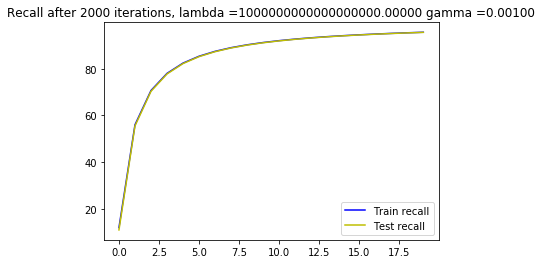

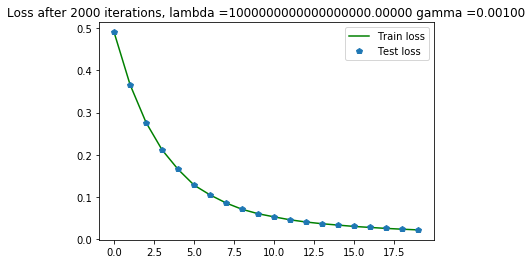

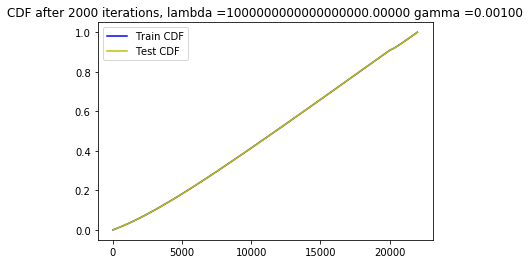


  0%|          | 2002/473047 [28:39<1131:25:18,  8.65s/it]

New score:  0.9796435
Train score:  0.9782301
Test score:  0.9778235
Objective 0.021191033
Objective first part 0.0
Objective second part -0.021191033
Objective 0.7847007
Objective first part 0.7636287
Objective second part -0.021071956



  0%|          | 2004/473047 [28:40<562:33:32,  4.30s/it]

Objective 0.02260222
Objective first part 0.0
Objective second part -0.02260222
Objective 0.79190725
Objective first part 0.7633585
Objective second part -0.028548801



  0%|          | 2006/473047 [28:40<283:31:54,  2.17s/it]

Objective 0.023659887
Objective first part 0.0
Objective second part -0.023659887
Objective 0.022993034
Objective first part 0.0
Objective second part -0.022993034



  0%|          | 2010/473047 [28:40<143:33:41,  1.10s/it]

Objective 0.78635556
Objective first part 0.7636326
Objective second part -0.02272294
Objective 0.021726443
Objective first part 0.0
Objective second part -0.021726443
Objective 0.7830097
Objective first part 0.762847
Objective second part -0.02016273
Objective 0.7864013
Objective first part 0.7650687
Objective second part -0.02133259



  0%|          | 2014/473047 [28:40<74:22:37,  1.76it/s] 

Objective 0.7853531
Objective first part 0.765722
Objective second part -0.019631132
Objective 0.7881313
Objective first part 0.76677656
Objective second part -0.021354755
Objective 0.019063368
Objective first part 0.0
Objective second part -0.019063368
Objective 0.025698347
Objective first part 0.0
Objective second part -0.025698347



  0%|          | 2020/473047 [28:41<39:03:02,  3.35it/s]

Objective 0.78775406
Objective first part 0.76492834
Objective second part -0.022825688
Objective 0.78499115
Objective first part 0.7632328
Objective second part -0.021758301
Objective 0.78762937
Objective first part 0.7651073
Objective second part -0.02252211
Objective 0.020532697
Objective first part 0.0
Objective second part -0.020532697
Objective 0.019562751
Objective first part 0.0
Objective second part -0.019562751
Objective 0.78346574
Objective first part 0.76226795
Objective second part -0.02119779



  0%|          | 2028/473047 [28:41<20:55:49,  6.25it/s]

Objective 0.78897864
Objective first part 0.76578045
Objective second part -0.023198167
Objective 0.7871517
Objective first part 0.76251894
Objective second part -0.024632778
Objective 0.023917964
Objective first part 0.0
Objective second part -0.023917964
Objective 0.78548604
Objective first part 0.7643907
Objective second part -0.021095332
Objective 0.022844104
Objective first part 0.0
Objective second part -0.022844104
Objective 0.7849364
Objective first part 0.7634761
Objective second part -0.021460345
Objective 0.79112107
Objective first part 0.7636119
Objective second part -0.027509172
Objective 0.02209766
Objective first part 0.0
Objective second part -0.02209766
Objective 0.02046188
Objective first part 0.0
Objective second part -0.02046188



  0%|          | 2034/473047 [28:41<15:21:36,  8.52it/s]


Objective 0.7870606
Objective first part 0.76572186
Objective second part -0.02133874
Objective 0.020178176
Objective first part 0.0
Objective second part -0.020178176
Objective 0.021778708
Objective first part 0.0
Objective second part -0.021778708
Objective 0.7922598
Objective first part 0.7672443
Objective second part -0.025015527
Objective 0.78343713
Objective first part 0.7624643
Objective second part -0.020972857
Objective 0.024216713
Objective first part 0.0
Objective second part -0.024216713
Objective 0.78345174
Objective first part 0.76502424
Objective second part -0.018427499
Objective 0.026568858
Objective first part 0.0
Objective second part -0.026568858


  0%|          | 2042/473047 [28:41<9:54:23, 13.21it/s] 

Objective 0.02241013
Objective first part 0.0
Objective second part -0.02241013
Objective 0.79026294
Objective first part 0.76881075
Objective second part -0.021452185
Objective 0.7825142
Objective first part 0.7623061
Objective second part -0.020208102
Objective 0.7901851
Objective first part 0.76741135
Objective second part -0.022773733
Objective 0.023899587
Objective first part 0.0
Objective second part -0.023899587
Objective 0.78804576
Objective first part 0.7641854
Objective second part -0.023860335
Objective 0.7881244
Objective first part 0.7652405
Objective second part -0.022883866
Objective 0.7885072
Objective first part 0.7637042
Objective second part -0.024803054



  0%|          | 2046/473047 [28:41<10:03:47, 13.00it/s]

Objective 0.78666943
Objective first part 0.76698333
Objective second part -0.019686086
Objective 0.78743684
Objective first part 0.7656184
Objective second part -0.021818487



  0%|          | 2049/473047 [28:42<11:55:26, 10.97it/s]

Objective 0.7884519
Objective first part 0.76565325
Objective second part -0.022798674
Objective 0.018705726
Objective first part 0.0
Objective second part -0.018705726
Objective 0.78757685
Objective first part 0.7648388
Objective second part -0.022738062
Objective 0.7813011
Objective first part 0.7634881
Objective second part -0.017812967



  0%|          | 2052/473047 [28:42<13:09:04,  9.95it/s]

Objective 0.022344604
Objective first part 0.0
Objective second part -0.022344604
Objective 0.02245292
Objective first part 0.0
Objective second part -0.02245292



  0%|          | 2054/473047 [28:42<13:49:52,  9.46it/s]

Objective 0.0197991
Objective first part 0.0
Objective second part -0.0197991
Objective 0.78729934
Objective first part 0.7659162
Objective second part -0.02138313



  0%|          | 2056/473047 [28:43<14:24:00,  9.09it/s]

Objective 0.020266004
Objective first part 0.0
Objective second part -0.020266004
Objective 0.7866558
Objective first part 0.763481
Objective second part -0.023174742



  0%|          | 2058/473047 [28:43<16:33:31,  7.90it/s]

Objective 0.019341104
Objective first part 0.0
Objective second part -0.019341104
Objective 0.023709934
Objective first part 0.0
Objective second part -0.023709934



  0%|          | 2061/473047 [28:43<16:37:07,  7.87it/s]

Objective 0.026072938
Objective first part 0.0
Objective second part -0.026072938
Objective 0.022653006
Objective first part 0.0
Objective second part -0.022653006



  0%|          | 2063/473047 [28:44<16:48:12,  7.79it/s]

Objective 0.023528311
Objective first part 0.0
Objective second part -0.023528311
Objective 0.7904453
Objective first part 0.76744485
Objective second part -0.023000475



  0%|          | 2065/473047 [28:44<16:45:54,  7.80it/s]

Objective 0.021370586
Objective first part 0.0
Objective second part -0.021370586
Objective 0.021117369
Objective first part 0.0
Objective second part -0.021117369



  0%|          | 2067/473047 [28:44<16:48:25,  7.78it/s]

Objective 0.78692895
Objective first part 0.76526535
Objective second part -0.021663582
Objective 0.017962847
Objective first part 0.0
Objective second part -0.017962847



  0%|          | 2069/473047 [28:44<16:50:11,  7.77it/s]

Objective 0.019082626
Objective first part 0.0
Objective second part -0.019082626
Objective 0.018117666
Objective first part 0.0
Objective second part -0.018117666
Objective 0.022327477
Objective first part 0.0
Objective second part -0.022327477



  0%|          | 2072/473047 [28:45<15:27:16,  8.47it/s]

Objective 0.023332689
Objective first part 0.0
Objective second part -0.023332689
Objective 0.024172807
Objective first part 0.0
Objective second part -0.024172807



  0%|          | 2075/473047 [28:45<13:03:00, 10.02it/s]

Objective 0.018893884
Objective first part 0.0
Objective second part -0.018893884
Objective 0.02342598
Objective first part 0.0
Objective second part -0.02342598
Objective 0.018654713
Objective first part 0.0
Objective second part -0.018654713



  0%|          | 2079/473047 [28:45<10:48:57, 12.10it/s]

Objective 0.019247342
Objective first part 0.0
Objective second part -0.019247342
Objective 0.7840284
Objective first part 0.76563555
Objective second part -0.018392833
Objective 0.020780595
Objective first part 0.0
Objective second part -0.020780595
Objective 0.02002614
Objective first part 0.0
Objective second part -0.02002614



  0%|          | 2083/473047 [28:45<9:09:21, 14.29it/s]

Objective 0.7886099
Objective first part 0.7663923
Objective second part -0.02221765
Objective 0.021981765
Objective first part 0.0
Objective second part -0.021981765
Objective 0.7874017
Objective first part 0.7663548
Objective second part -0.021046875
Objective 0.7849321
Objective first part 0.7651607
Objective second part -0.019771377



  0%|          | 2088/473047 [28:46<7:49:11, 16.73it/s]

Objective 0.017977169
Objective first part 0.0
Objective second part -0.017977169
Objective 0.02125228
Objective first part 0.0
Objective second part -0.02125228
Objective 0.018407706
Objective first part 0.0
Objective second part -0.018407706
Objective 0.017552154
Objective first part 0.0
Objective second part -0.017552154
Objective 0.021129483
Objective first part 0.0
Objective second part -0.021129483



  0%|          | 2092/473047 [28:46<6:38:24, 19.70it/s]

Objective 0.018053515
Objective first part 0.0
Objective second part -0.018053515
Objective 0.785845
Objective first part 0.76517755
Objective second part -0.020667408
Objective 0.020175016
Objective first part 0.0
Objective second part -0.020175016
Objective 0.78486294
Objective first part 0.7652398
Objective second part -0.01962317
Objective 0.7861303
Objective first part 0.76592815
Objective second part -0.020202141
Objective 0.78585386
Objective first part 0.7670088
Objective second part -0.018845111
Objective 0.7841871
Objective first part 0.76412636
Objective second part -0.020060742



  0%|          | 2099/473047 [28:46<5:29:58, 23.79it/s]

Objective 0.7894306
Objective first part 0.766857
Objective second part -0.022573564
Objective 0.018770345
Objective first part 0.0
Objective second part -0.018770345
Objective 0.01978846
Objective first part 0.0
Objective second part -0.01978846
Objective 0.78497225
Objective first part 0.7654706
Objective second part -0.019501606
Objective 0.020453364
Objective first part 0.0
Objective second part -0.020453364



  0%|          | 2099/473047 [29:04<5:29:58, 23.79it/s]

train loss first part 1.217397885648614e-09
train loss second part -0.02061472



  0%|          | 2104/473047 [30:07<1116:05:49,  8.53s/it]

Objective 0.7854797
Objective first part 0.76624084
Objective second part -0.019238895
Objective 0.78673744
Objective first part 0.7671344
Objective second part -0.01960299
Objective 0.7909795
Objective first part 0.7678445
Objective second part -0.02313503
Objective 0.019032264
Objective first part 0.0
Objective second part -0.019032264
Objective 0.019967642
Objective first part 0.0
Objective second part -0.019967642
Objective 0.020955328
Objective first part 0.0
Objective second part -0.020955328
Objective 0.7856536
Objective first part 0.76350296
Objective second part -0.022150615



  0%|          | 2114/473047 [30:07<548:23:21,  4.19s/it]

Objective 0.021244913
Objective first part 0.0
Objective second part -0.021244913
Objective 0.7832698
Objective first part 0.7647642
Objective second part -0.01850564
Objective 0.78548825
Objective first part 0.76529837
Objective second part -0.020189855
Objective 0.7837559
Objective first part 0.76470315
Objective second part -0.019052736
Objective 0.7884749
Objective first part 0.7665637
Objective second part -0.021911211
Objective 0.7838315
Objective first part 0.7641625
Objective second part -0.019669004
Objective 0.7869823
Objective first part 0.76608104
Objective second part -0.02090128
Objective 0.7842115
Objective first part 0.76714677
Objective second part -0.017064748



  0%|          | 2120/473047 [30:08<271:03:17,  2.07s/it]

Objective 0.7840698
Objective first part 0.76457083
Objective second part -0.019498931
Objective 0.017432662
Objective first part 0.0
Objective second part -0.017432662
Objective 0.784209
Objective first part 0.76501197
Objective second part -0.01919703
Objective 0.022109542
Objective first part 0.0
Objective second part -0.022109542
Objective 0.78615373
Objective first part 0.767079
Objective second part -0.019074729
Objective 0.7875476
Objective first part 0.76639676
Objective second part -0.021150852



  0%|          | 2126/473047 [30:08<135:07:17,  1.03s/it]

Objective 0.7866277
Objective first part 0.7665979
Objective second part -0.020029789
Objective 0.7848811
Objective first part 0.7644907
Objective second part -0.020390399
Objective 0.78558636
Objective first part 0.76552165
Objective second part -0.020064695
Objective 0.01859763
Objective first part 0.0
Objective second part -0.01859763
Objective 0.01900754
Objective first part 0.0
Objective second part -0.01900754
Objective 0.021466862
Objective first part 0.0
Objective second part -0.021466862
Objective 0.78566
Objective first part 0.7659765
Objective second part -0.019683532



  0%|          | 2133/473047 [30:08<68:50:25,  1.90it/s]

Objective 0.7878259
Objective first part 0.7664109
Objective second part -0.021414978
Objective 0.78392255
Objective first part 0.76520836
Objective second part -0.018714167
Objective 0.022599414
Objective first part 0.0
Objective second part -0.022599414
Objective 0.7829817
Objective first part 0.7648327
Objective second part -0.018149046
Objective 0.7825332
Objective first part 0.76202273
Objective second part -0.02051049
Objective 0.022872766
Objective first part 0.0
Objective second part -0.022872766
Objective 0.78499883
Objective first part 0.7654883
Objective second part -0.01951048



  0%|          | 2136/473047 [30:08<52:21:40,  2.50it/s]

Objective 0.022086386
Objective first part 0.0
Objective second part -0.022086386
Objective 0.022106983
Objective first part 0.0
Objective second part -0.022106983



  0%|          | 2139/473047 [30:09<41:23:57,  3.16it/s]

Objective 0.7852451
Objective first part 0.76734275
Objective second part -0.017902346
Objective 0.78614557
Objective first part 0.7658806
Objective second part -0.02026497



  0%|          | 2141/473047 [30:09<33:38:10,  3.89it/s]

Objective 0.017740158
Objective first part 0.0
Objective second part -0.017740158
Objective 0.01727637
Objective first part 0.0
Objective second part -0.01727637



  0%|          | 2143/473047 [30:09<27:53:29,  4.69it/s]

Objective 0.78586304
Objective first part 0.76480335
Objective second part -0.02105972
Objective 0.7873892
Objective first part 0.7676635
Objective second part -0.019725721



  0%|          | 2145/473047 [30:09<24:07:45,  5.42it/s]

Objective 0.7876249
Objective first part 0.7652394
Objective second part -0.022385504
Objective 0.7878236
Objective first part 0.7658244
Objective second part -0.021999251



  0%|          | 2147/473047 [30:10<21:17:57,  6.14it/s]

Objective 0.018703174
Objective first part 0.0
Objective second part -0.018703174
Objective 0.78325176
Objective first part 0.76566327
Objective second part -0.01758849



  0%|          | 2149/473047 [30:10<19:25:26,  6.73it/s]

Objective 0.78281903
Objective first part 0.7658525
Objective second part -0.016966533
Objective 0.019954205
Objective first part 0.0
Objective second part -0.019954205



  0%|          | 2151/473047 [30:10<18:20:46,  7.13it/s]

Objective 0.021056797
Objective first part 0.0
Objective second part -0.021056797
Objective 0.78462577
Objective first part 0.76436114
Objective second part -0.020264605



  0%|          | 2153/473047 [30:10<17:25:44,  7.50it/s]

Objective 0.789598
Objective first part 0.76849055
Objective second part -0.021107445
Objective 0.021599445
Objective first part 0.0
Objective second part -0.021599445



  0%|          | 2155/473047 [30:11<16:24:28,  7.97it/s]

Objective 0.7872878
Objective first part 0.76815486
Objective second part -0.01913293
Objective 0.78567225
Objective first part 0.766039
Objective second part -0.019633261



  0%|          | 2157/473047 [30:11<16:03:57,  8.14it/s]

Objective 0.017733242
Objective first part 0.0
Objective second part -0.017733242
Objective 0.017235499
Objective first part 0.0
Objective second part -0.017235499



  0%|          | 2159/473047 [30:11<16:12:19,  8.07it/s]

Objective 0.025066864
Objective first part 0.0
Objective second part -0.025066864
Objective 0.7874402
Objective first part 0.76779175
Objective second part -0.019648457



  0%|          | 2161/473047 [30:11<16:29:44,  7.93it/s]

Objective 0.018207194
Objective first part 0.0
Objective second part -0.018207194
Objective 0.01993876
Objective first part 0.0
Objective second part -0.01993876



  0%|          | 2163/473047 [30:12<16:40:23,  7.84it/s]

Objective 0.78584945
Objective first part 0.7684051
Objective second part -0.017444368
Objective 0.7856432
Objective first part 0.7678508
Objective second part -0.017792398



  0%|          | 2166/473047 [30:12<13:54:13,  9.41it/s]

Objective 0.01979594
Objective first part 0.0
Objective second part -0.01979594
Objective 0.01936061
Objective first part 0.0
Objective second part -0.01936061
Objective 0.78871053
Objective first part 0.7674651
Objective second part -0.0212454
Objective 0.7910851
Objective first part 0.76630384
Objective second part -0.024781302



  0%|          | 2170/473047 [30:12<10:58:51, 11.91it/s]

Objective 0.02188343
Objective first part 0.0
Objective second part -0.02188343
Objective 0.021678505
Objective first part 0.0
Objective second part -0.021678505
Objective 0.78529626
Objective first part 0.7671729
Objective second part -0.018123372
Objective 0.017600441
Objective first part 0.0
Objective second part -0.017600441



  0%|          | 2175/473047 [30:12<8:54:02, 14.70it/s] 

Objective 0.7808552
Objective first part 0.7624277
Objective second part -0.018427499
Objective 0.7828102
Objective first part 0.7639622
Objective second part -0.018848026
Objective 0.7855266
Objective first part 0.7653986
Objective second part -0.02012794
Objective 0.78663874
Objective first part 0.76656365
Objective second part -0.020075094
Objective 0.023488281
Objective first part 0.0
Objective second part -0.023488281
Objective 0.01865192



  0%|          | 2181/473047 [30:13<6:45:33, 19.35it/s]

Objective first part 0.0
Objective second part -0.01865192
Objective 0.78511155
Objective first part 0.7664725
Objective second part -0.018639047
Objective 0.7858815
Objective first part 0.76725405
Objective second part -0.018627448
Objective 0.018897954
Objective first part 0.0
Objective second part -0.018897954
Objective 0.020371845
Objective first part 0.0
Objective second part -0.020371845
Objective 0.7891423
Objective first part 0.7681349
Objective second part -0.021007432



  0%|          | 2187/473047 [30:13<5:36:50, 23.30it/s]

Objective 0.7810428
Objective first part 0.76383686
Objective second part -0.017205967
Objective 0.78669846
Objective first part 0.76733094
Objective second part -0.019367538
Objective 0.78382957
Objective first part 0.7658758
Objective second part -0.017953744
Objective 0.020668626
Objective first part 0.0
Objective second part -0.020668626
Objective 0.019404609
Objective first part 0.0
Objective second part -0.019404609
Objective 0.021931134
Objective first part 0.0
Objective second part -0.021931134



  0%|          | 2190/473047 [30:13<5:24:10, 24.21it/s]

Objective 0.019147573
Objective first part 0.0
Objective second part -0.019147573
Objective 0.7834015
Objective first part 0.7647269
Objective second part -0.018674633
Objective 0.7866222
Objective first part 0.7674371
Objective second part -0.019185122
Objective 0.025507987
Objective first part 0.0
Objective second part -0.025507987



  0%|          | 2193/473047 [30:13<5:59:08, 21.85it/s]

Objective 0.0190692
Objective first part 0.0
Objective second part -0.0190692
Objective 0.78576386
Objective first part 0.766637
Objective second part -0.019126855
Objective 0.78482944
Objective first part 0.76652807
Objective second part -0.018301345



  0%|          | 2196/473047 [30:13<7:14:38, 18.05it/s]

Objective 0.7825919
Objective first part 0.76324344
Objective second part -0.019348456
Objective 0.018053818
Objective first part 0.0
Objective second part -0.018053818
Objective 0.78159076
Objective first part 0.76461685
Objective second part -0.016973928



  0%|          | 2199/473047 [30:14<8:30:39, 15.37it/s]

Objective 0.018577836
Objective first part 0.0
Objective second part -0.018577836
Objective 0.78342104
Objective first part 0.76623684
Objective second part -0.017184198



  0%|          | 2199/473047 [30:34<8:30:39, 15.37it/s]

train loss first part 1.2189179414059941e-09
train loss second part -0.01940385



  0%|          | 2202/473047 [31:36<1133:11:23,  8.66s/it]

Objective 0.7857739
Objective first part 0.7674502
Objective second part -0.018323684
Objective 0.78971326
Objective first part 0.7675255
Objective second part -0.022187788



  0%|          | 2204/473047 [31:36<563:50:00,  4.31s/it]

Objective 0.020652499
Objective first part 0.0
Objective second part -0.020652499
Objective 0.016673638
Objective first part 0.0
Objective second part -0.016673638



  0%|          | 2206/473047 [31:36<284:49:18,  2.18s/it]

Objective 0.02304268
Objective first part 0.0
Objective second part -0.02304268
Objective 0.016421666
Objective first part 0.0
Objective second part -0.016421666



  0%|          | 2208/473047 [31:36<147:52:45,  1.13s/it]

Objective 0.78520876
Objective first part 0.76827115
Objective second part -0.016937615
Objective 0.78525937
Objective first part 0.76568866
Objective second part -0.019570714



  0%|          | 2210/473047 [31:37<81:02:23,  1.61it/s] 

Objective 0.021213863
Objective first part 0.0
Objective second part -0.021213863
Objective 0.7863549
Objective first part 0.7679066
Objective second part -0.018448323



  0%|          | 2212/473047 [31:37<48:00:12,  2.72it/s]

Objective 0.01706584
Objective first part 0.0
Objective second part -0.01706584
Objective 0.78642815
Objective first part 0.7658881
Objective second part -0.020540059



  0%|          | 2214/473047 [31:37<32:13:27,  4.06it/s]

Objective 0.7847578
Objective first part 0.76756996
Objective second part -0.017187836
Objective 0.78142476
Objective first part 0.7633624
Objective second part -0.018062375



  0%|          | 2216/473047 [31:37<24:22:58,  5.36it/s]

Objective 0.7861161
Objective first part 0.7668459
Objective second part -0.019270249
Objective 0.78312373
Objective first part 0.7666802
Objective second part -0.01644354



  0%|          | 2218/473047 [31:38<20:28:53,  6.39it/s]

Objective 0.7855559
Objective first part 0.7664646
Objective second part -0.019091314
Objective 0.7854042
Objective first part 0.7681928
Objective second part -0.017211365



  0%|          | 2221/473047 [31:38<17:13:17,  7.59it/s]

Objective 0.7870774
Objective first part 0.7663479
Objective second part -0.020729536
Objective 0.019509083
Objective first part 0.0
Objective second part -0.019509083
Objective 0.018310087
Objective first part 0.0
Objective second part -0.018310087



  0%|          | 2223/473047 [31:38<16:08:25,  8.10it/s]

Objective 0.021555107
Objective first part 0.0
Objective second part -0.021555107
Objective 0.7877963
Objective first part 0.76835597
Objective second part -0.019440344
Objective 0.019096904
Objective first part 0.0
Objective second part -0.019096904



  0%|          | 2228/473047 [31:38<11:37:59, 11.24it/s]

Objective 0.78770536
Objective first part 0.7683246
Objective second part -0.019380724
Objective 0.020540971
Objective first part 0.0
Objective second part -0.020540971
Objective 0.78607494
Objective first part 0.7669242
Objective second part -0.019150732
Objective 0.78549325
Objective first part 0.76814294
Objective second part -0.0173503



  0%|          | 2232/473047 [31:39<10:03:45, 13.00it/s]

Objective 0.7850749
Objective first part 0.7649703
Objective second part -0.020104589
Objective 0.78614527
Objective first part 0.7681129
Objective second part -0.018032394
Objective 0.78825724
Objective first part 0.7681293
Objective second part -0.02012794
Objective 0.018473702
Objective first part 0.0
Objective second part -0.018473702



  0%|          | 2238/473047 [31:39<7:18:28, 17.90it/s]

Objective 0.7843815
Objective first part 0.76613426
Objective second part -0.018247258
Objective 0.78534573
Objective first part 0.76825905
Objective second part -0.017086698
Objective 0.7887617
Objective first part 0.7678173
Objective second part -0.020944372
Objective 0.01873111
Objective first part 0.0
Objective second part -0.01873111
Objective 0.020382613
Objective first part 0.0
Objective second part -0.020382613
Objective 0.79015094
Objective first part 0.766942
Objective second part -0.023208903



  0%|          | 2244/473047 [31:39<5:56:22, 22.02it/s]

Objective 0.78453976
Objective first part 0.765346
Objective second part -0.01919375
Objective 0.019938273
Objective first part 0.0
Objective second part -0.019938273
Objective 0.019684808
Objective first part 0.0
Objective second part -0.019684808
Objective 0.017614273
Objective first part 0.0
Objective second part -0.017614273
Objective 0.017486583
Objective first part 0.0
Objective second part -0.017486583
Objective 0.78618807
Objective first part 0.76555675
Objective second part -0.020631324



  0%|          | 2247/473047 [31:39<5:32:55, 23.57it/s]

Objective 0.7839702
Objective first part 0.7677233
Objective second part -0.016246874
Objective 0.017138842
Objective first part 0.0
Objective second part -0.017138842
Objective 0.787057
Objective first part 0.7651768
Objective second part -0.0218802
Objective 0.7850998
Objective first part 0.7673255
Objective second part -0.017774256
Objective 0.018639654
Objective first part 0.0
Objective second part -0.018639654



  0%|          | 2250/473047 [31:39<5:55:59, 22.04it/s]

Objective 0.01838931
Objective first part 0.0
Objective second part -0.01838931
Objective 0.7844945
Objective first part 0.7659864
Objective second part -0.018508129



  0%|          | 2253/473047 [31:40<8:46:24, 14.91it/s]

Objective 0.786162
Objective first part 0.76866406
Objective second part -0.017497927
Objective 0.78613436
Objective first part 0.7647648
Objective second part -0.021369552



  0%|          | 2255/473047 [31:40<11:11:47, 11.68it/s]

Objective 0.78481823
Objective first part 0.76696247
Objective second part -0.017855743
Objective 0.024907054
Objective first part 0.0
Objective second part -0.024907054



  0%|          | 2257/473047 [31:40<12:55:27, 10.12it/s]

Objective 0.01938741
Objective first part 0.0
Objective second part -0.01938741
Objective 0.7857569
Objective first part 0.76617473
Objective second part -0.019582141



  0%|          | 2259/473047 [31:40<14:02:11,  9.32it/s]

Objective 0.017219186
Objective first part 0.0
Objective second part -0.017219186
Objective 0.7867042
Objective first part 0.7681092
Objective second part -0.01859496



  0%|          | 2261/473047 [31:41<15:03:57,  8.68it/s]

Objective 0.7860443
Objective first part 0.76446855
Objective second part -0.021575753
Objective 0.7873365
Objective first part 0.7689575
Objective second part -0.018379051



  0%|          | 2263/473047 [31:41<14:58:25,  8.73it/s]

Objective 0.02021473
Objective first part 0.0
Objective second part -0.02021473
Objective 0.7881399
Objective first part 0.7675251
Objective second part -0.020614775
Objective 0.783279
Objective first part 0.7671677
Objective second part -0.016111303



  0%|          | 2265/473047 [31:41<13:01:00, 10.05it/s]

Objective 0.78025025
Objective first part 0.7642778
Objective second part -0.01597242
Objective 0.017535776
Objective first part 0.0
Objective second part -0.017535776



  0%|          | 2267/473047 [31:41<13:25:08,  9.75it/s]

Objective 0.7866708
Objective first part 0.7687124
Objective second part -0.017958418
Objective 0.78155416
Objective first part 0.7662262
Objective second part -0.015327981



  0%|          | 2270/473047 [31:42<15:06:14,  8.66it/s]

Objective 0.7852584
Objective first part 0.7680174
Objective second part -0.017241018
Objective 0.7846169
Objective first part 0.76824194
Objective second part -0.016374951



  0%|          | 2272/473047 [31:42<16:08:59,  8.10it/s]

Objective 0.78329515
Objective first part 0.7641601
Objective second part -0.019135058
Objective 0.017206937
Objective first part 0.0
Objective second part -0.017206937



  0%|          | 2274/473047 [31:42<16:29:01,  7.93it/s]

Objective 0.78539276
Objective first part 0.7672112
Objective second part -0.01818158
Objective 0.01806638
Objective first part 0.0
Objective second part -0.01806638



  0%|          | 2276/473047 [31:42<16:40:38,  7.84it/s]

Objective 0.017917335
Objective first part 0.0
Objective second part -0.017917335
Objective 0.01842762
Objective first part 0.0
Objective second part -0.01842762



  0%|          | 2278/473047 [31:43<16:34:17,  7.89it/s]

Objective 0.018722123
Objective first part 0.0
Objective second part -0.018722123
Objective 0.018053273
Objective first part 0.0
Objective second part -0.018053273



  0%|          | 2280/473047 [31:43<16:43:16,  7.82it/s]

Objective 0.7888079
Objective first part 0.7669885
Objective second part -0.021819402
Objective 0.7844089
Objective first part 0.76619995
Objective second part -0.018208954



  0%|          | 2284/473047 [31:43<12:41:53, 10.30it/s]

Objective 0.79069036
Objective first part 0.7691546
Objective second part -0.02153574
Objective 0.7890325
Objective first part 0.7682174
Objective second part -0.02081516
Objective 0.019977432
Objective first part 0.0
Objective second part -0.019977432
Objective 0.021557055
Objective first part 0.0
Objective second part -0.021557055



  0%|          | 2288/473047 [31:43<10:40:24, 12.25it/s]

Objective 0.7869089
Objective first part 0.766682
Objective second part -0.020226896
Objective 0.016533645
Objective first part 0.0
Objective second part -0.016533645
Objective 0.017833717
Objective first part 0.0
Objective second part -0.017833717



  0%|          | 2290/473047 [31:44<9:38:17, 13.57it/s] 

Objective 0.016702002
Objective first part 0.0
Objective second part -0.016702002
Objective 0.020464009
Objective first part 0.0
Objective second part -0.020464009
Objective 0.7863472
Objective first part 0.76713854
Objective second part -0.019208698
Objective 0.018661758
Objective first part 0.0
Objective second part -0.018661758
Objective 0.78521454
Objective first part 0.76876014
Objective second part -0.016454386



  0%|          | 2296/473047 [31:44<7:20:09, 17.83it/s]

Objective 0.78790694
Objective first part 0.76817435
Objective second part -0.01973259
Objective 0.018774657
Objective first part 0.0
Objective second part -0.018774657
Objective 0.7887695
Objective first part 0.7688639
Objective second part -0.01990556
Objective 0.78691757
Objective first part 0.7674044
Objective second part -0.019513214
Objective 0.78828907
Objective first part 0.7683195
Objective second part -0.019969588



  0%|          | 2299/473047 [31:44<6:58:58, 18.73it/s]

Objective 0.017188381
Objective first part 0.0
Objective second part -0.017188381
Objective 0.019285075
Objective first part 0.0
Objective second part -0.019285075
Objective 0.019070597
Objective first part 0.0
Objective second part -0.019070597


In [ ]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])